In [1]:
import copy
import glob
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import scipy.stats
import tqdm
import warnings

In [2]:
import yt
import trident
import unyt

In [3]:
import kalepy as kale

In [4]:
import trove
import verdict

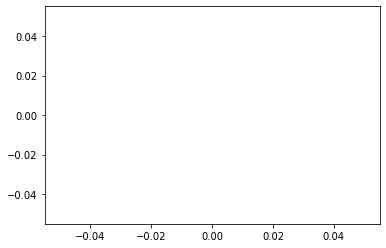

In [5]:
import matplotlib
import matplotlib.pyplot as plt
# # Currently need to call this to get matplotlib selected style to load...
plt.plot()
matplotlib.style.use( '/Users/zhafen/repos/clean-bold/clean-bold-mnras.mplstyle' )
import palettable
import matplotlib.patheffects as path_effects

In [6]:
import helpers

# Parameters

In [7]:
variations = [ 
    'original',
    'high-z',
]

In [8]:
params = {
    # Analysis 
    'prop_keys': [ 'vlos', 'T', 'nH', 'Z' ],
    'vel_prop_keys': [ 'vlos', 'T', 'nH', 'Z', 'NHI' ],
    'broaden_models': True,
    '1D_dist_estimation': 'kde',
    '1D_dist_estimation_data': 'histogram',
    '2D_dist_estimation': 'histogram',
    'export_data_for_proposal': False,
    'f_enclosed': [ 0.5, 0.75, 0.9, 0.99 ],
    
    # Plotting Choices
    'smooth_2D_dist': 0.5,
    'upsample_2D_dist': 3,
    '2D_dist_data_display': 'histogram',
    'contour_levels': [ 90, 50 ],
    'contour_linewidths': [ 1, 3 ],
    'show_plots_in_nb': False,
}

## Analysis

## Plotting

In [9]:
variation_plotting_params = {
    'original': {
        'color': helpers.blinded_color,
        'label': 'estimated',
        'offset': -0.2,
    },
    'high-z': {
        'color': helpers.revised_color,
        'label': 'revised',
        'offset': 0.2,
    },
}

In [10]:
correlation_markers = {
    'one-sided': '^',
    'log one-sided': '^',
    'two-sided': 'D',
    'linear': 'o',
    'log': 'o',
}
correlation_sizes = {
    'one-sided': 100,
    'log one-sided': 100,
    'two-sided': 80,
    'linear': 100,
    'log': 100,
}
correlations_plotted = [ 'linear', 'log' ]

In [11]:
mosaic = [
    [ 'vlos', 'legend', '.', '.' ],
    [ 'T_vlos', 'T', '.', '.' ],
    [ 'nH_vlos', 'nH_T', 'nH', '.' ],
    [ 'Z_vlos', 'Z_T', 'Z_nH', 'Z', ],
]
velocity_mosaic = [
    [ 'nH_vlos', 'vlos', ],
    [ 'Z_vlos', 'T_vlos', ],
]
mosaic_dist = [ [ 'vlos', 'Z' ], [ 'T', 'nH' ] ]

In [12]:
cmap = palettable.cartocolors.qualitative.Safe_10.mpl_colors
corr_cmap = palettable.cartocolors.diverging.Temps_2_r.mpl_colormap

In [13]:
corr_norm = matplotlib.colors.Normalize( vmin=0, vmax=1 )

In [14]:
def one_color_linear_cmap( color, name, f_white=0.95, f_saturated=1.0, ):
    '''A function that turns a single color into linear colormap that
    goes from a color that is whiter than the original color to a color
    that is more saturated than the original color.
    '''
    
    color_hsv = matplotlib.colors.rgb_to_hsv( color )
    start_color_hsv = copy.copy( color_hsv )
    
    start_color_hsv = copy.copy( color_hsv )
    start_color_hsv[1] -= f_white * start_color_hsv[1]
    start_color_hsv[2] += f_white * ( 1. - start_color_hsv[2] )
    start_color = matplotlib.colors.hsv_to_rgb( start_color_hsv )
    
    end_color_hsv = copy.copy( color_hsv )
    end_color_hsv[1] += f_saturated * ( 1. - end_color_hsv[1] )
    end_color = matplotlib.colors.hsv_to_rgb( end_color_hsv )
    
    return matplotlib.colors.LinearSegmentedColormap.from_list( name, [ start_color, end_color ] )

## Process analysis parameteres

In [15]:
# Load parameters
pms = {}
for variation in variations:
    pm = trove.link_params_to_config(
        '/Users/zhafen/analysis/cgm_modeling_challenge/sample2.trove',
        script_id = 'nb.2',
        variation = variation,
        global_variation = '',
        **params
    )
    pms[variation] = pm
pm = list( pms.values() )[0]

# Load Data

In [16]:
correlations_fp = os.path.join( pm['polished_data_dir'], 'correlation_coefficients.h5' )
correlations_all = verdict.Dict.from_hdf5( correlations_fp )

/Users/zhafen/repos/verdict/verdict.py:1516: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if hasattr( a[first_element_index][0], 'decode' ):


In [17]:
absorption_properties_fp = os.path.join( pm['polished_data_dir'], 'absorption_system_properties.h5' )
absorption_properties = verdict.Dict.from_hdf5( absorption_properties_fp, )

In [18]:
sls = list( correlations_all[pm['public_label']]['linear']['ndim'].keys() )
n_sls = len( sls )
xs = np.linspace( -0.5, 0.5, n_sls ) / 2

# Distribution Comparisons

## 1D Distributions

In [19]:
panel_length = plt.rcParams['figure.figsize'][0]
n_row = len( mosaic_dist )
n_col = len( mosaic_dist[0] )
figsize = ( panel_length * n_row, panel_length * n_col )

In [20]:
%%capture
dist_figs = []

for i, sl in enumerate( sls ):

    # Setup figure
    fig = plt.figure( figsize=figsize )
    main_ax = plt.gca()
    main_ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
    for spine in main_ax.spines.values():
        spine.set_visible( False )

    ax_dict = fig.subplot_mosaic(
        mosaic_dist,
    )

    # main_ax.set_xlabel( '% of likelihood distribution enclosed', labelpad=30 )
    # main_ax.set_ylabel( '% of synthetic data enclosed', labelpad=30 )

    for ax_key, ax in ax_dict.items():

        ax.annotate(
            text = helpers.property_labels_no_units[ax_key],
            xy = ( 0, 1 ),
            xycoords = 'axes fraction',
            xytext = ( 5, -5 ),
            textcoords = 'offset points',
            va = 'top',
            ha = 'left',
        )

        ax.set_xlim( helpers.lims[ax_key] )
        ax.set_ylim( helpers.lims_1D[ax_key] )

        ax.set_yscale( 'log' )
        if helpers.logscale[ax_key]:
            ax.set_xscale( 'log' )

    main_ax.set_title(
        label = sl,
        loc = 'right',
    )

    for prop_key in ax_dict.keys():

        # Get plot panel
        ax = ax_dict[prop_key]
        subplotspec = ax.get_subplotspec()

        # Get data distributions
        centers_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key]
        dist_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key]

        ax.fill_between(
            centers_data,
            dist_data,
            color = 'k',
            step = 'mid',
        )

        for variation, pm in pms.items():

            # Modeled distribution
            centers_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key]
            bins_estimated = np.full( centers_estimated.shape, np.nan )
            bin_widths = np.diff( centers_estimated )
            bins_estimated[0:centers_estimated.size-1] = centers_estimated[:-1] - bin_widths / 2.
            bins_estimated[centers_estimated.size-1] = centers_estimated[-1] + bin_widths[-1] / 2.
            dist_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key]

            ax.step(
                centers_estimated,
                dist_estimated,
                where = 'mid',
                color = helpers.colors_for_variations[variation],
            )
            
    dist_figs.append( fig )

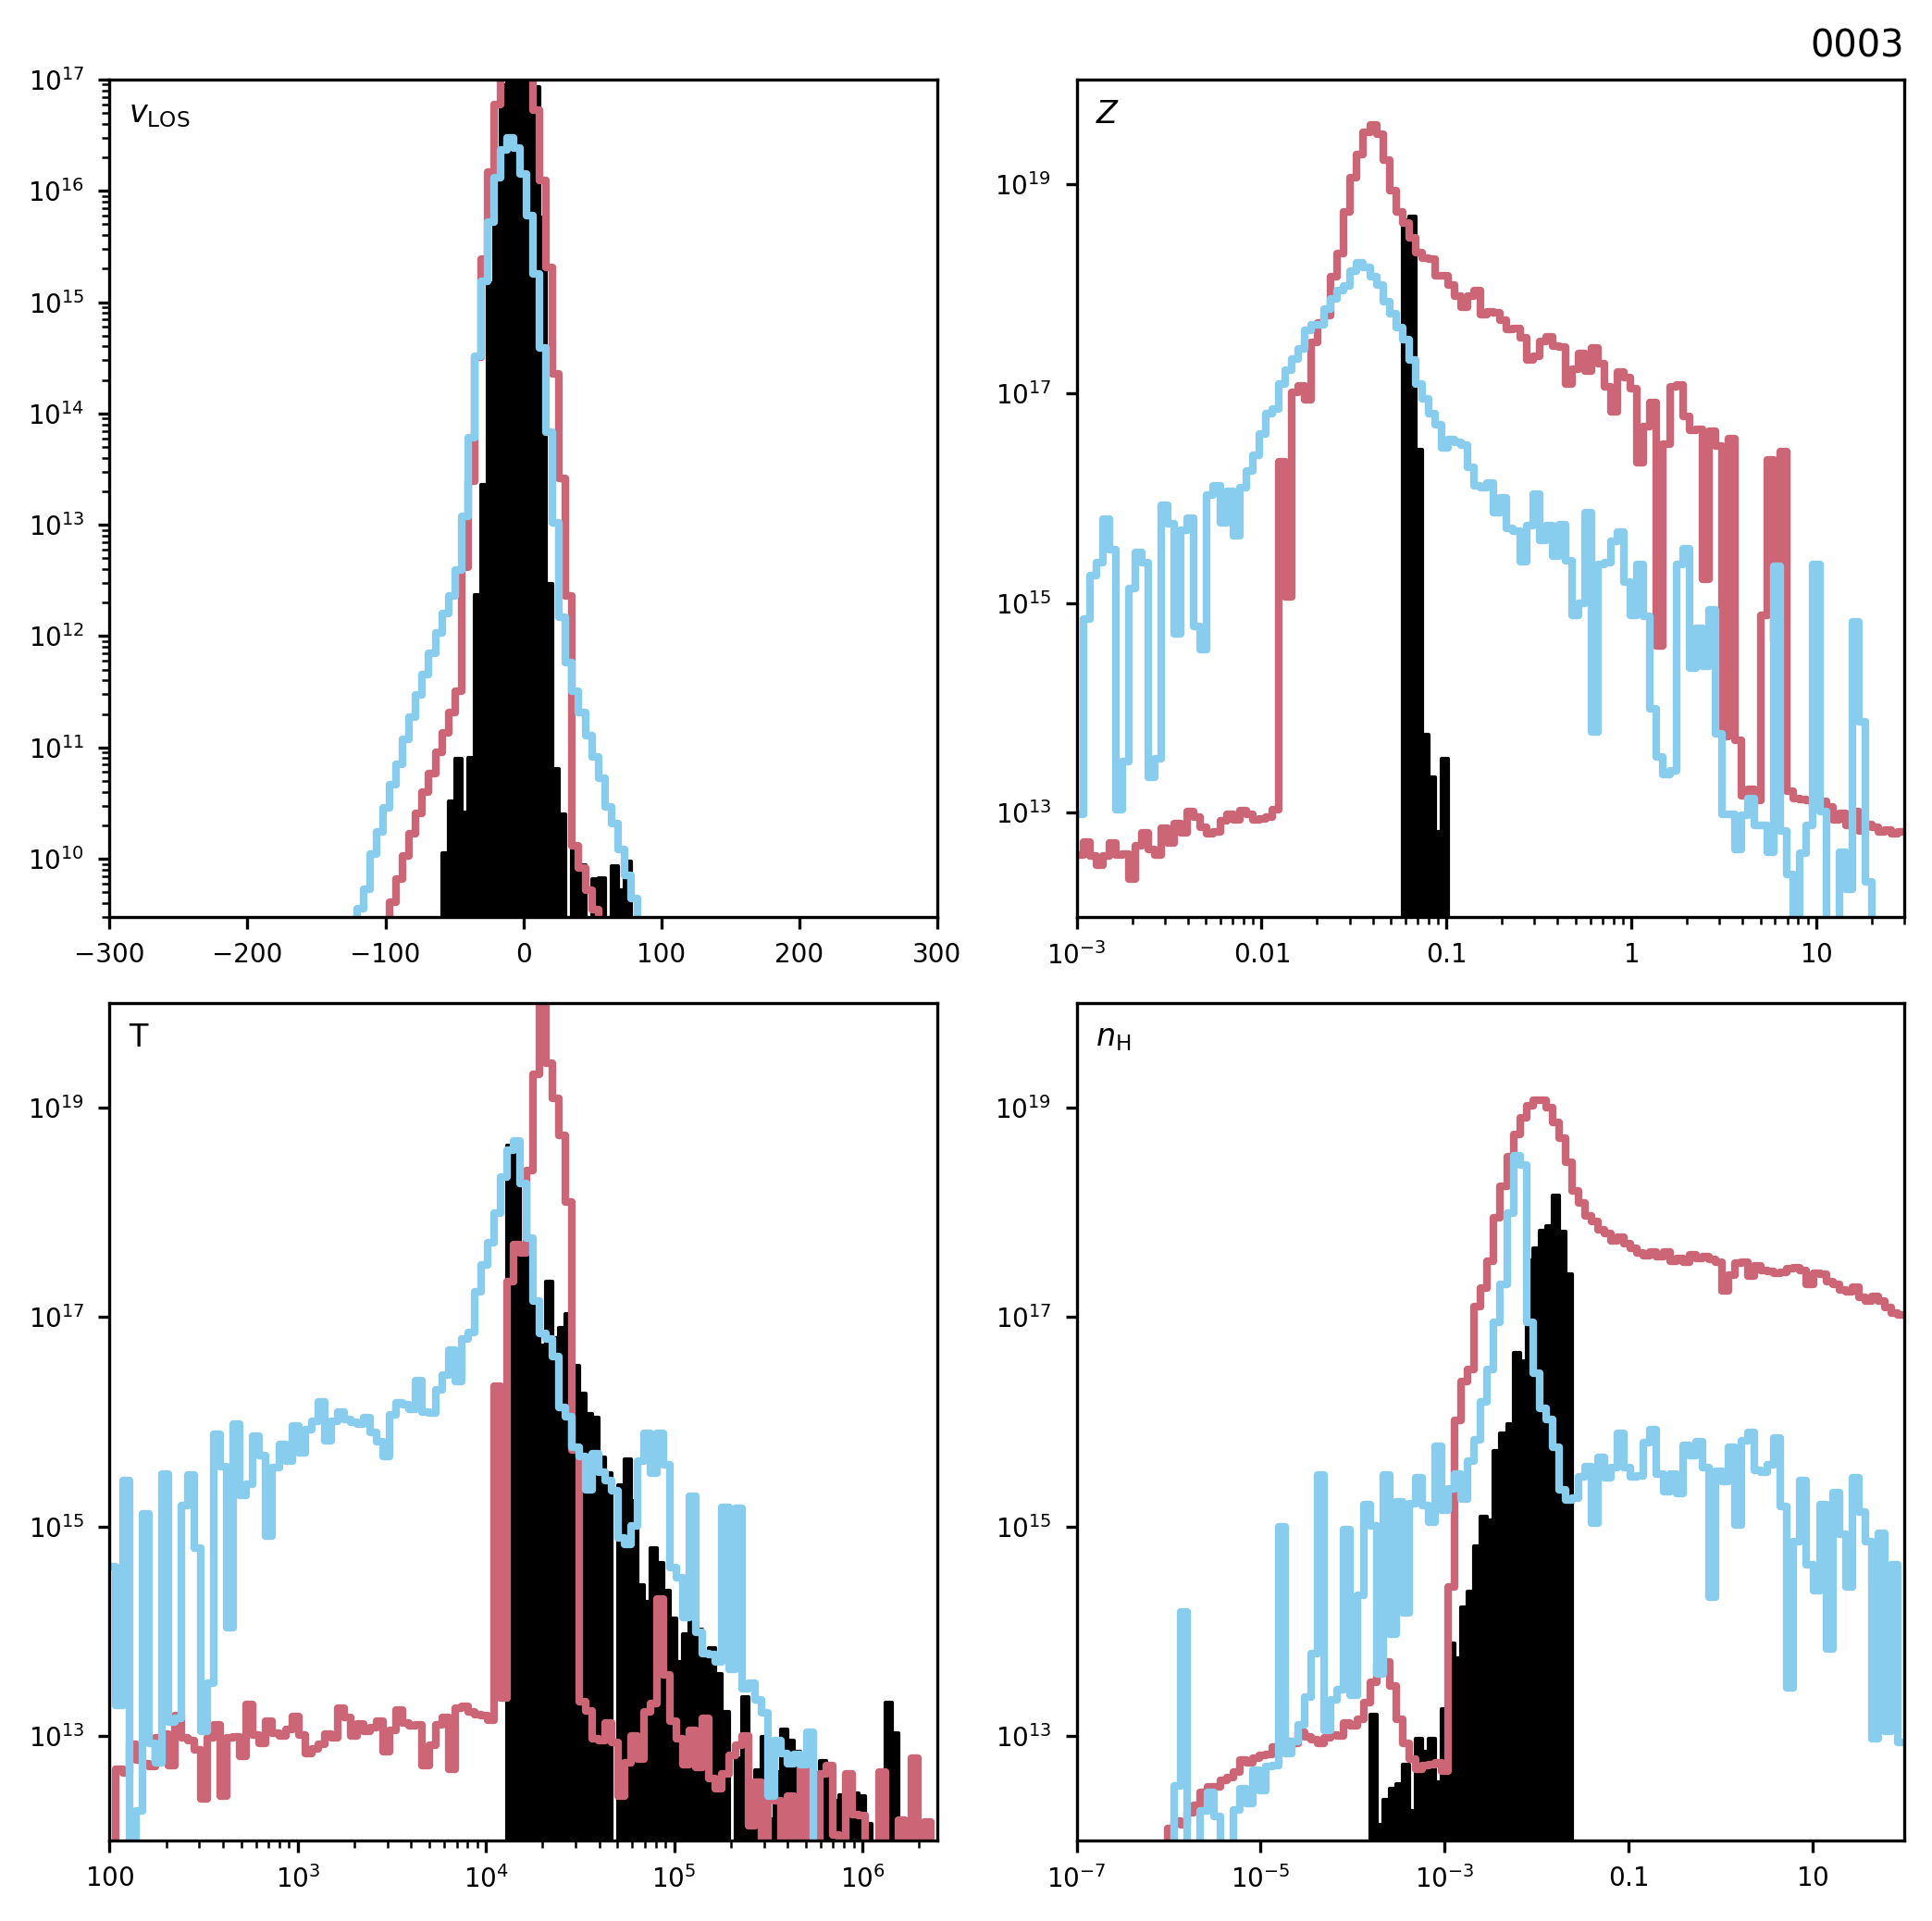

In [21]:
dist_figs[0]

## Violin Plots

### Plotting Setup

In [22]:
def plot_violin( get_violin_input, pms, fig_tuple=None, color='k', use_helper_colors=True, alpha=0.5, logscale_distributions=False ):

    if fig_tuple is None:
        n_rows = len( mosaic_dist )
        n_cols = len( mosaic_dist[0] )
        panel_width = matplotlib.rcParams['figure.figsize'][0]
        fig = plt.figure( figsize=(n_cols*panel_width, n_rows*panel_width/2.), facecolor='w' )
        main_ax = plt.gca()
        main_ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
        for spine in main_ax.spines.values():
            spine.set_visible( False )

        ax_dict = fig.subplot_mosaic(
            mosaic_dist,
        )
    else:
        fig, main_ax, ax_dict = fig_tuple
        
    # Axes tweaks
    for ax_key, ax in ax_dict.items():

        ylim = helpers.lims[ax_key]

        # Logscale handling
        axis_label = helpers.property_labels_no_units[ax_key]
        if helpers.logscale[ax_key]:
            axis_label = 'log' + axis_label
            ylim = np.log10( ylim )

        ax.set_ylim( ylim )
        ax.set_xticks( xs )
        xtick_labels = [ _[-2:] for _ in sls ]
        ax.set_xticklabels( xtick_labels )
                
        ax.set_ylabel( helpers.property_labels[ax_key] )
        
        if ax.get_subplotspec().is_last_row():
            ax.set_xlabel( 'sightline ID' )
        
    for variation, pm in pms.items():

        for ax_key, ax in ax_dict.items():

            values = []
            invalid_in_list = False
            for sl in sls:
                
                centers, dist = get_violin_input( variation, sl, ax_key )
                
                if centers is None:
                    invalid_in_list = True
                    break

                if helpers.logscale[ax_key]:
                    centers = np.log10( centers )

                # Convert distribution to logscale
                if logscale_distributions:
                    dist_min = dist[dist > 0].min()
                    dist[dist<dist_min] = dist_min
                    dist = np.log10( dist )
                    dist -= np.log10( dist_min )

                # Resample
                kde = kale.KDE.from_hist(
                    centers,
                    dist[:-1],
                )
                values.append( kde.resample( 1000 ) )
                
            if invalid_in_list:
                continue
                
            if use_helper_colors:
                color = helpers.colors_for_variations[pm['variation']]

            v = ax.violinplot(
                values,
                xs,
                widths = np.diff( xs )[0] * helpers.violin_width,
                showextrema = False
            )
            for i, poly in enumerate( v['bodies'] ):
                poly.set_alpha( alpha )
                poly.set_color( color )
                
    return fig, main_ax, ax_dict

### Source Violin, Other Source Violin

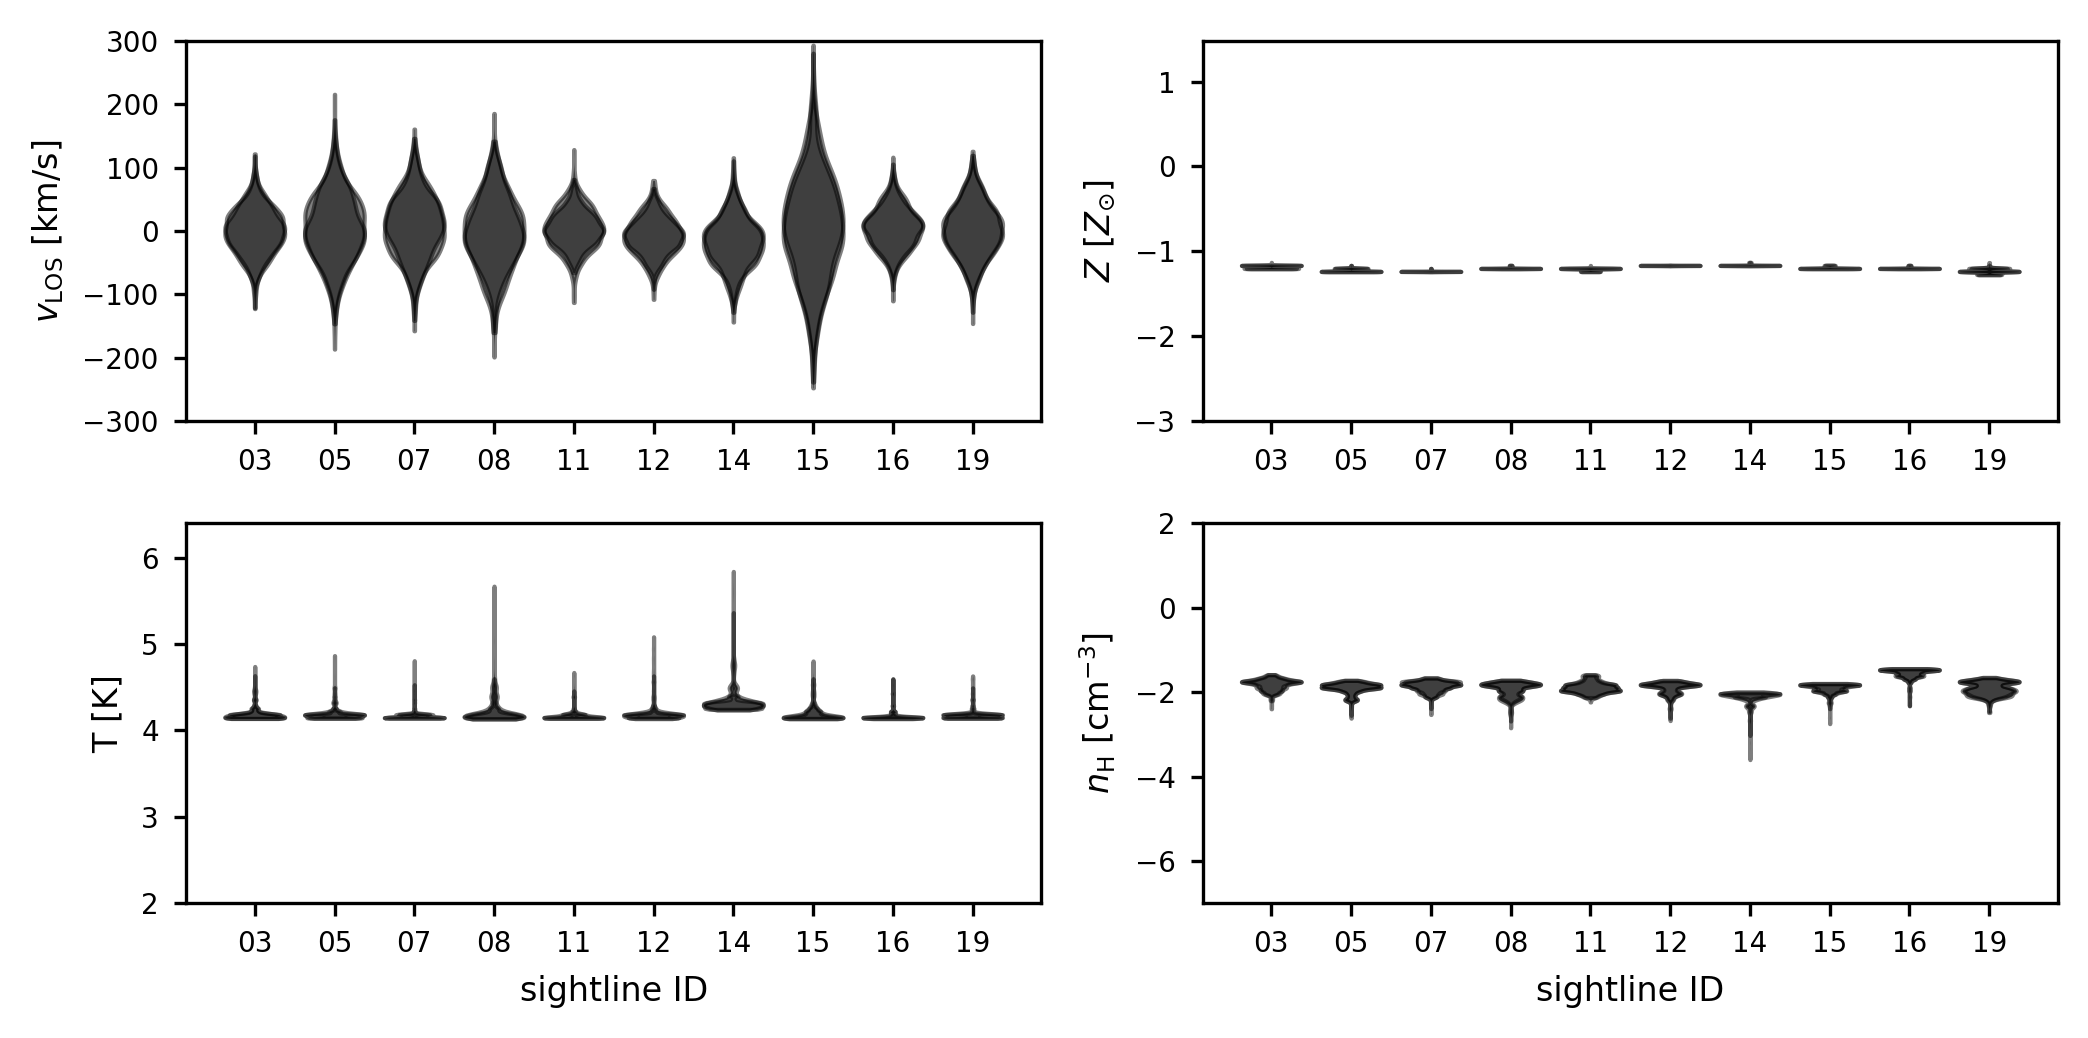

In [23]:
def get_source( variation, sl, prop_key ):
    
    pm = pms[variation]
    
    centers = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['distributions'][prop_key] )
    
    return centers, dist

fig, main_ax, ax_dict = plot_violin( get_source, pms, color='k', use_helper_colors=False )

As expected, no significant differences between the source distribution between revisions.

### Separated ( Source Violins, Estimated Violins )

#### Linear

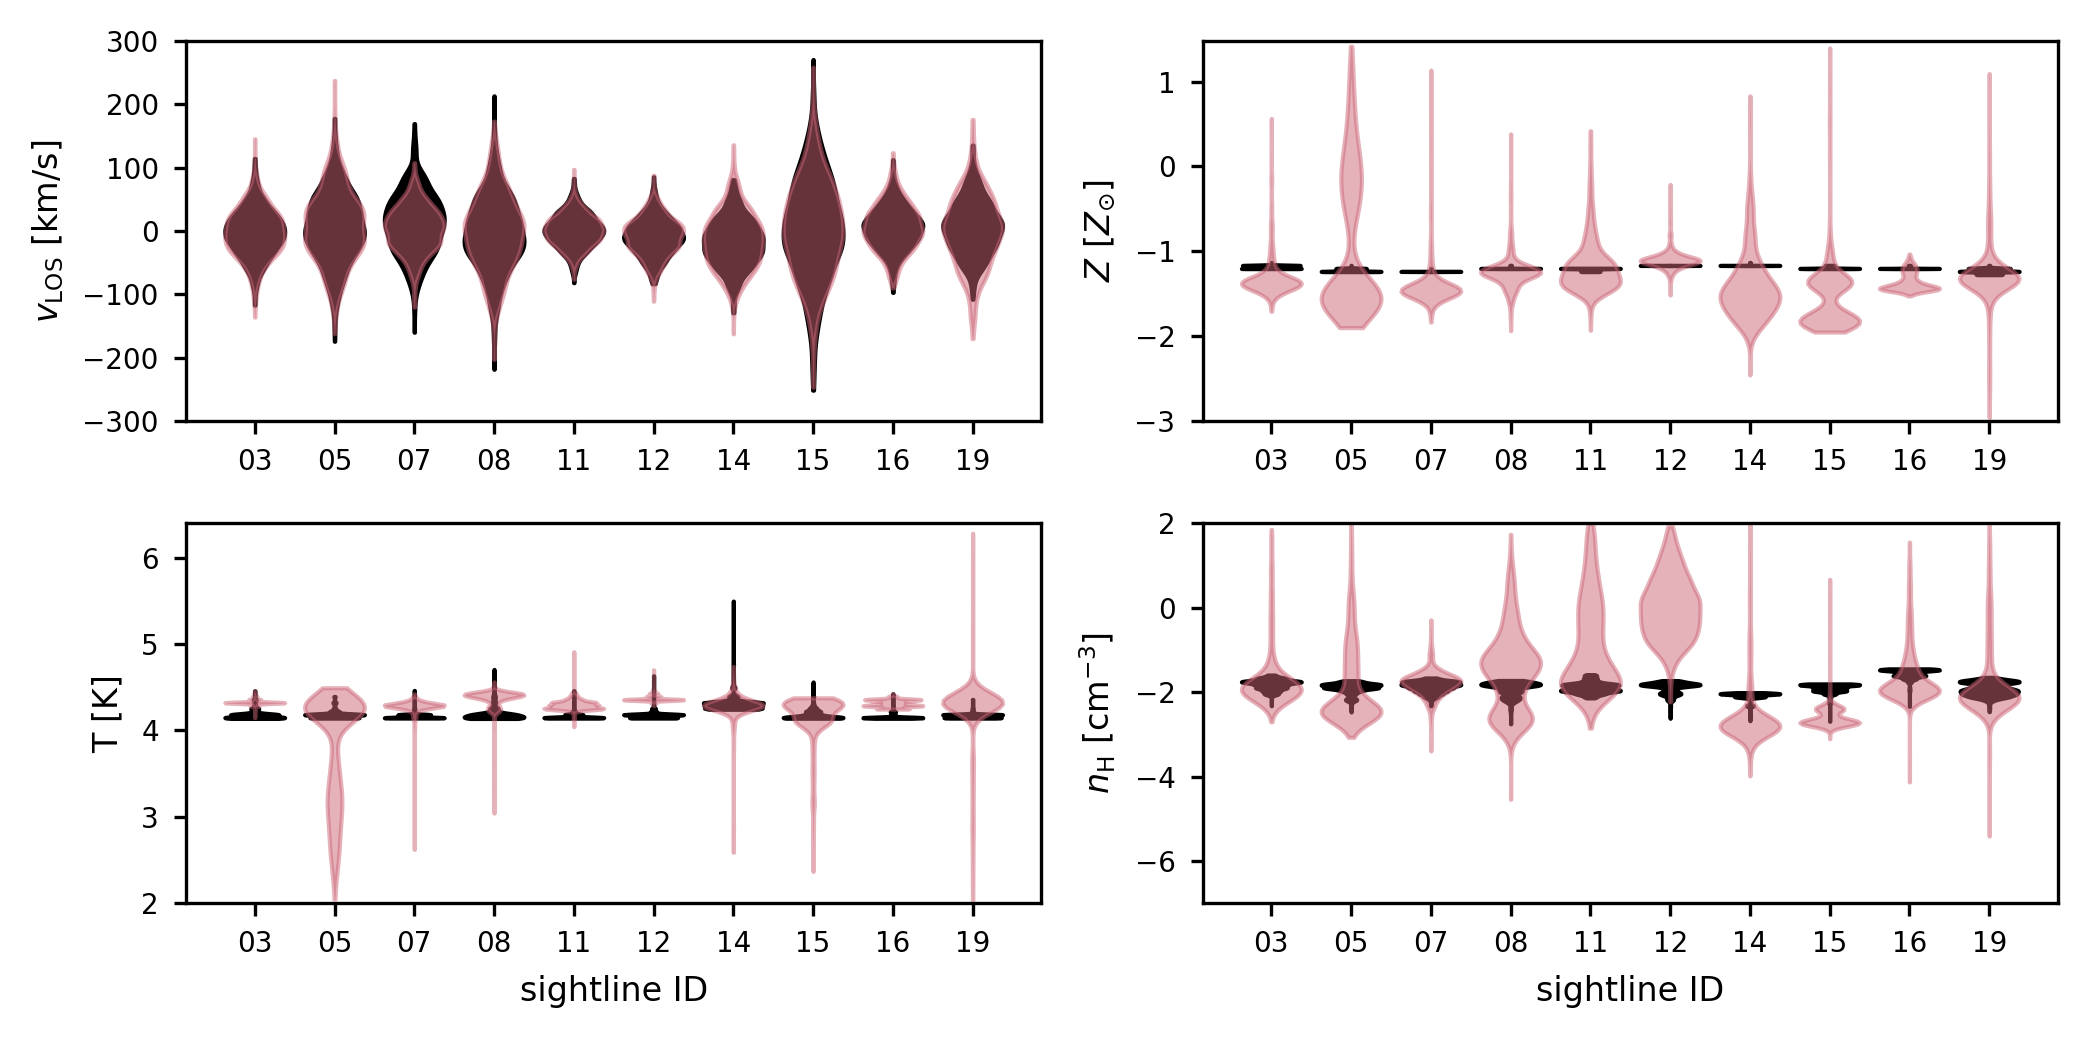

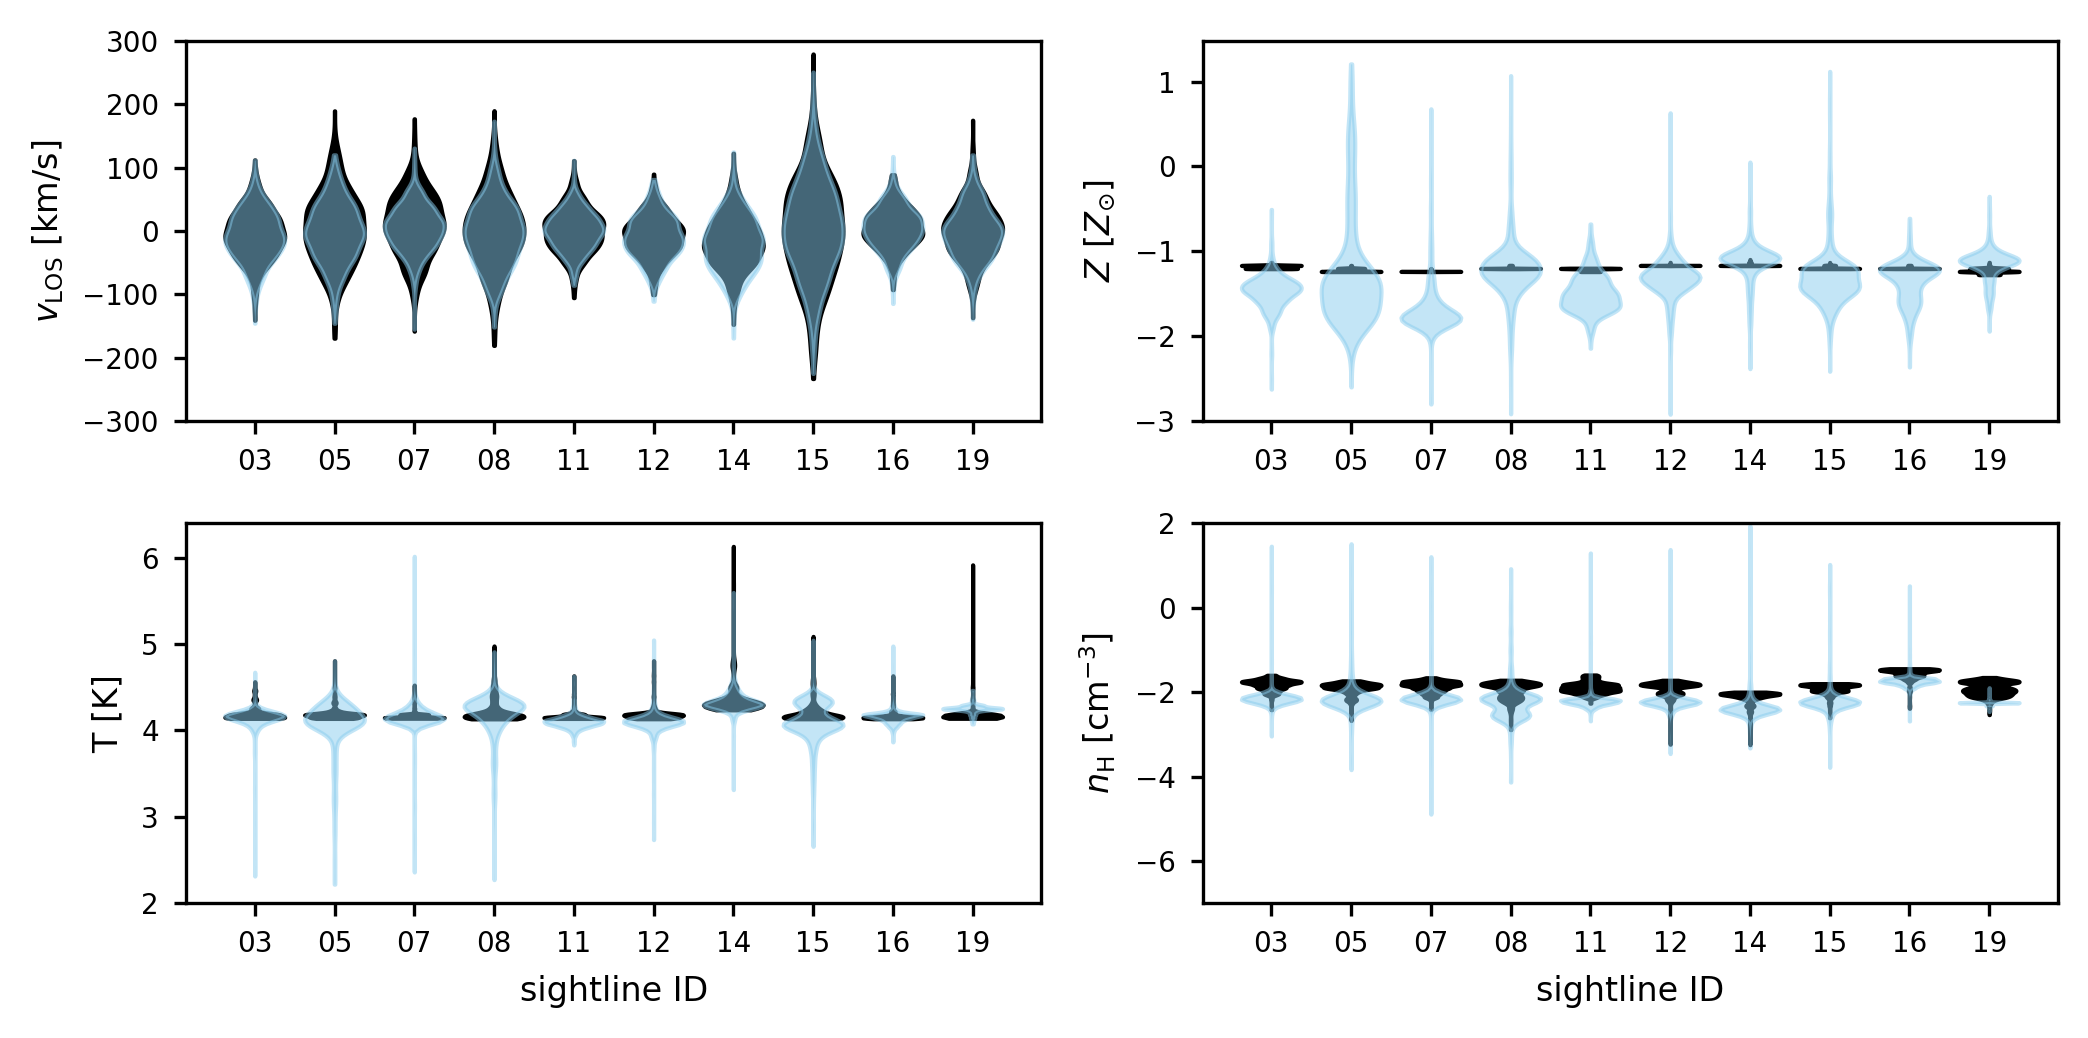

In [24]:
for variation, pm in pms.items():

    def get_source( variation, sl, prop_key ):

        pm = pms[variation]

        centers = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['centers'][prop_key] )
        dist = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['distributions'][prop_key] )

        return centers, dist

    def get_estimate( variation, sl, prop_key ):

        centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key] )
        dist = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key] )

        return centers, dist

    fig_tuple = plot_violin( get_source, { variation: pm }, color='k', use_helper_colors=False, alpha=1 )

    fig_tuple = plot_violin( get_estimate, { variation: pm }, fig_tuple=fig_tuple )
    
    fig_tuple[0]

#### Logscale

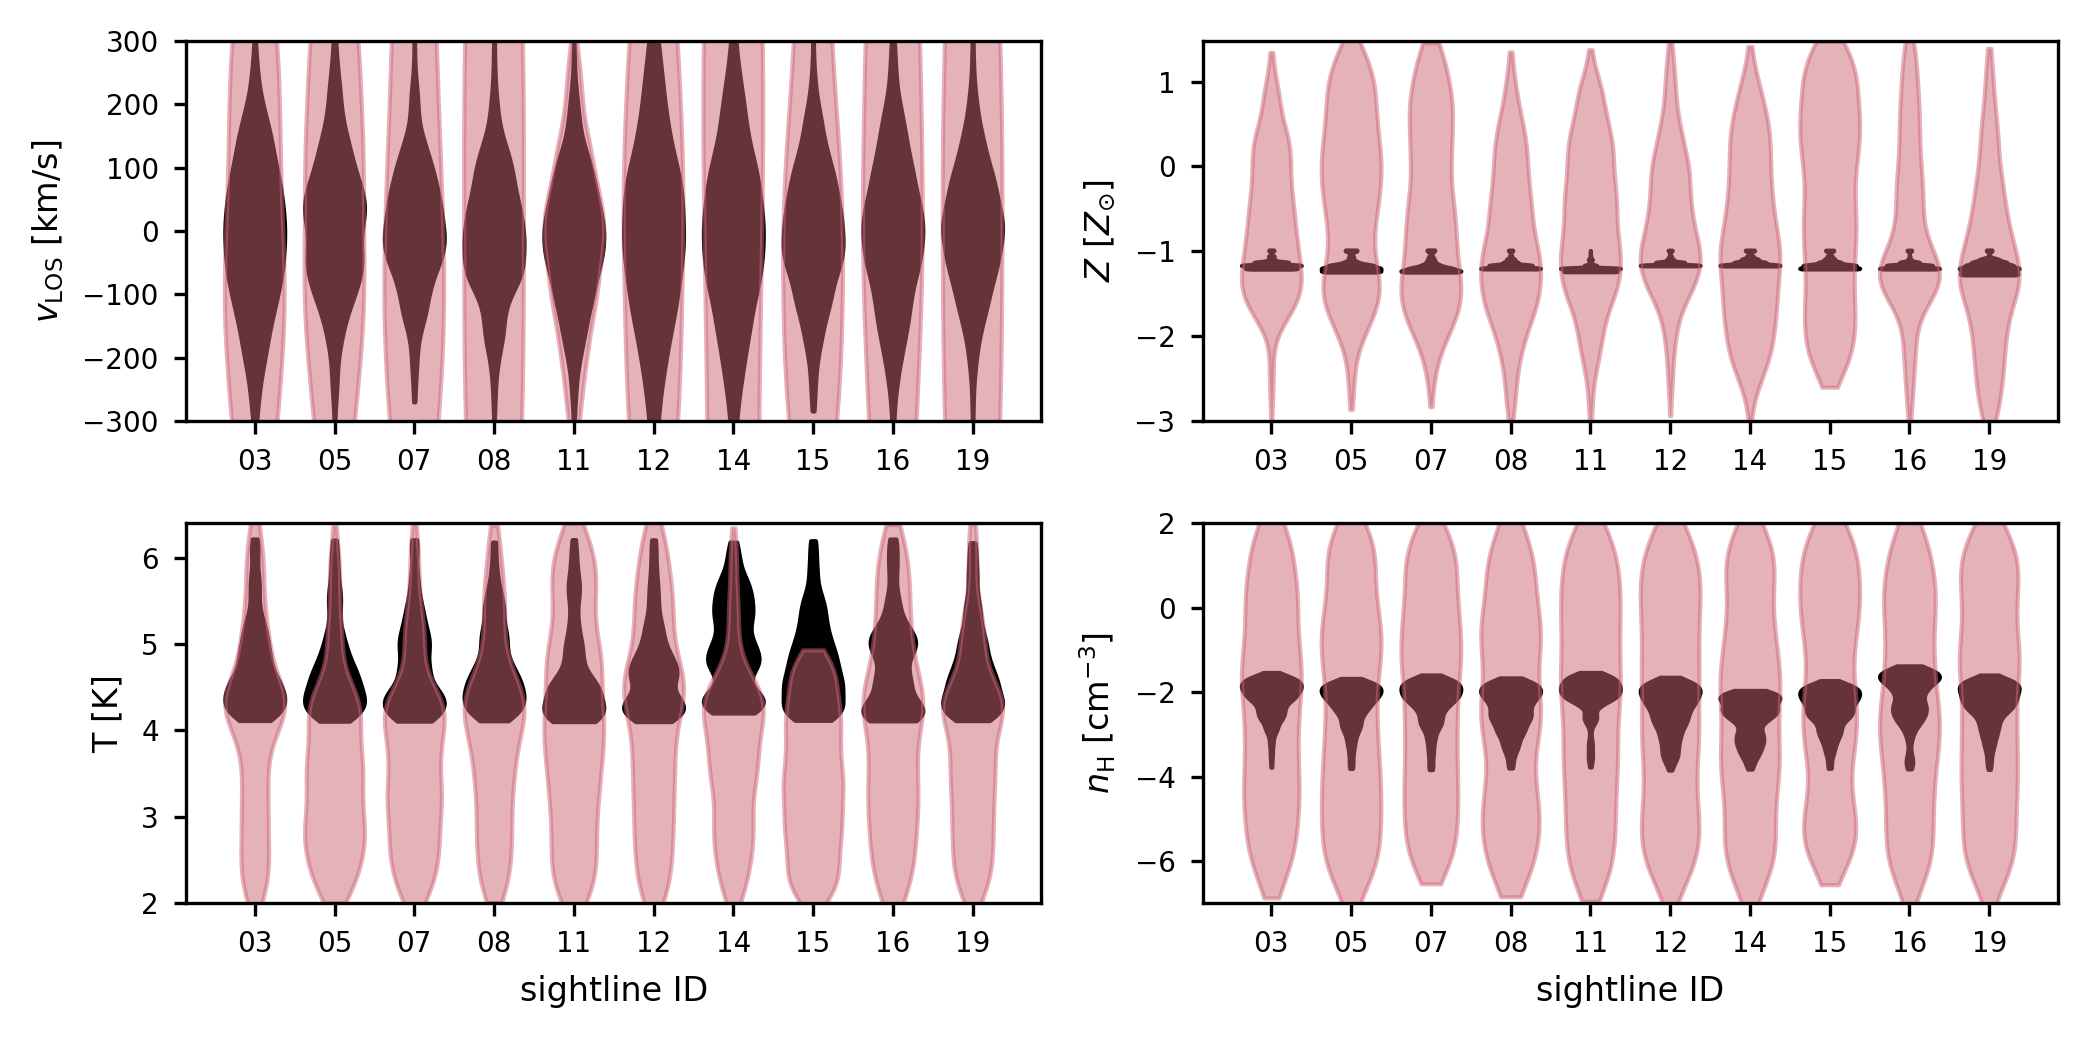

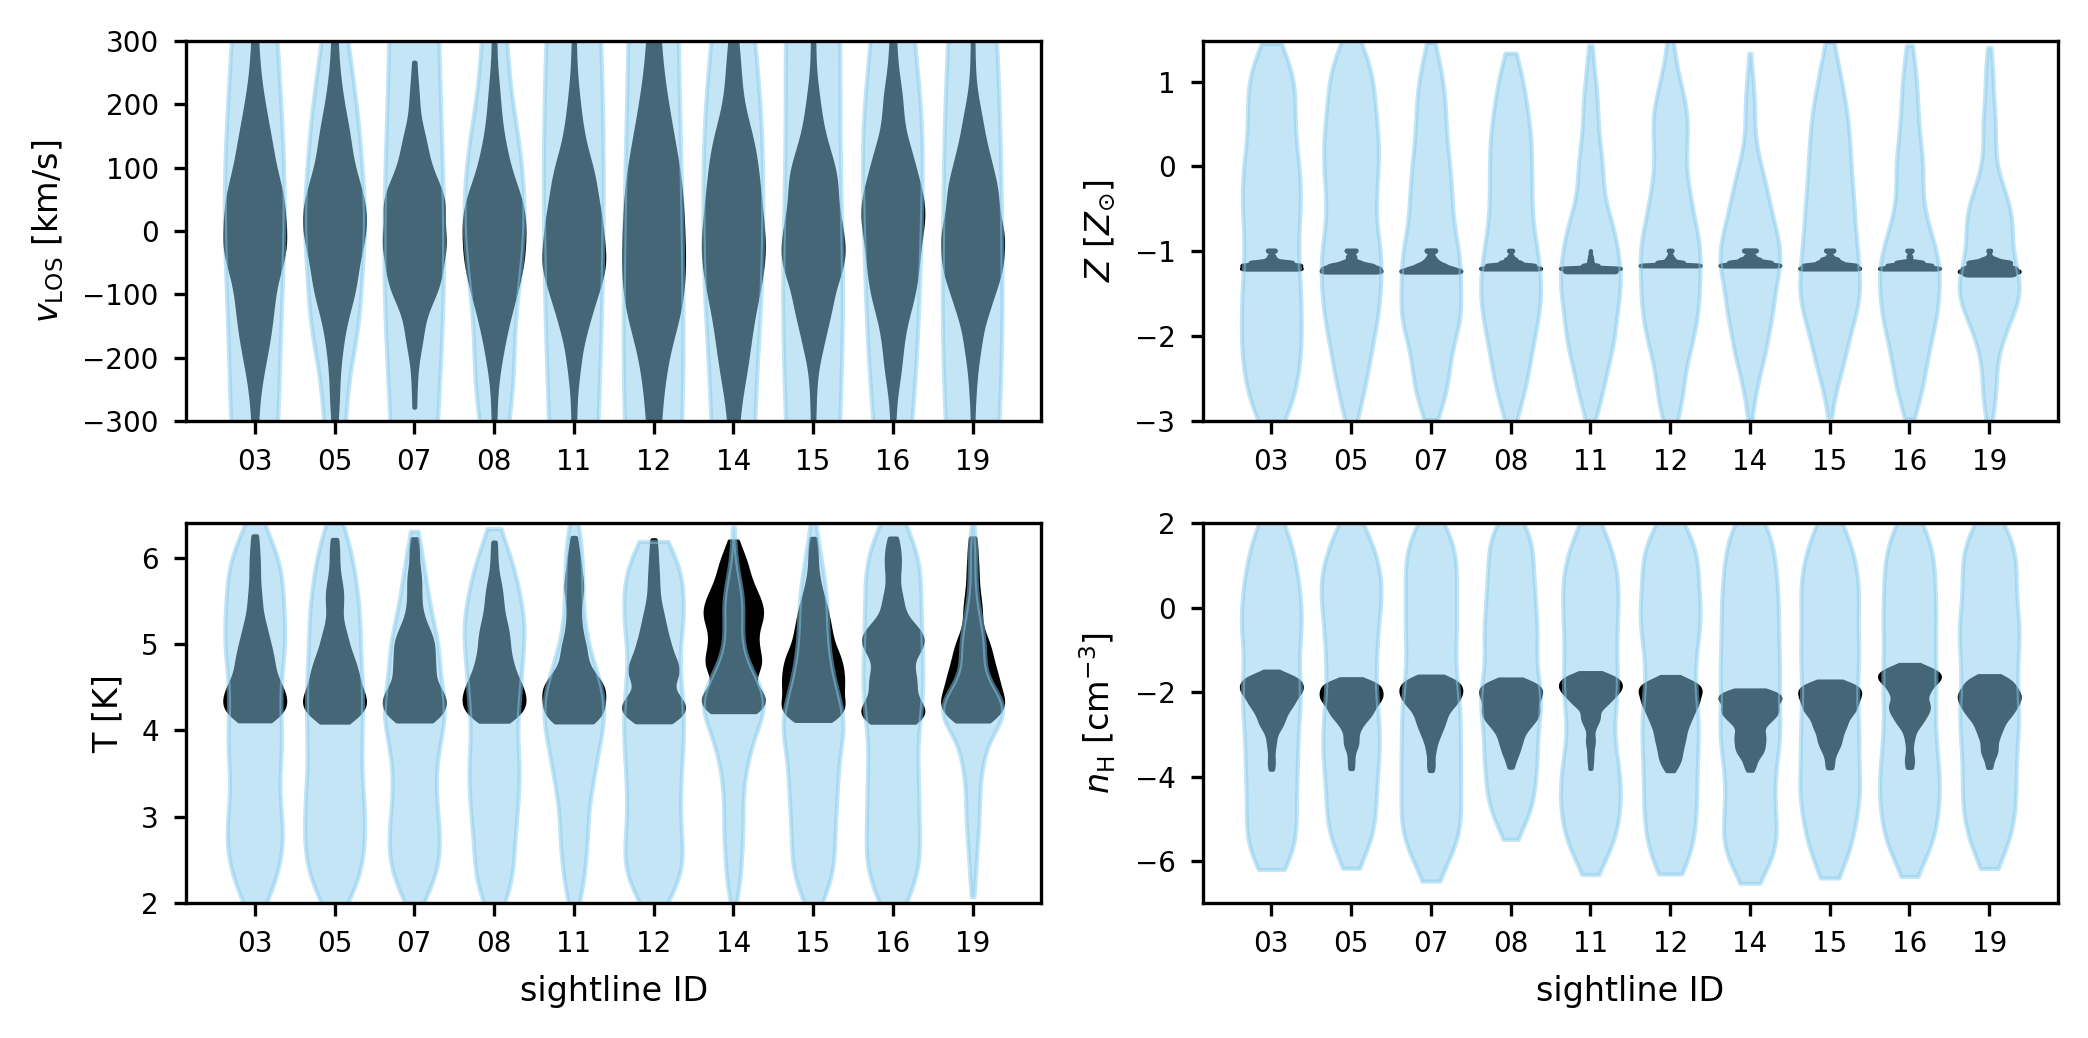

In [25]:
for variation, pm in pms.items():

    def get_source( variation, sl, prop_key ):

        pm = pms[variation]

        centers = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['centers'][prop_key] )
        dist = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['distributions'][prop_key] )

        return centers, dist

    def get_estimate( variation, sl, prop_key ):

        centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key] )
        dist = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key] )

        return centers, dist

    fig_tuple = plot_violin( get_source, { variation: pm }, color='k', use_helper_colors=False, alpha=1, logscale_distributions=True )

    fig_tuple = plot_violin( get_estimate, { variation: pm }, fig_tuple=fig_tuple, logscale_distributions=True )
    
    fig_tuple[0]

### Source Violin, Estimated Violin

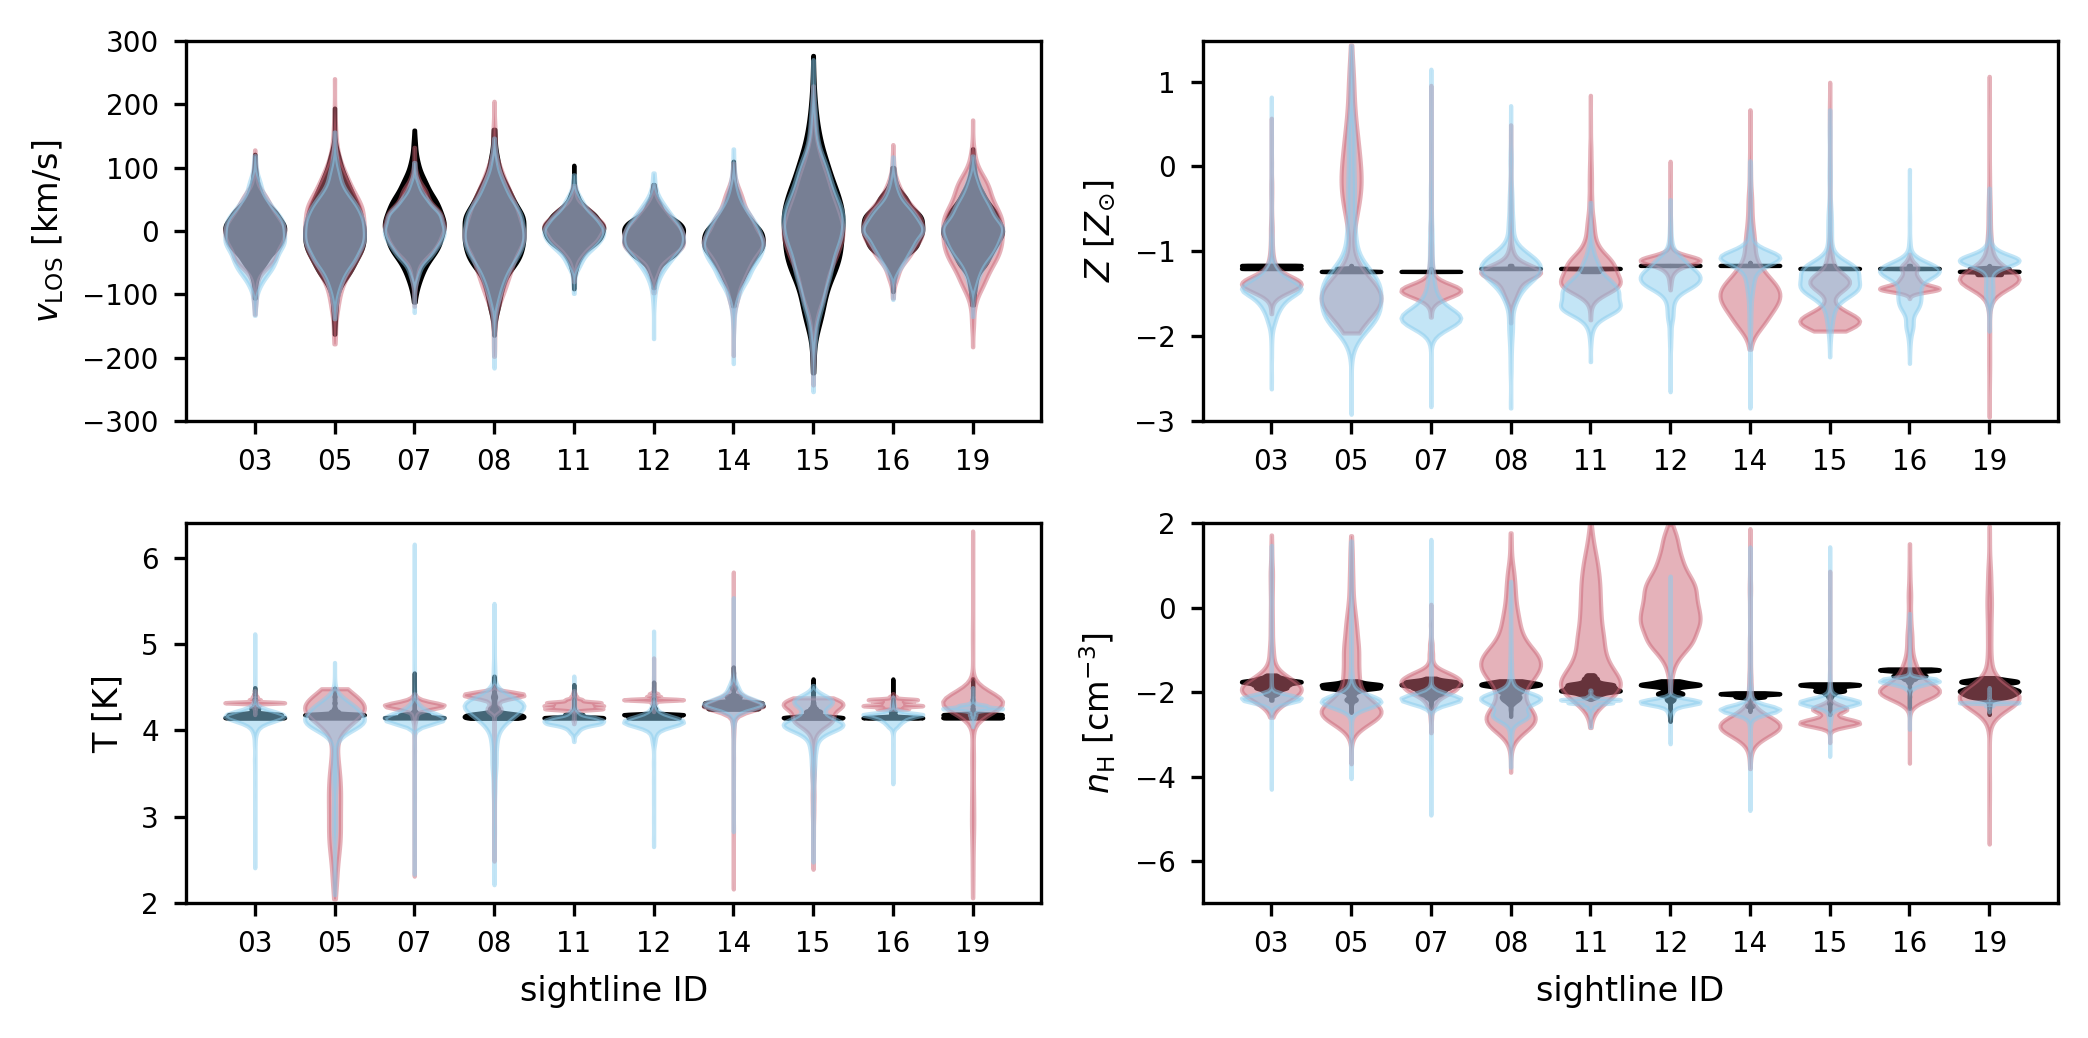

In [26]:
def get_source( variation, sl, prop_key ):
    
    if variation != 'original':
        return None, None

    pm = pms[variation]

    centers = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['distributions'][prop_key] )

    return centers, dist

def get_estimate( variation, sl, prop_key ):
    
    pm = pms[variation]

    centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key] )

    return centers, dist

fig_tuple = plot_violin( get_source, pms, color='k', use_helper_colors=False, alpha=1 )

fig_tuple = plot_violin( get_estimate, pms, fig_tuple=fig_tuple )

save_fp = os.path.join( pm['figure_dir'], 'violin.pdf' )
plt.savefig( save_fp )

### Source Violin, Estimated Points

#### Scaled alpha

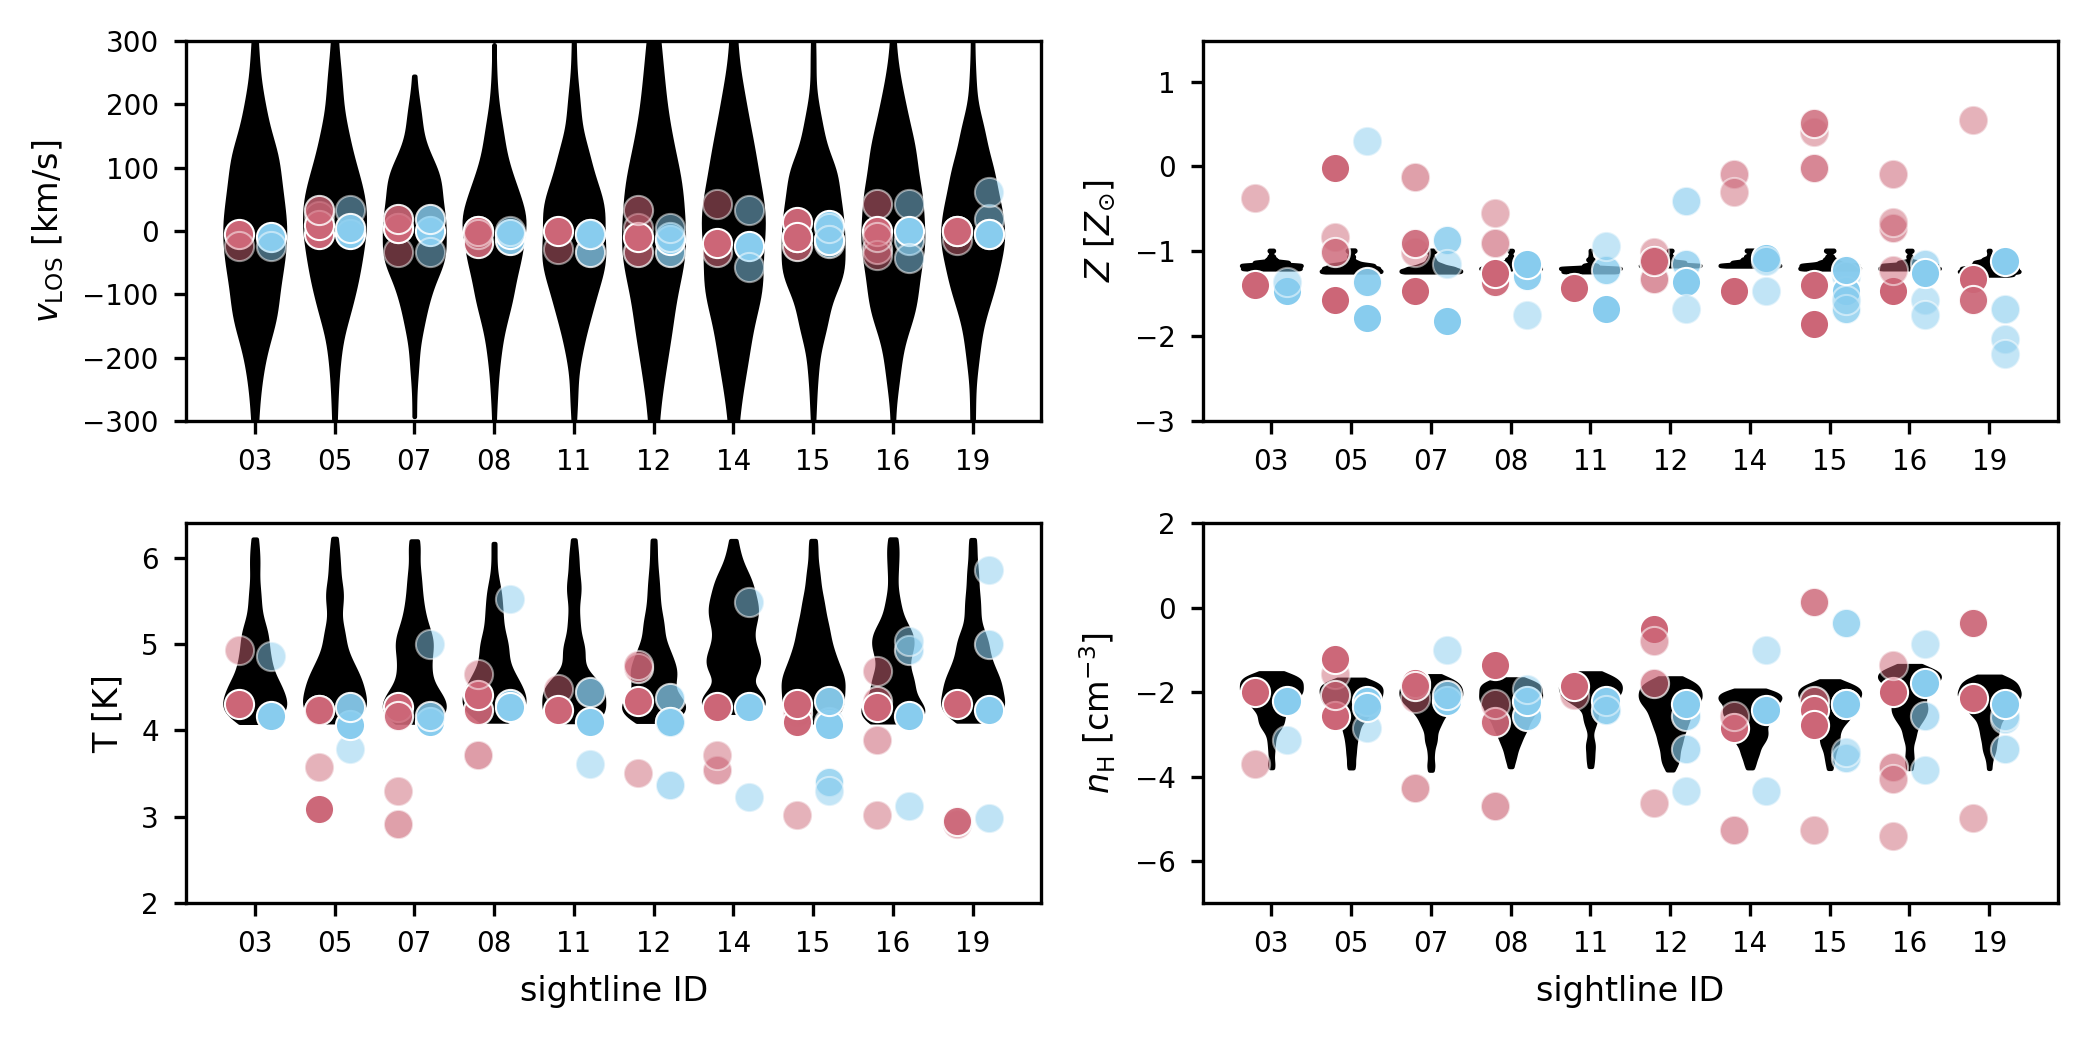

In [27]:
def get_source( variation, sl, prop_key ):
    
    if variation != 'original':
        return None, None

    pm = pms[variation]

    centers = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['distributions'][prop_key] )

    return centers, dist

fig, main_ax, ax_dict = plot_violin( get_source, pms, color='k', use_helper_colors=False, alpha=1, logscale_distributions=True, )

# Plot individual components
for ax_key, ax in ax_dict.items():
    for variation, pm in pms.items():
        for i, sl in enumerate( sls ):
        
            components = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['individual distributions']
            centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][ax_key] )
            
            if helpers.logscale[ax_key]:
                centers = np.log10( centers )
                
            # Get alpha values for components.
            # Logscaled, with a minimum alpha set immediately below
            alpha_min = 0.5
            norms = components.transpose().sum()[prop_key]
            alphas = norms.apply( matplotlib.colors.LogNorm( norms.keymin()[1], norms.keymax()[1] ) )
            alphas = alphas * ( 1. - alpha_min ) + alpha_min
            
            for comp_key, comp in components.items():
                
                mle = centers[comp[ax_key].argmax()]
                
                ax.scatter(
                    xs[i] + variation_plotting_params[variation]['offset'] * ( xs[1] - xs[0] ),
                    mle,
                    color = helpers.colors_for_variations[variation],
                    edgecolor = 'w',
                    linewidth = 0.5,
                    alpha = alphas[comp_key],
                )


save_fp = os.path.join( pm['figure_dir'], 'violin_vs_components.pdf' )
plt.savefig( save_fp )

#### Scaled length

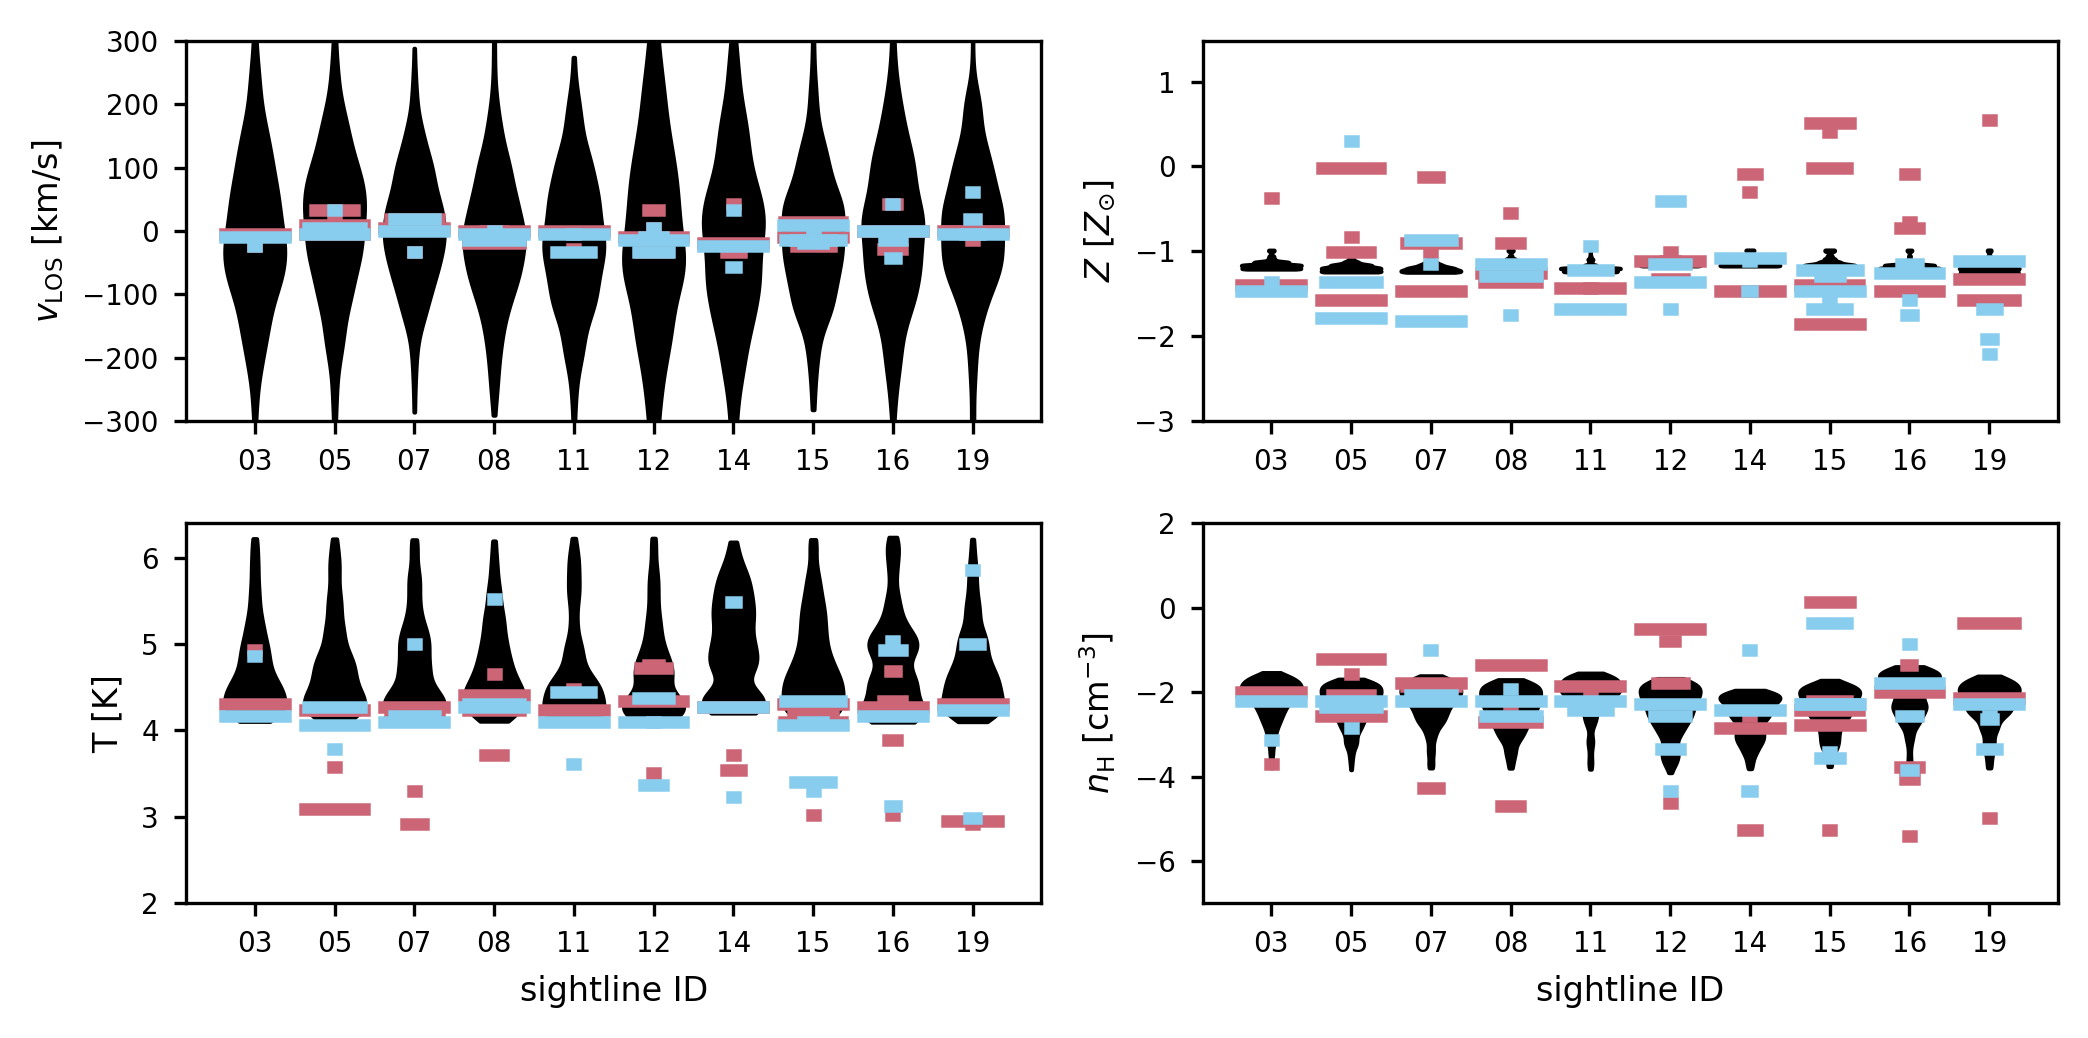

In [28]:
def get_source( variation, sl, prop_key ):
    
    if variation != 'original':
        return None, None

    pm = pms[variation]

    centers = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['centers'][prop_key] )
    dist = copy.copy( absorption_properties[pm['public_label']][sl]['data']['1D distributions']['distributions'][prop_key] )

    return centers, dist

fig, main_ax, ax_dict = plot_violin( get_source, pms, color='k', use_helper_colors=False, alpha=1, logscale_distributions=True, )

# Plot individual components
for ax_key, ax in ax_dict.items():
    for variation, pm in pms.items():
        for i, sl in enumerate( sls ):
        
            components = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['individual distributions']
            centers = copy.copy( absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][ax_key] )
            
            if helpers.logscale[ax_key]:
                centers = np.log10( centers )
                
            # Scale lines by component size, with minimum length
            norms = components.transpose().sum()[prop_key]
            length_min = 0.05
            lengths = norms.apply( matplotlib.colors.LogNorm( norms.keymin()[1], norms.keymax()[1] ) )
            alpha_min = 0.5
            alphas = copy.deepcopy( lengths )
            alphas = alphas * ( 1 - alpha_min ) + alpha_min
            lengths = lengths * ( 1. - length_min ) + length_min
            lengths *= helpers.violin_width * ( xs[1] - xs[0] )
            
            for comp_key, comp in components.items():
                
                mle = centers[comp[ax_key].argmax()]
                
                ax.plot(
                    [ xs[i] - lengths[comp_key] / 2., xs[i] + lengths[comp_key] / 2. ],
                    [ mle, ] * 2,
                    color = helpers.colors_for_variations[variation],
                    linewidth = 3,
                    # alpha = alphas[comp_key],
                )

save_fp = os.path.join( pm['figure_dir'], 'violin_vs_components_alternate.pdf' )
plt.savefig( save_fp )

## Shape comparison
Fraction enclosed compared to fraction enclosed.

In [29]:
%%capture

f_estimated_to_enclose_f_data = verdict.Dict({})
f_data_enclosed_by_f_estimated = verdict.Dict({})
dist_comparison_figs = []
for i, sl in enumerate( sls ):

    # Setup figure
    fig = plt.figure()
    main_ax = plt.gca()
    main_ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
    for spine in main_ax.spines.values():
        spine.set_visible( False )

    ax_dict = fig.subplot_mosaic(
        mosaic_dist,
    )

    main_ax.set_xlabel( '% of likelihood distribution enclosed', labelpad=30 )
    main_ax.set_ylabel( '% of synthetic data enclosed', labelpad=30 )

    for ax_key, ax in ax_dict.items():
        ax.set_xlim( 0, 100 )
        ax.set_ylim( 0, 100 )

        ax.annotate(
            text = helpers.property_labels_no_units[ax_key],
            xy = ( 0, 1 ),
            xycoords = 'axes fraction',
            xytext = ( 5, -5 ),
            textcoords = 'offset points',
            va = 'top',
            ha = 'left',
        )
        
        ax.plot(
            [ 0, 100 ],
            [ 0, 100 ],
            color = '0.5',
            linewidth = 1.5,
            zorder = -110,
        )

    main_ax.set_title(
        label = sl,
        loc = 'right',
    )

    for variation, pm in pms.items():

        for prop_key in absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'].keys():

            # Get plot panel
            ax = ax_dict[prop_key]
            subplotspec = ax.get_subplotspec()

            # Get data distributions
            centers_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key]
            dist_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key]
            dist_data_sum = dist_data.sum()

            # Get modeled distributions
            centers_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key]
            bins_estimated = np.full( centers_estimated.shape, np.nan )
            bin_widths = np.diff( centers_estimated )
            bins_estimated[0:centers_estimated.size-1] = centers_estimated[:-1] - bin_widths / 2.
            bins_estimated[centers_estimated.size-1] = centers_estimated[-1] + bin_widths[-1] / 2.
            dist_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key]
            dist_estimated_sum = dist_estimated.sum()
            max_ind_estimated = dist_estimated.argmax()

            # Calculate fraction included arrays
            j = 0
            f_included_data = []
            f_included_estimated = []
            while True:

                # Get range to include
                left = max_ind_estimated - j
                right = max_ind_estimated + j + 1

                # Check if looping is done
                left_in_bounds = left >= 0
                right_in_bounds = right < centers_estimated.size
                continue_looping = left_in_bounds or right_in_bounds
                if not continue_looping:
                    break
                    
                if not left_in_bounds:
                    left = 0
                if not right_in_bounds:
                    right = centers_estimated.size - 1

                # Get fraction included
                x_value_left = bins_estimated[left]
                x_value_right = bins_estimated[right]
                is_in_range_data = ( centers_data > x_value_left ) & (centers_data < x_value_right )

                f_included_data.append( dist_data[is_in_range_data].sum() / dist_data_sum )
                f_included_estimated.append( dist_estimated[left:right].sum() / dist_estimated_sum )

                j += 1
            f_included_data = np.array( f_included_data )
            f_included_estimated = np.array( f_included_estimated )
            
            # Extract a summary statistic
            interp_data_estimated = scipy.interpolate.interp1d( f_included_data, f_included_estimated )
            interp_estimated_data = scipy.interpolate.interp1d( f_included_estimated, f_included_data )
            for fraction in pm['f_enclosed']:
                
                ## Fraction needed to enclose
                try:
                    f_to_enclose = interp_data_estimated( fraction )
                    
                    # If a value of 1 is needed, then the distribution doesn't actually enclose the data.
                    if np.isclose( f_to_enclose, 1. ):
                        f_to_enclose = np.nan
                # If above or below the interpolation range
                except ValueError:
                    # If below, that means the fraction was reached with the first cell
                    if fraction <= f_included_data[0]:
                        f_to_enclose = f_included_estimated[0]
                    # If above, then invalid
                    elif fraction >= f_included_data[-1]:
                        f_to_enclose = np.nan
                f_estimated_to_enclose_f_data.setitem( pm['public_label'], f_to_enclose, prop_key, str( fraction ), sl )
                
                ## Fraction enclosed by a fixed value
                try:
                    f_data_enclosed = interp_estimated_data( fraction )
                # If above or below the interpolation range
                except ValueError:
                    # If below the interpolation range, then f_estimated jumps sharply early, so the enclosed amount is just the first entry in f_included_data
                    if fraction < f_included_estimated[0]:
                        f_data_enclosed = f_included_data[0]
                    # If above the interpolation range, then invalid
                    if fraction >= f_included_estimated[-1]:
                        f_data_enclosed = np.nan
                f_data_enclosed_by_f_estimated.setitem( pm['public_label'], f_data_enclosed, prop_key, str( fraction ), sl )

            ax.plot(
                f_included_estimated * 100,
                f_included_data * 100,
                color = helpers.colors_for_variations[pm['variation']],
            )
            
    dist_comparison_figs.append( fig )

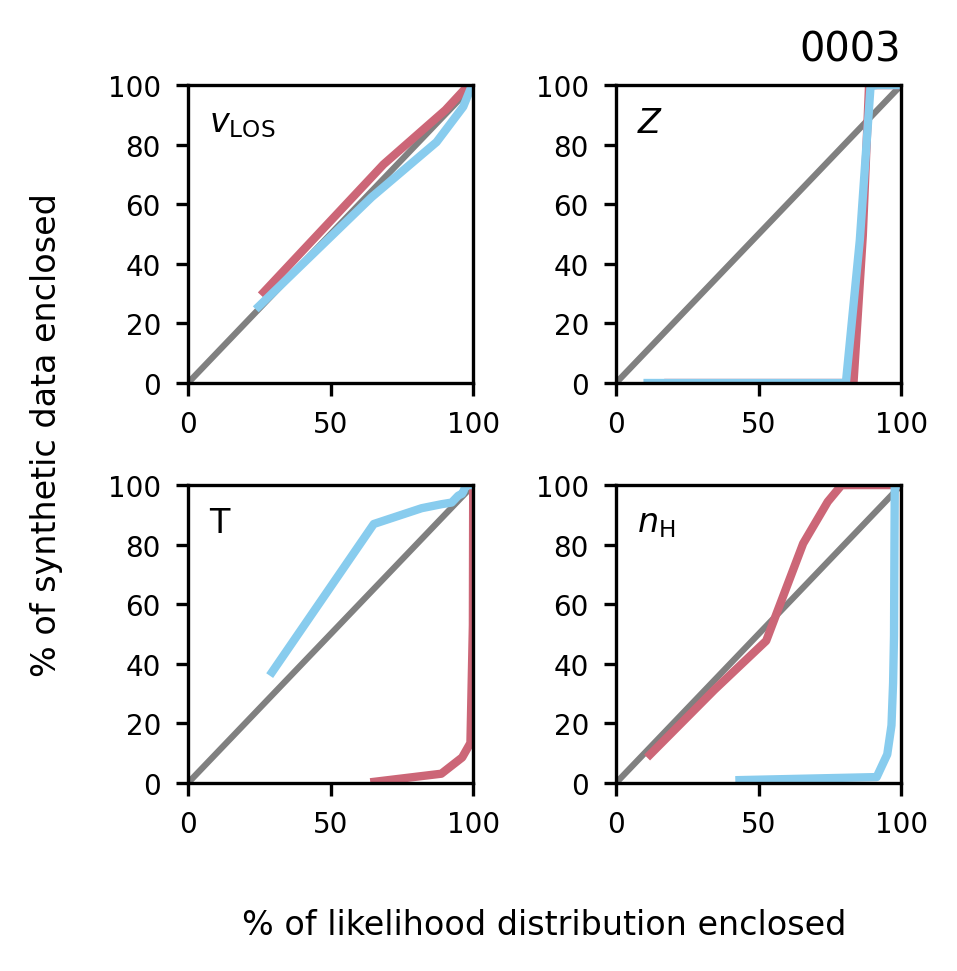

In [30]:
dist_comparison_figs[0]

# Metrics

## Calculate

In [31]:
averages = verdict.Dict({})
distances_between = verdict.Dict({})
percentiles = verdict.Dict({})
for i, sl in enumerate( sls ):

    for prop_key in absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'].keys():

        # Get plot panel
        ax = ax_dict[prop_key]
        subplotspec = ax.get_subplotspec()

        for fraction in pm['f_enclosed']:
            
            for variation, pm in pms.items():
                
                # Get data distributions
                centers_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['centers'][prop_key]
                if helpers.logscale[prop_key]:
                    centers_data = np.log10( centers_data )
                dist_data = absorption_properties[pm['public_label']][sl]['source']['1D distributions']['distributions'][prop_key]
                dist_data_sum = dist_data.sum()
                cdf_data = np.cumsum( dist_data ) / dist_data_sum
                interp_data = scipy.interpolate.interp1d( cdf_data, centers_data )

                # Calculate data average
                avg_data = interp_data( 0.5 )
                averages.setitem( pm['public_label'], avg_data, 'source', prop_key, sl )

               # Calculate data percentiles
                interval_data = np.array([ interp_data( fraction / 2. ), interp_data( 1. - fraction / 2. ) ])
                width_data = interval_data[1] - interval_data[0]
                percentiles.setitem( pm['public_label'], interval_data, 'source', prop_key, str( fraction ), 'interval', sl )
                percentiles.setitem( pm['public_label'], width_data, 'source', prop_key, str( fraction ), 'width', sl )


                # Get modeled distributions
                centers_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['centers'][prop_key]
                if helpers.logscale[prop_key]:
                    centers_estimated = np.log10( centers_estimated )
                dist_estimated = absorption_properties[pm['public_label']][sl]['estimated']['1D distributions']['combined distributions'][prop_key]
                dist_estimated_sum = dist_estimated.sum()
                cdf_estimated = np.cumsum( dist_estimated ) / dist_estimated_sum
                interp_estimated = scipy.interpolate.interp1d( cdf_estimated, centers_estimated )
                
                # Calculate MLE and averages
                x_max = centers_estimated[np.argmax( dist_estimated )]
                x_avg = interp_estimated( 0.5 )
                averages.setitem( pm['public_label'], x_max, 'estimated', 'MLE', prop_key, sl )
                averages.setitem( pm['public_label'], x_avg, 'estimated', 'average', prop_key, sl )

                # Calculate parameter estimation percentiles
                alpha = 1 - fraction
                interval = np.array([ interp_estimated( alpha / 2. ), interp_estimated( 1. - alpha / 2. ) ])
                width = interval[1] - interval[0]
                percentiles.setitem( pm['public_label'], interval, 'estimated', prop_key, str( fraction ), 'interval', sl )
                percentiles.setitem( pm['public_label'], width, 'estimated', prop_key, str( fraction ), 'width', sl )

                # Calculate necessary width
                width_necessary = np.max( np.abs( interval_data - x_max ) )
                width_between_peaks = np.abs( avg_data - x_max )
                distances_between.setitem( pm['public_label'], width_necessary, prop_key, 'distance_to_enclose', str( fraction ), sl )
                distances_between.setitem( pm['public_label'], width_between_peaks, prop_key, 'distance_to_avg', sl )

## Plotting Setup

In [32]:
def plot_metric( get_ys, fig_tuple=None, **scatter_kwargs ):
    
    if fig_tuple is None:
        # Setup figure
        panel_width = plt.rcParams['figure.figsize'][0]
        n_rows = len( mosaic_dist )
        n_cols = len( mosaic_dist[0] )
        fig = plt.figure( figsize=(n_cols*panel_width, n_rows*panel_width), facecolor='w' )
        main_ax = plt.gca()
        main_ax.tick_params( left=False, labelleft=False, bottom=False, labelbottom=False )
        for spine in main_ax.spines.values():
            spine.set_visible( False )

        ax_dict = fig.subplot_mosaic(
            mosaic_dist,
            gridspec_kw = { 'hspace': 0.15, 'wspace': 0.12 },
        )
    else:
        fig, main_ax, ax_dict = fig_tuple
    
    # Axes tweaks
    for ax_key, ax in ax_dict.items():

        ax.set_xticks( xs )
        xtick_labels = [ _[-2:] for _ in sls ]
        ax.set_xticklabels( xtick_labels )
        
        # Axes tweaks
        axis_label = helpers.property_labels_no_units[ax_key]
        if helpers.logscale[ax_key]:
            axis_label = 'log' + axis_label

        ax.annotate(
            text = axis_label,
            xy = ( 0, 1 ),
            xycoords = 'axes fraction',
            xytext = ( 5, -5 ),
            textcoords = 'offset points',
            va = 'top',
            ha = 'left',
        )
        
    for variation, pm in pms.items():

        for ax_key, ax in ax_dict.items():
        
            ys = get_ys( variation=variation, prop_key=ax_key )
            if ys is None:
                continue
            
            color = helpers.colors_for_variations[pm['variation']]
            fill_color = color
            used_scatter_kwargs = dict(
                s = 100,
                edgecolor = color,
                color = fill_color,
            )
            used_scatter_kwargs.update( scatter_kwargs )

            scatter = ax.scatter(
                xs,
                ys,
                **used_scatter_kwargs
            )
    
    return fig, main_ax, ax_dict

## MLEs and Average Values

### Straight-up values

/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_18276/2929469987.py:60: UserWarning: You passed a edgecolor/edgecolors ((0.8, 0.4, 0.4666666666666667)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter = ax.scatter(


Text(0, 0.5, '$x_{\\rm MLE}$')

/Users/zhafen/miniconda3/envs/cgm_modeling_challenge/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/zhafen/miniconda3/envs/cgm_modeling_challenge/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


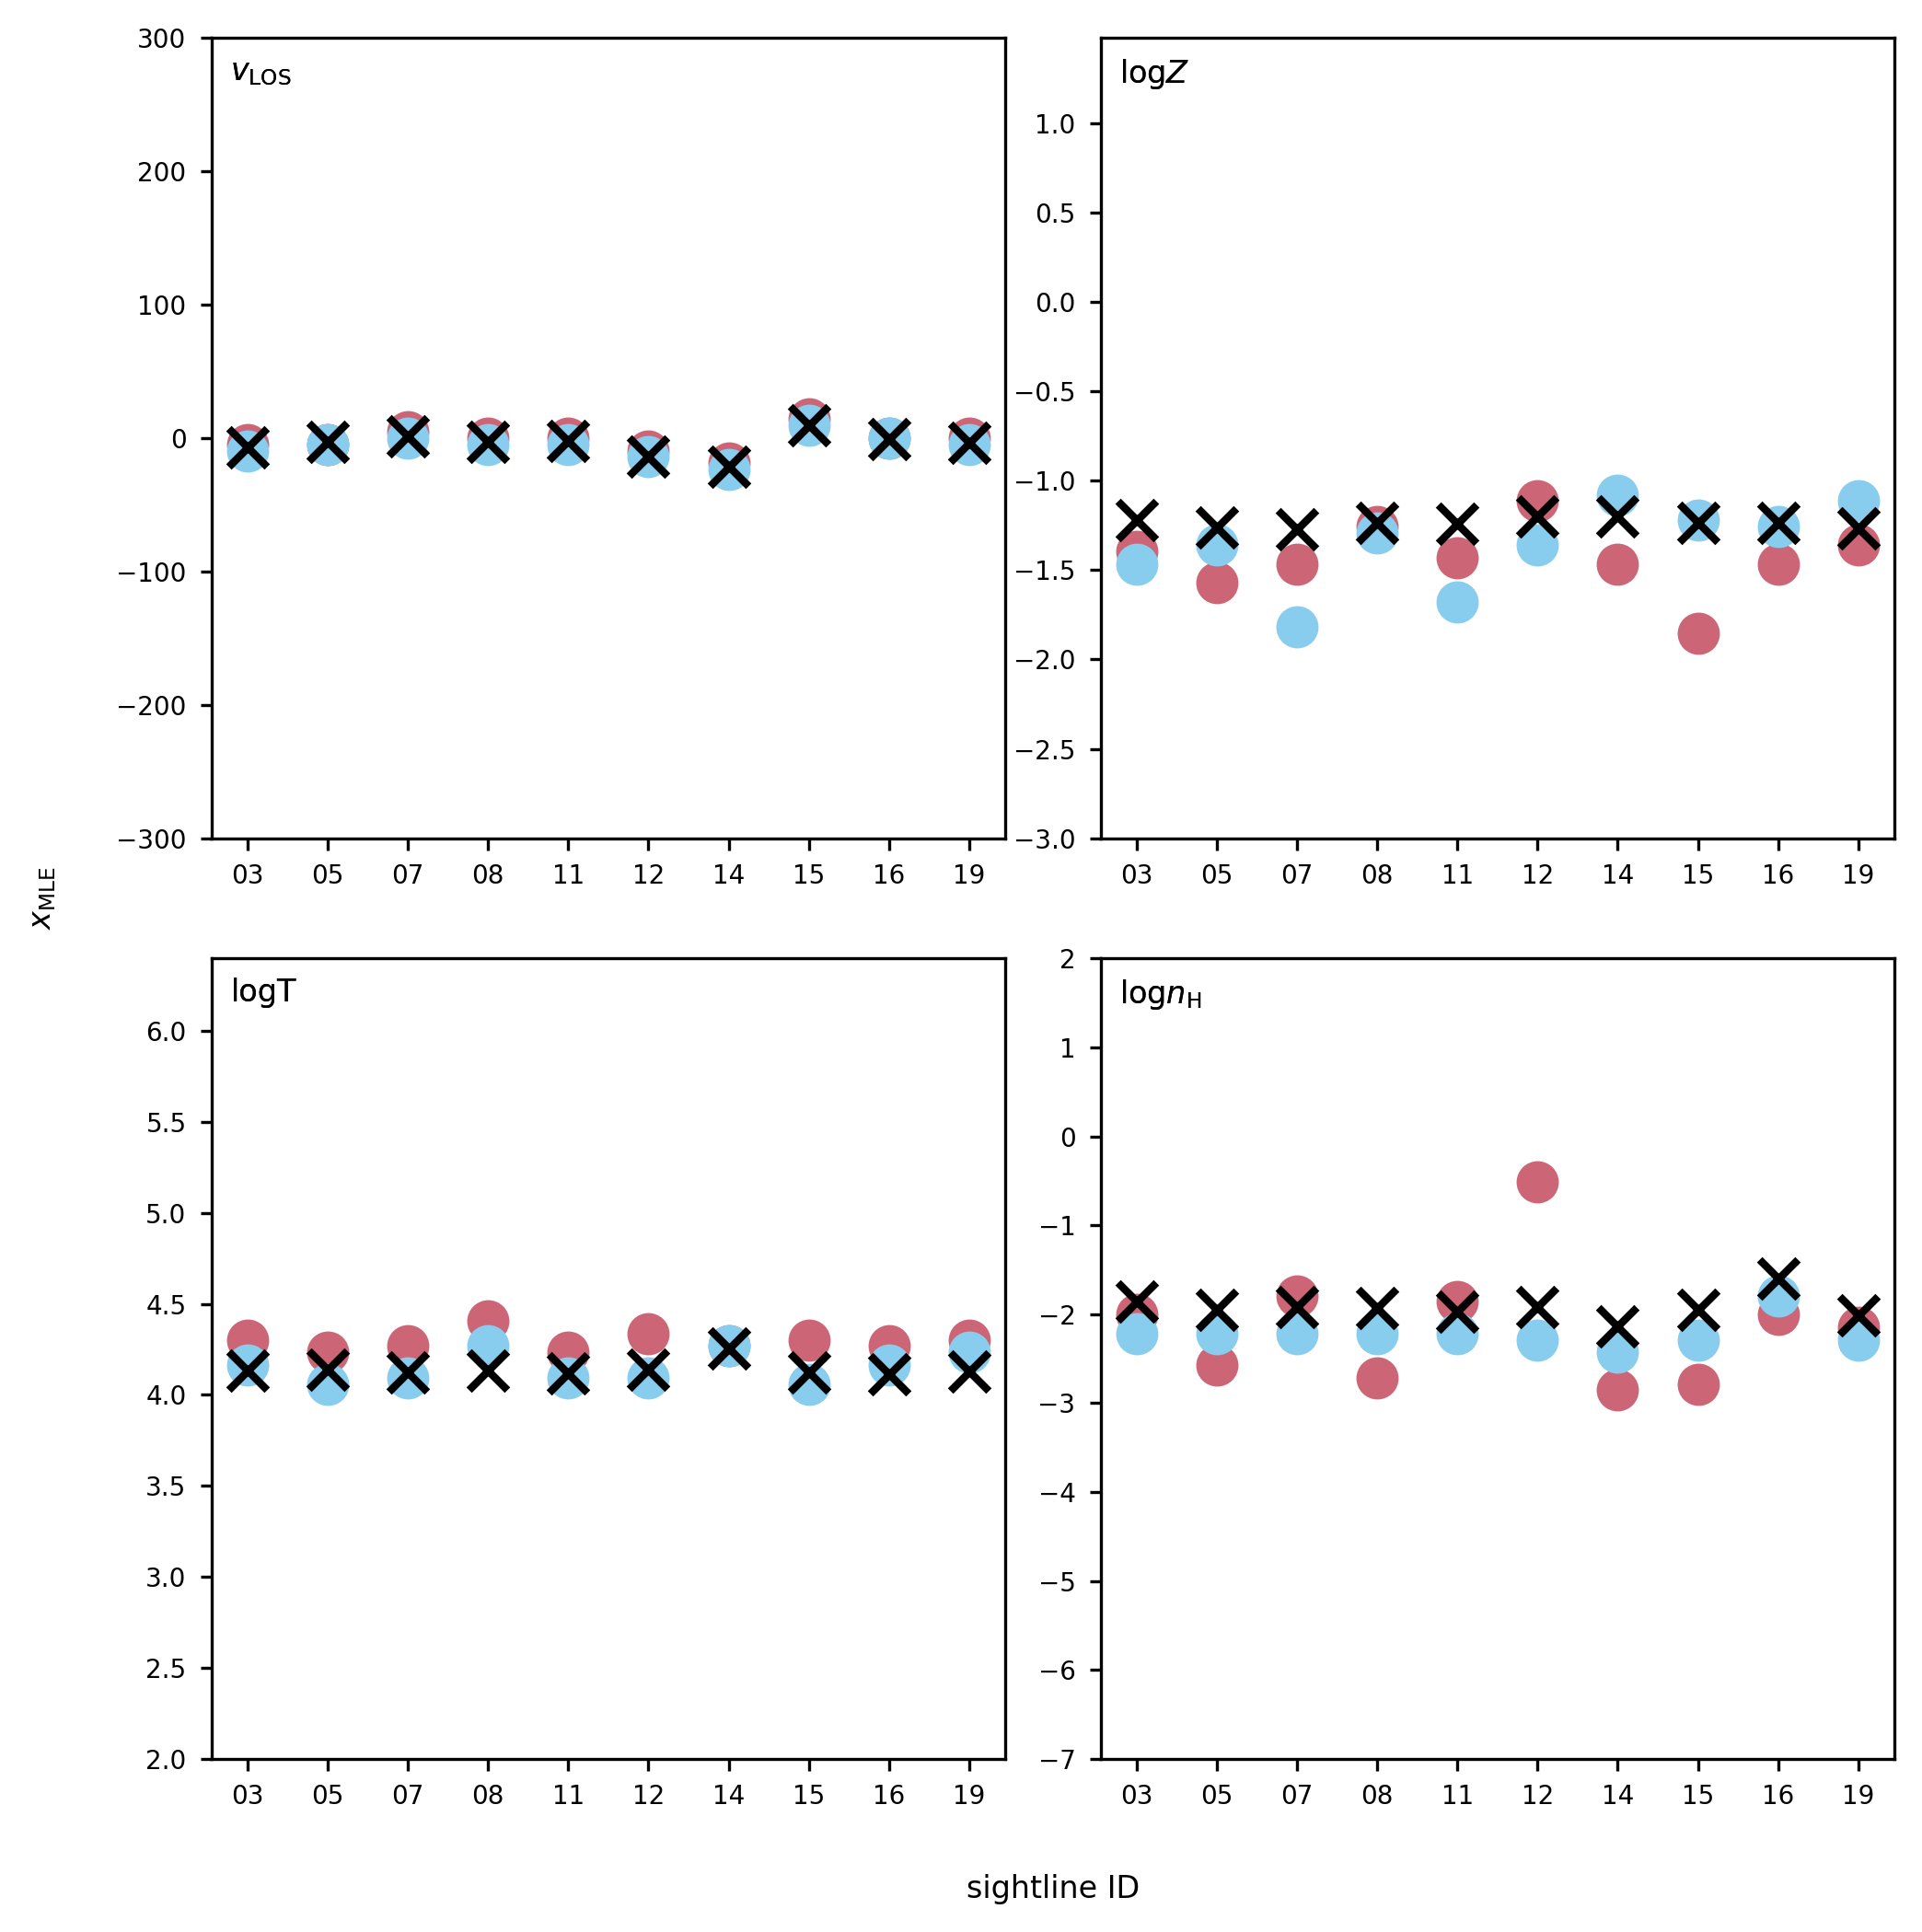

In [33]:
def get_estimated_ys( variation, prop_key ):

    pm = pms[variation]

    mle = averages[pm['public_label']]['estimated']['MLE'][prop_key].array()
    return mle

fig, main_ax, ax_dict = plot_metric( get_estimated_ys )

def get_source_ys( variation, prop_key ):
    
    if variation != 'original':
        return None

    pm = pms[variation]

    avg = averages[pm['public_label']]['source'][prop_key].array()
    return avg

fig, main_ax, ax_dict = plot_metric( get_source_ys, ( fig, main_ax, ax_dict ), marker='x', color='k', )

# Axes tweaks
for ax_key, ax in ax_dict.items():         
    ylims = helpers.lims[ax_key]
    if helpers.logscale[ax_key]:
        ylims = np.log10( ylims )

    ax.set_ylim( ylims )

main_ax.set_xlabel( 'sightline ID', labelpad=30 )
main_ax.set_ylabel( r'$x_{\rm MLE}$', labelpad=40 )

### Difference between values

Text(0, 0.5, '$\\left| x_{\\rm MLE} - \\langle x \\rangle \\right|$')

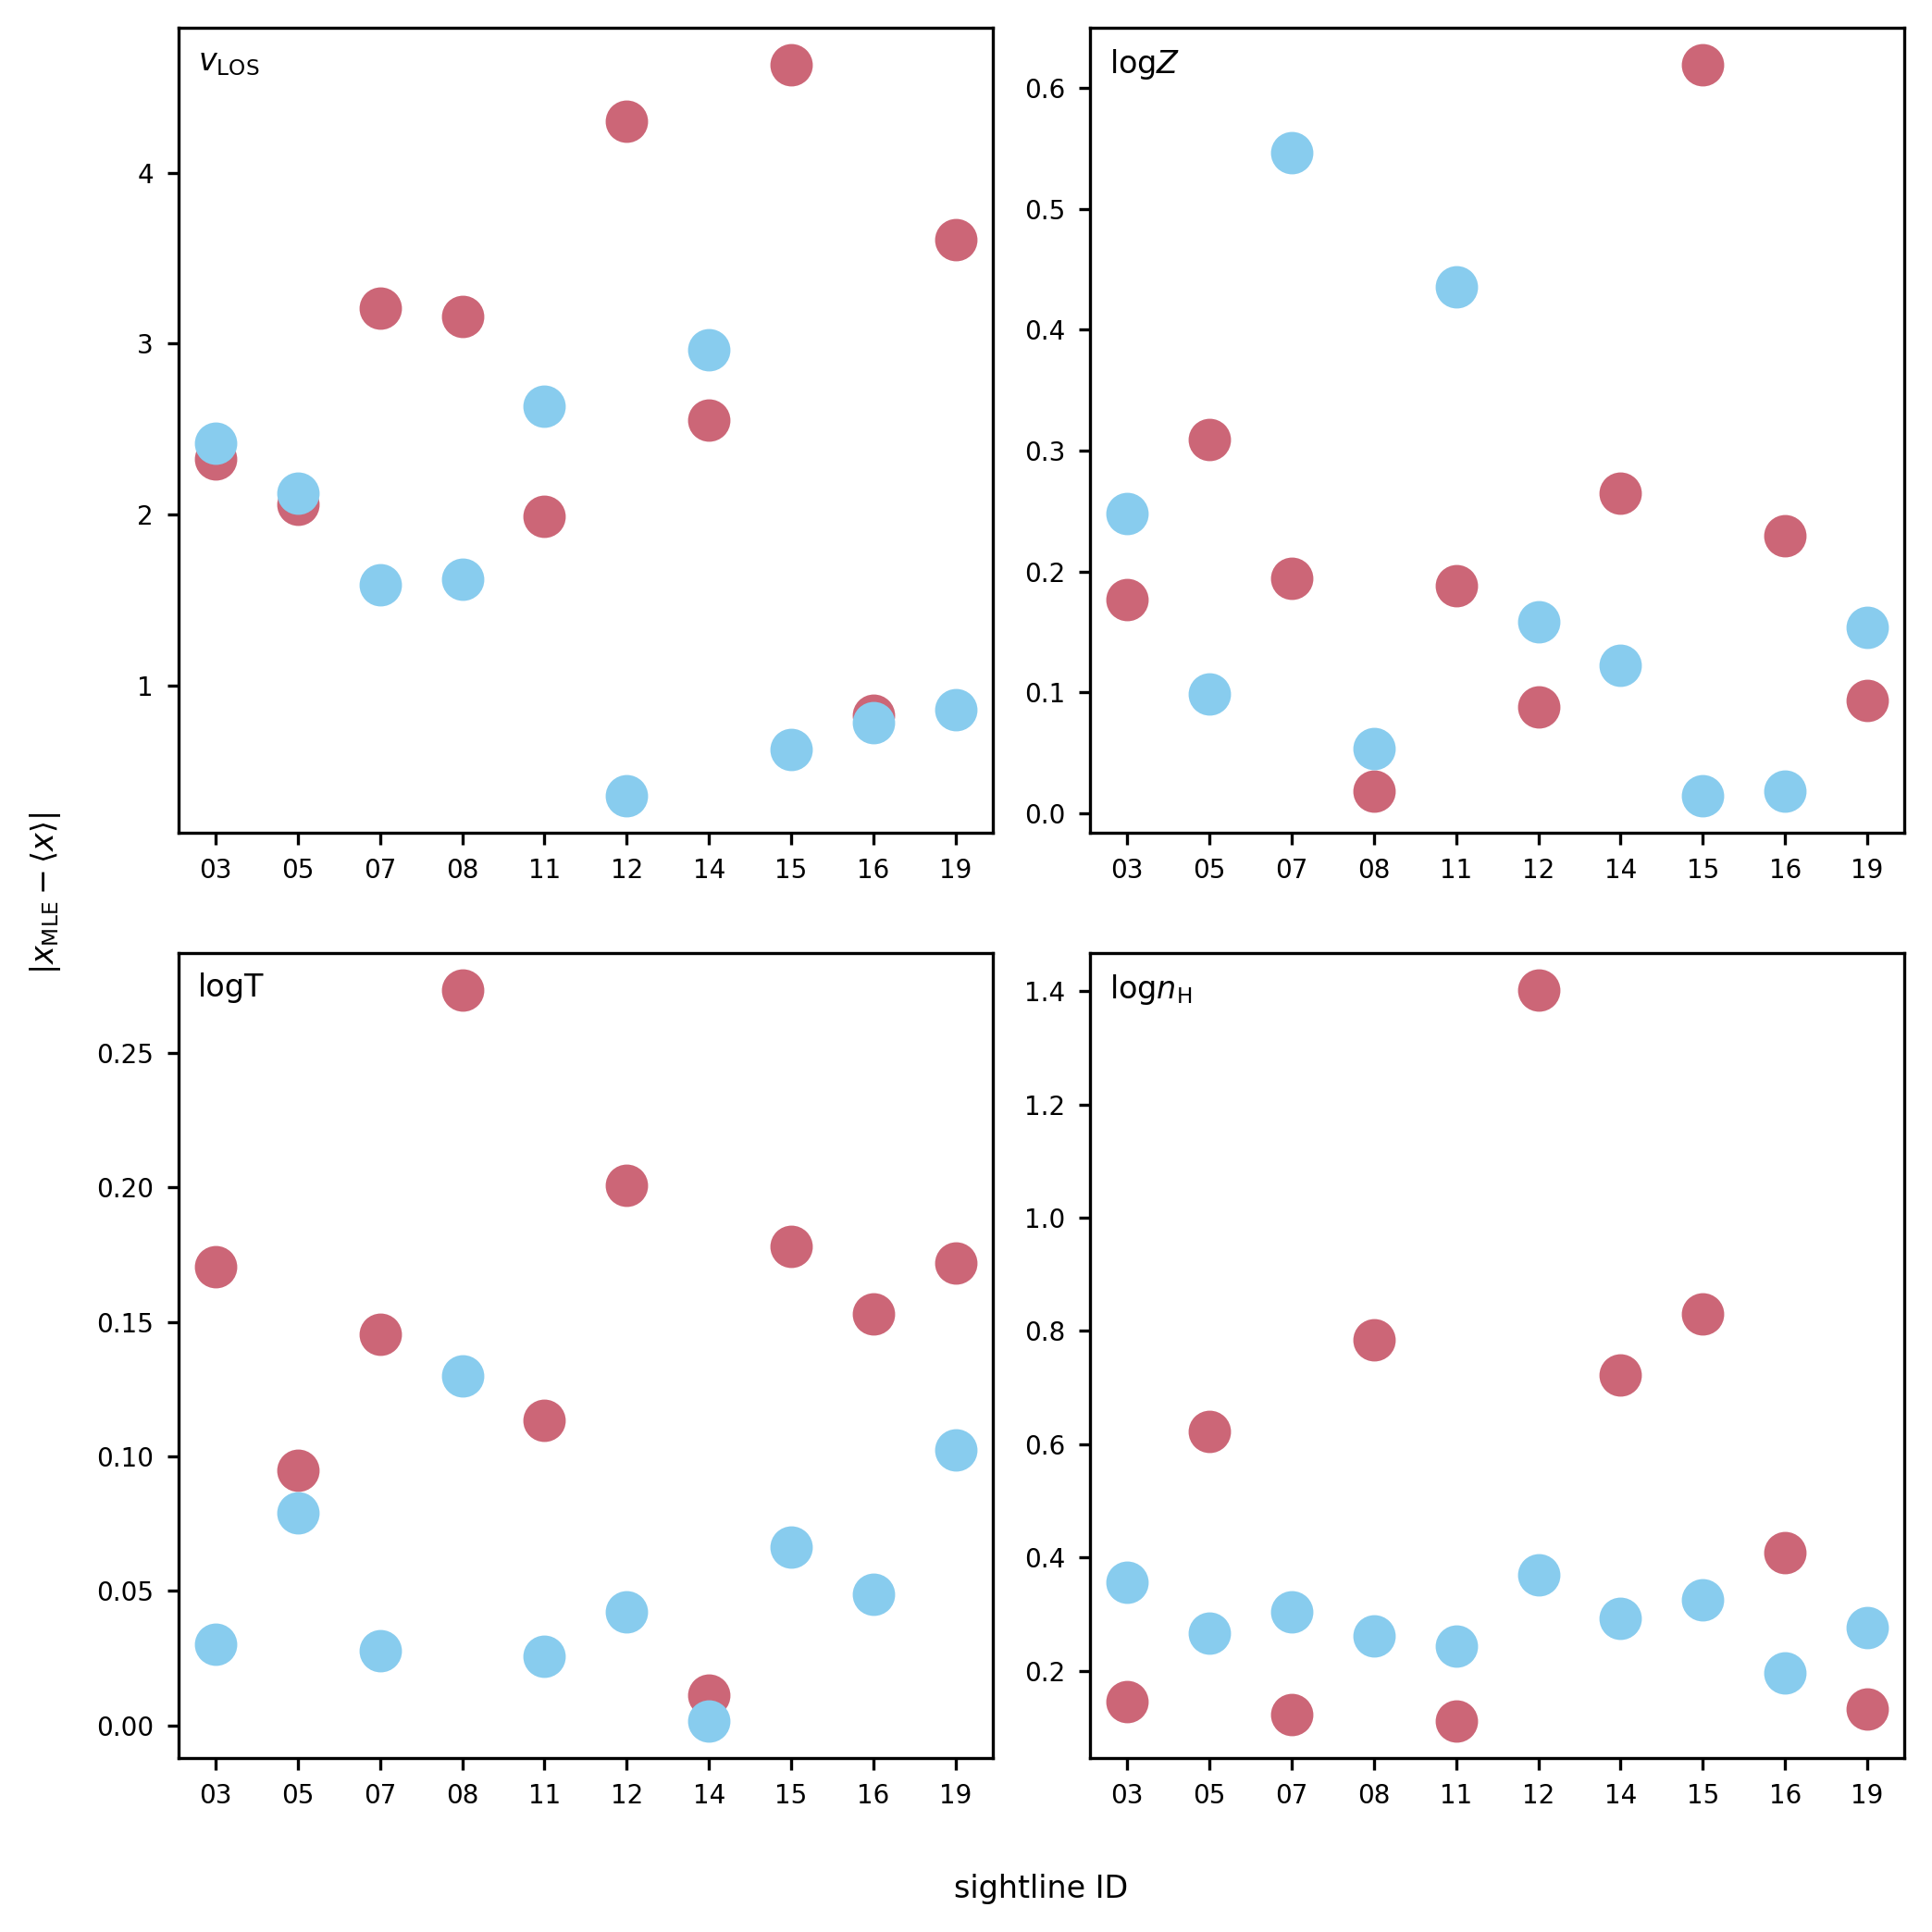

In [34]:
def get_ys( variation, prop_key ):

    pm = pms[variation]

    d_between = distances_between[pm['public_label']][prop_key]['distance_to_avg'].array()
    return d_between

fig, main_ax, ax_dict = plot_metric( get_ys )

main_ax.set_xlabel( 'sightline ID', labelpad=30 )
main_ax.set_ylabel( r'$\left| x_{\rm MLE} - \langle x \rangle \right|$', labelpad=30 )

## Distribution Widths

### Scaled by error

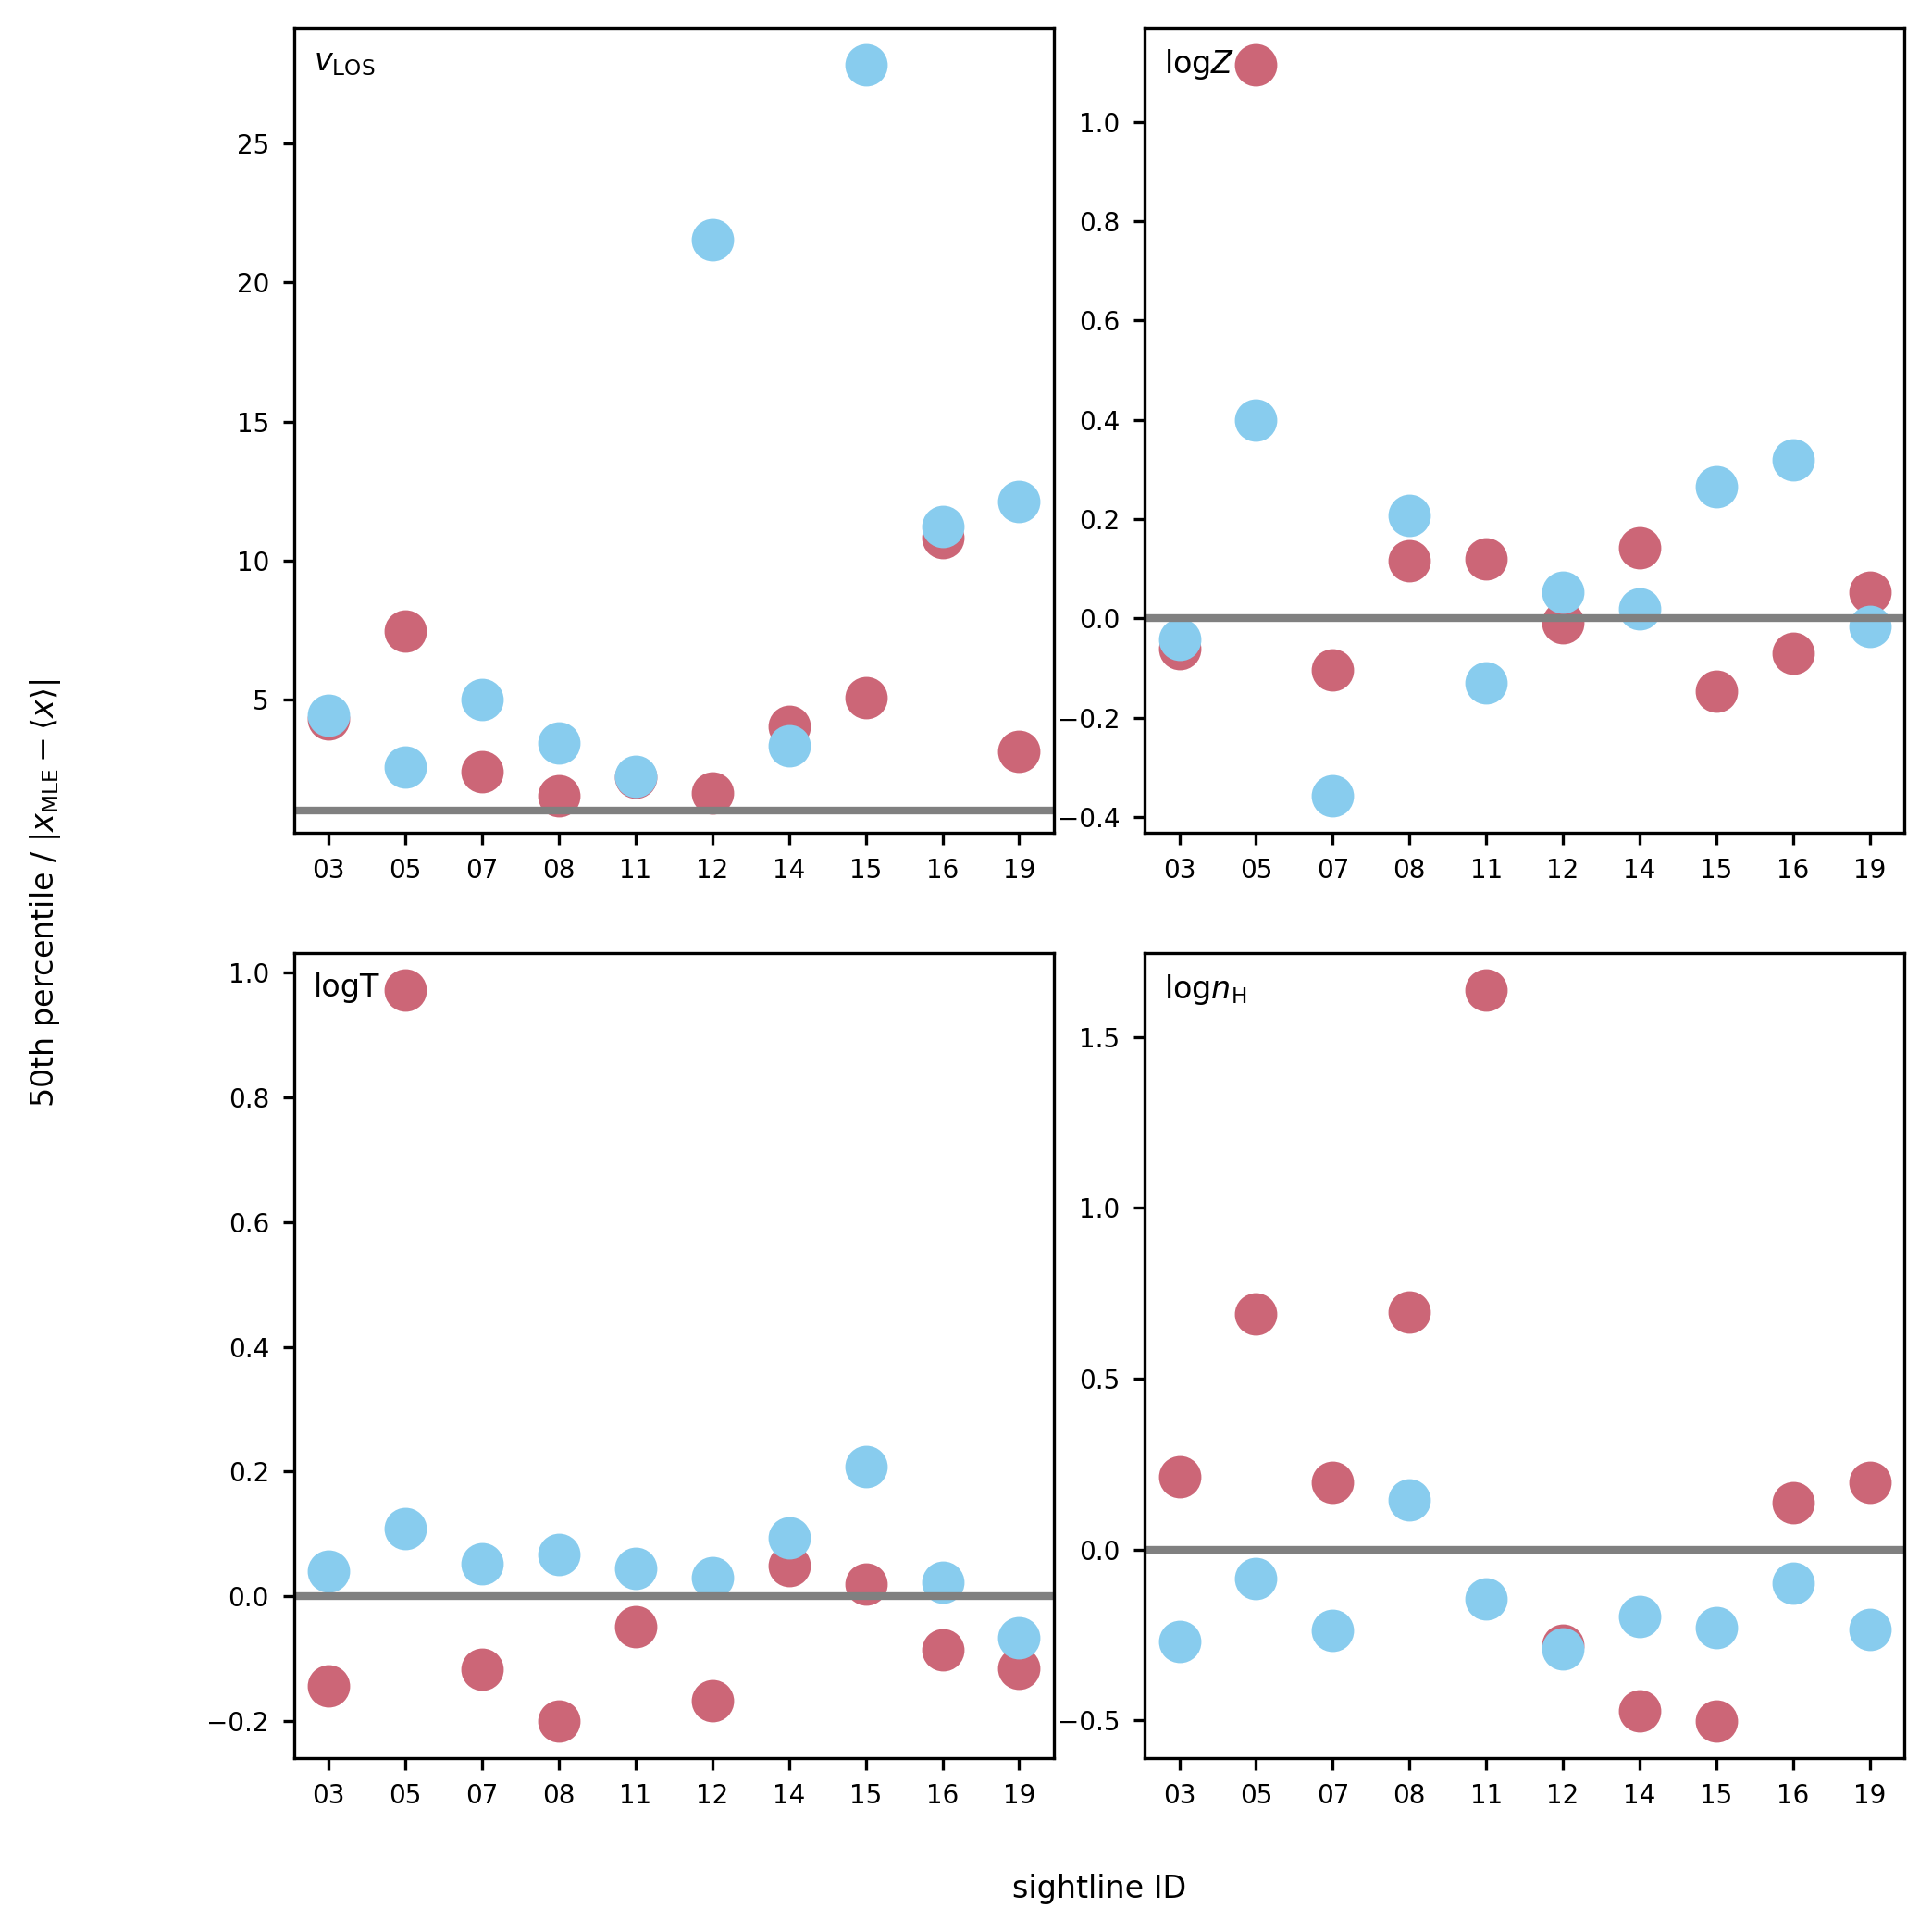

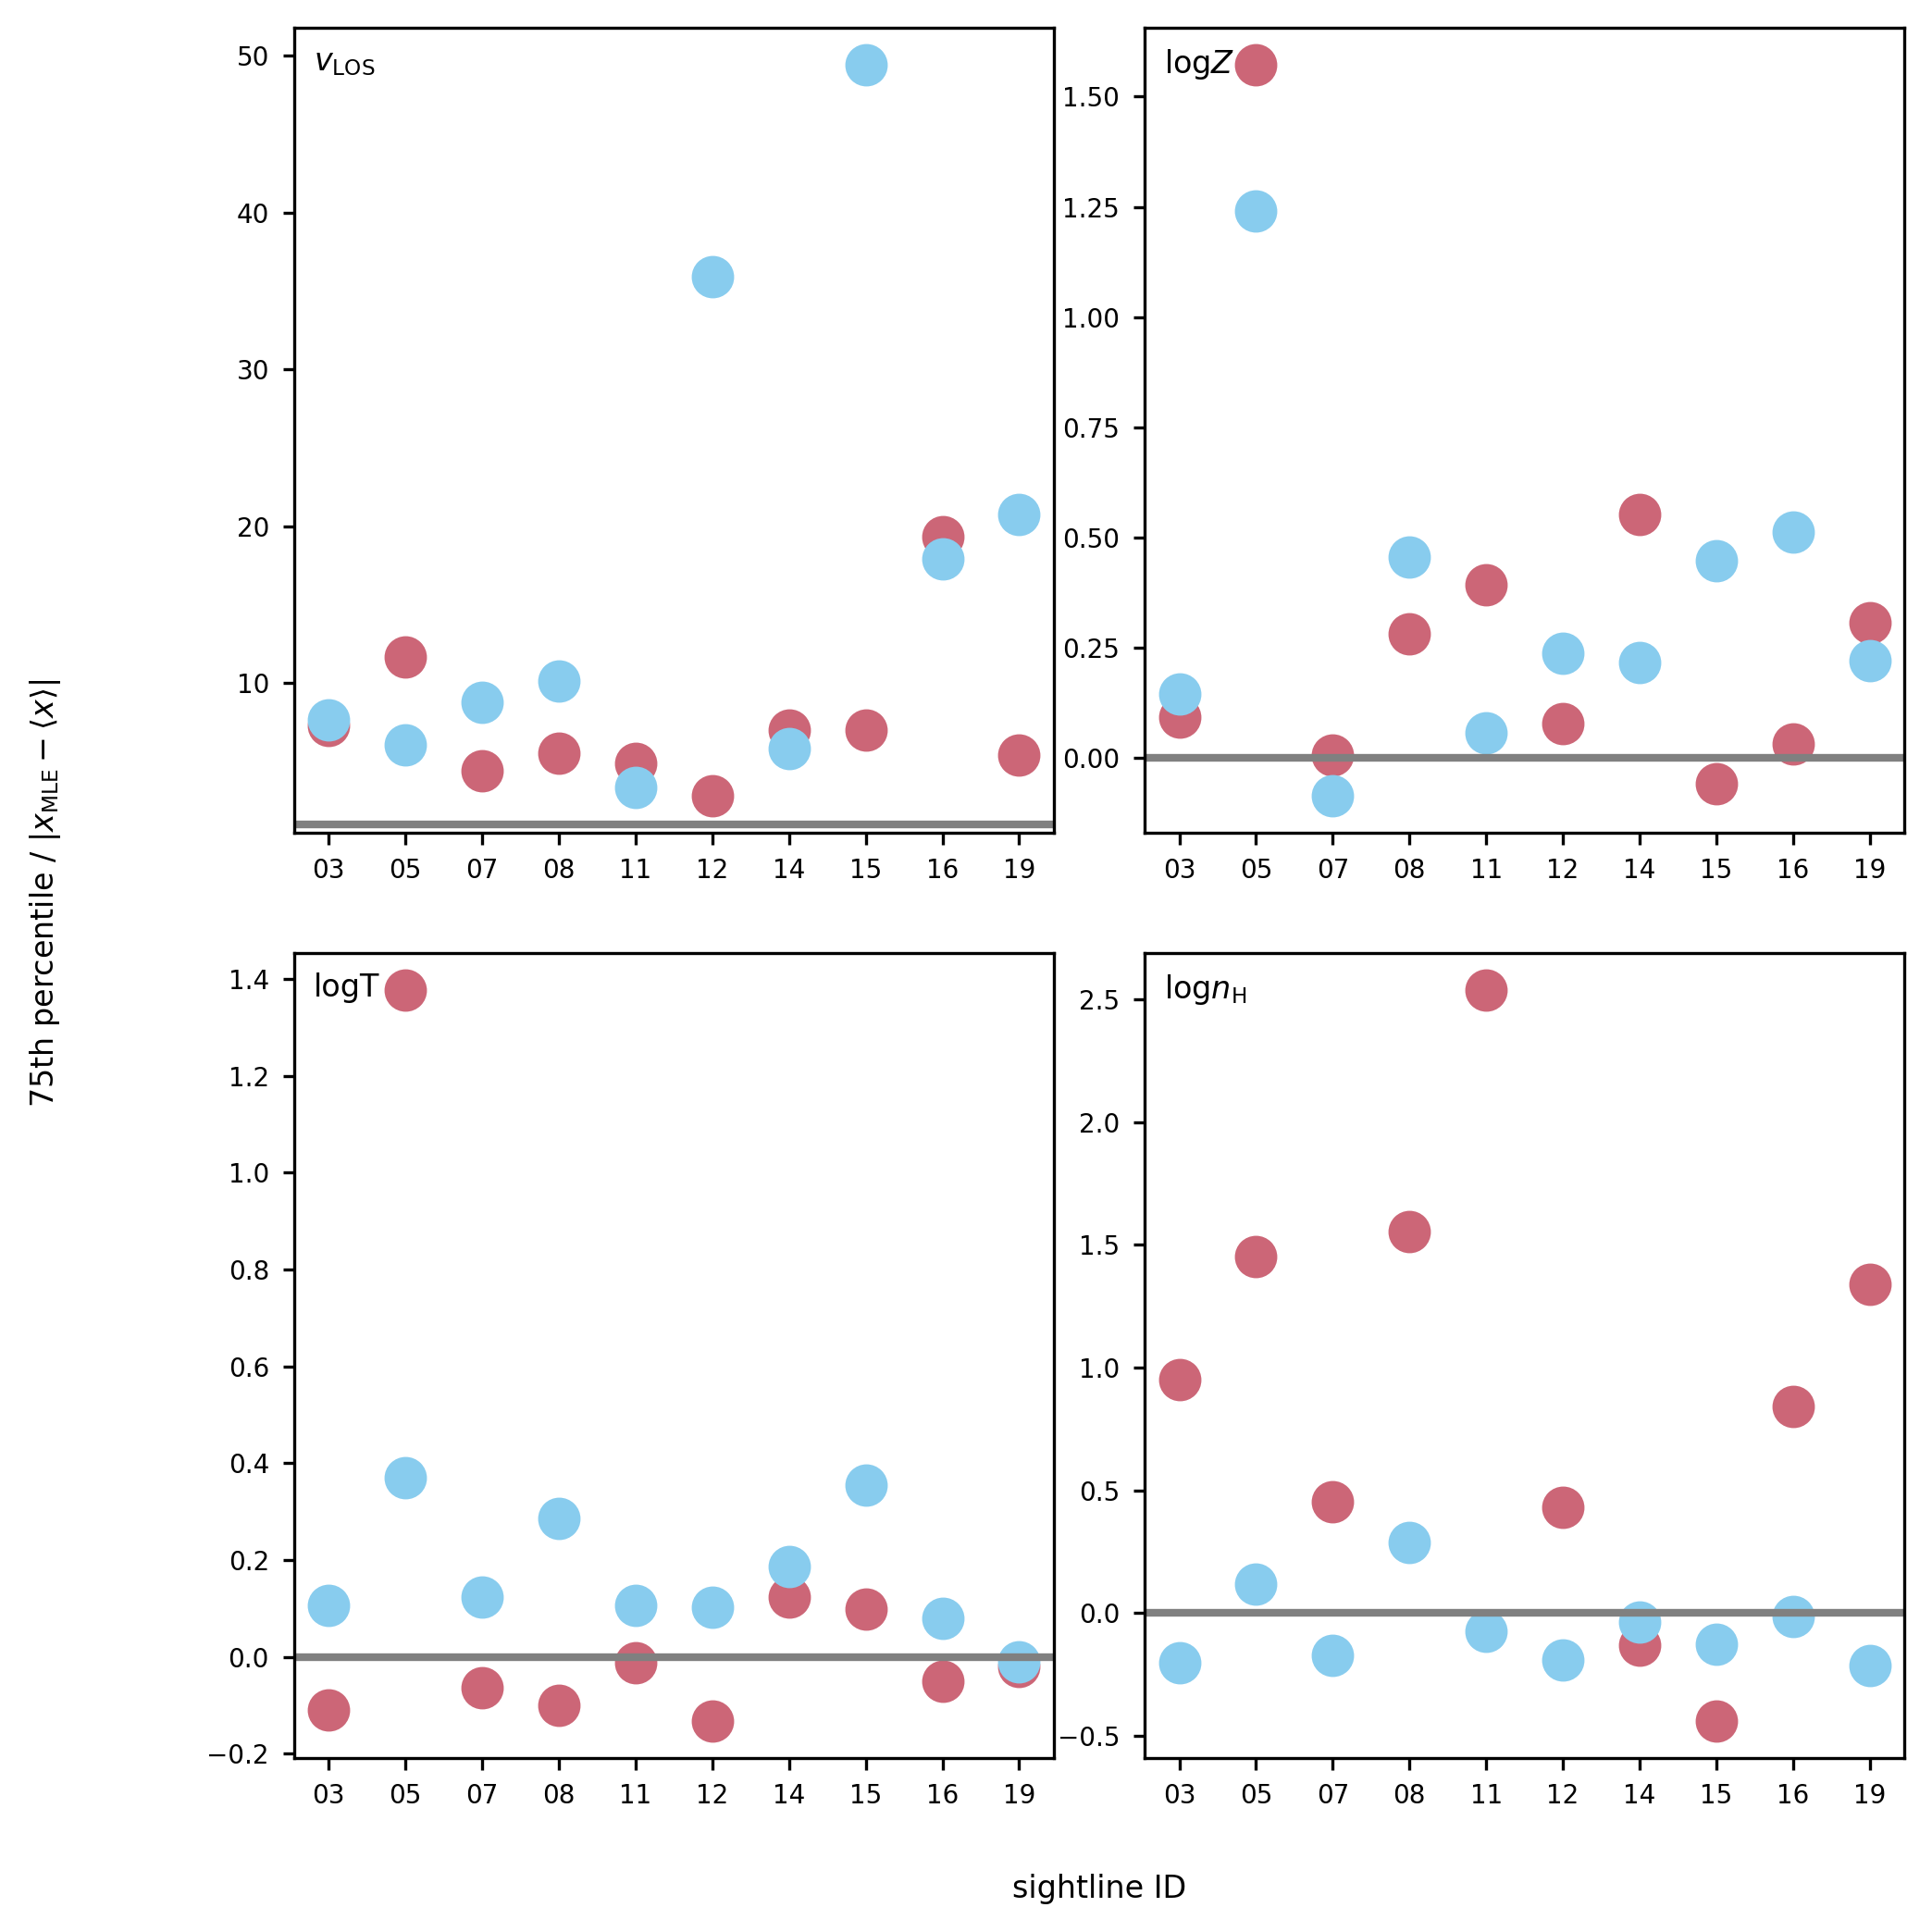

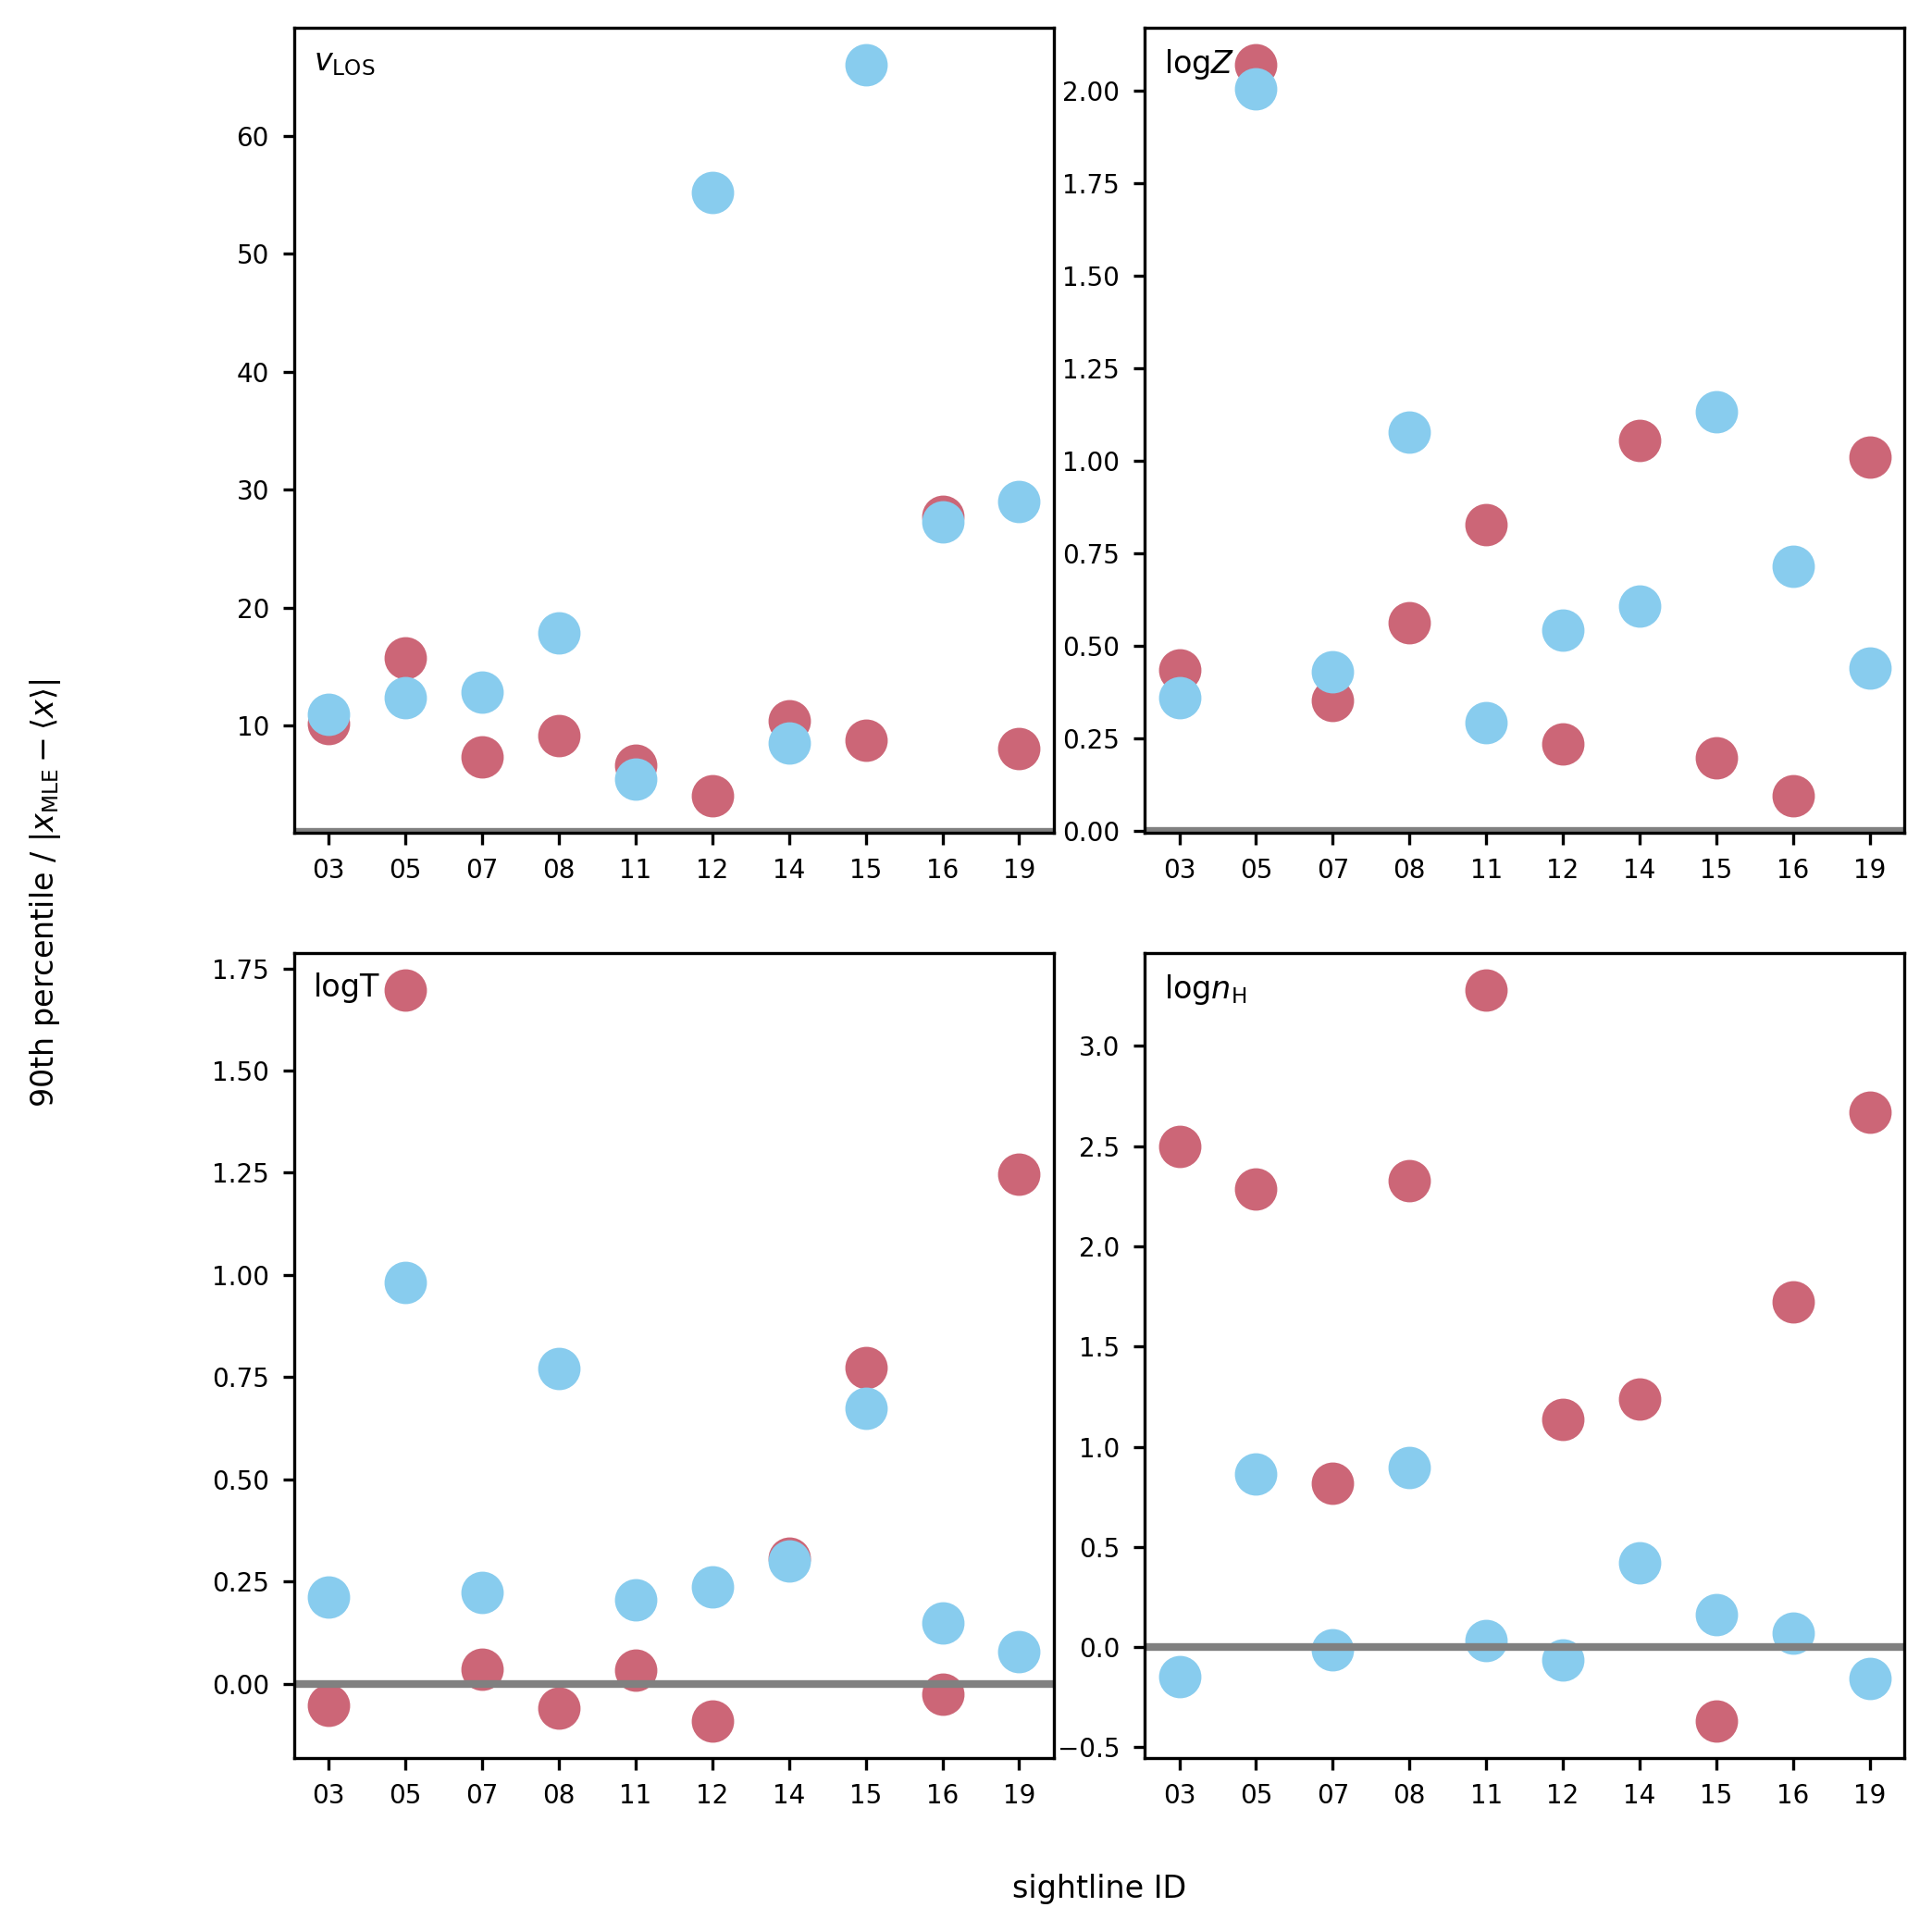

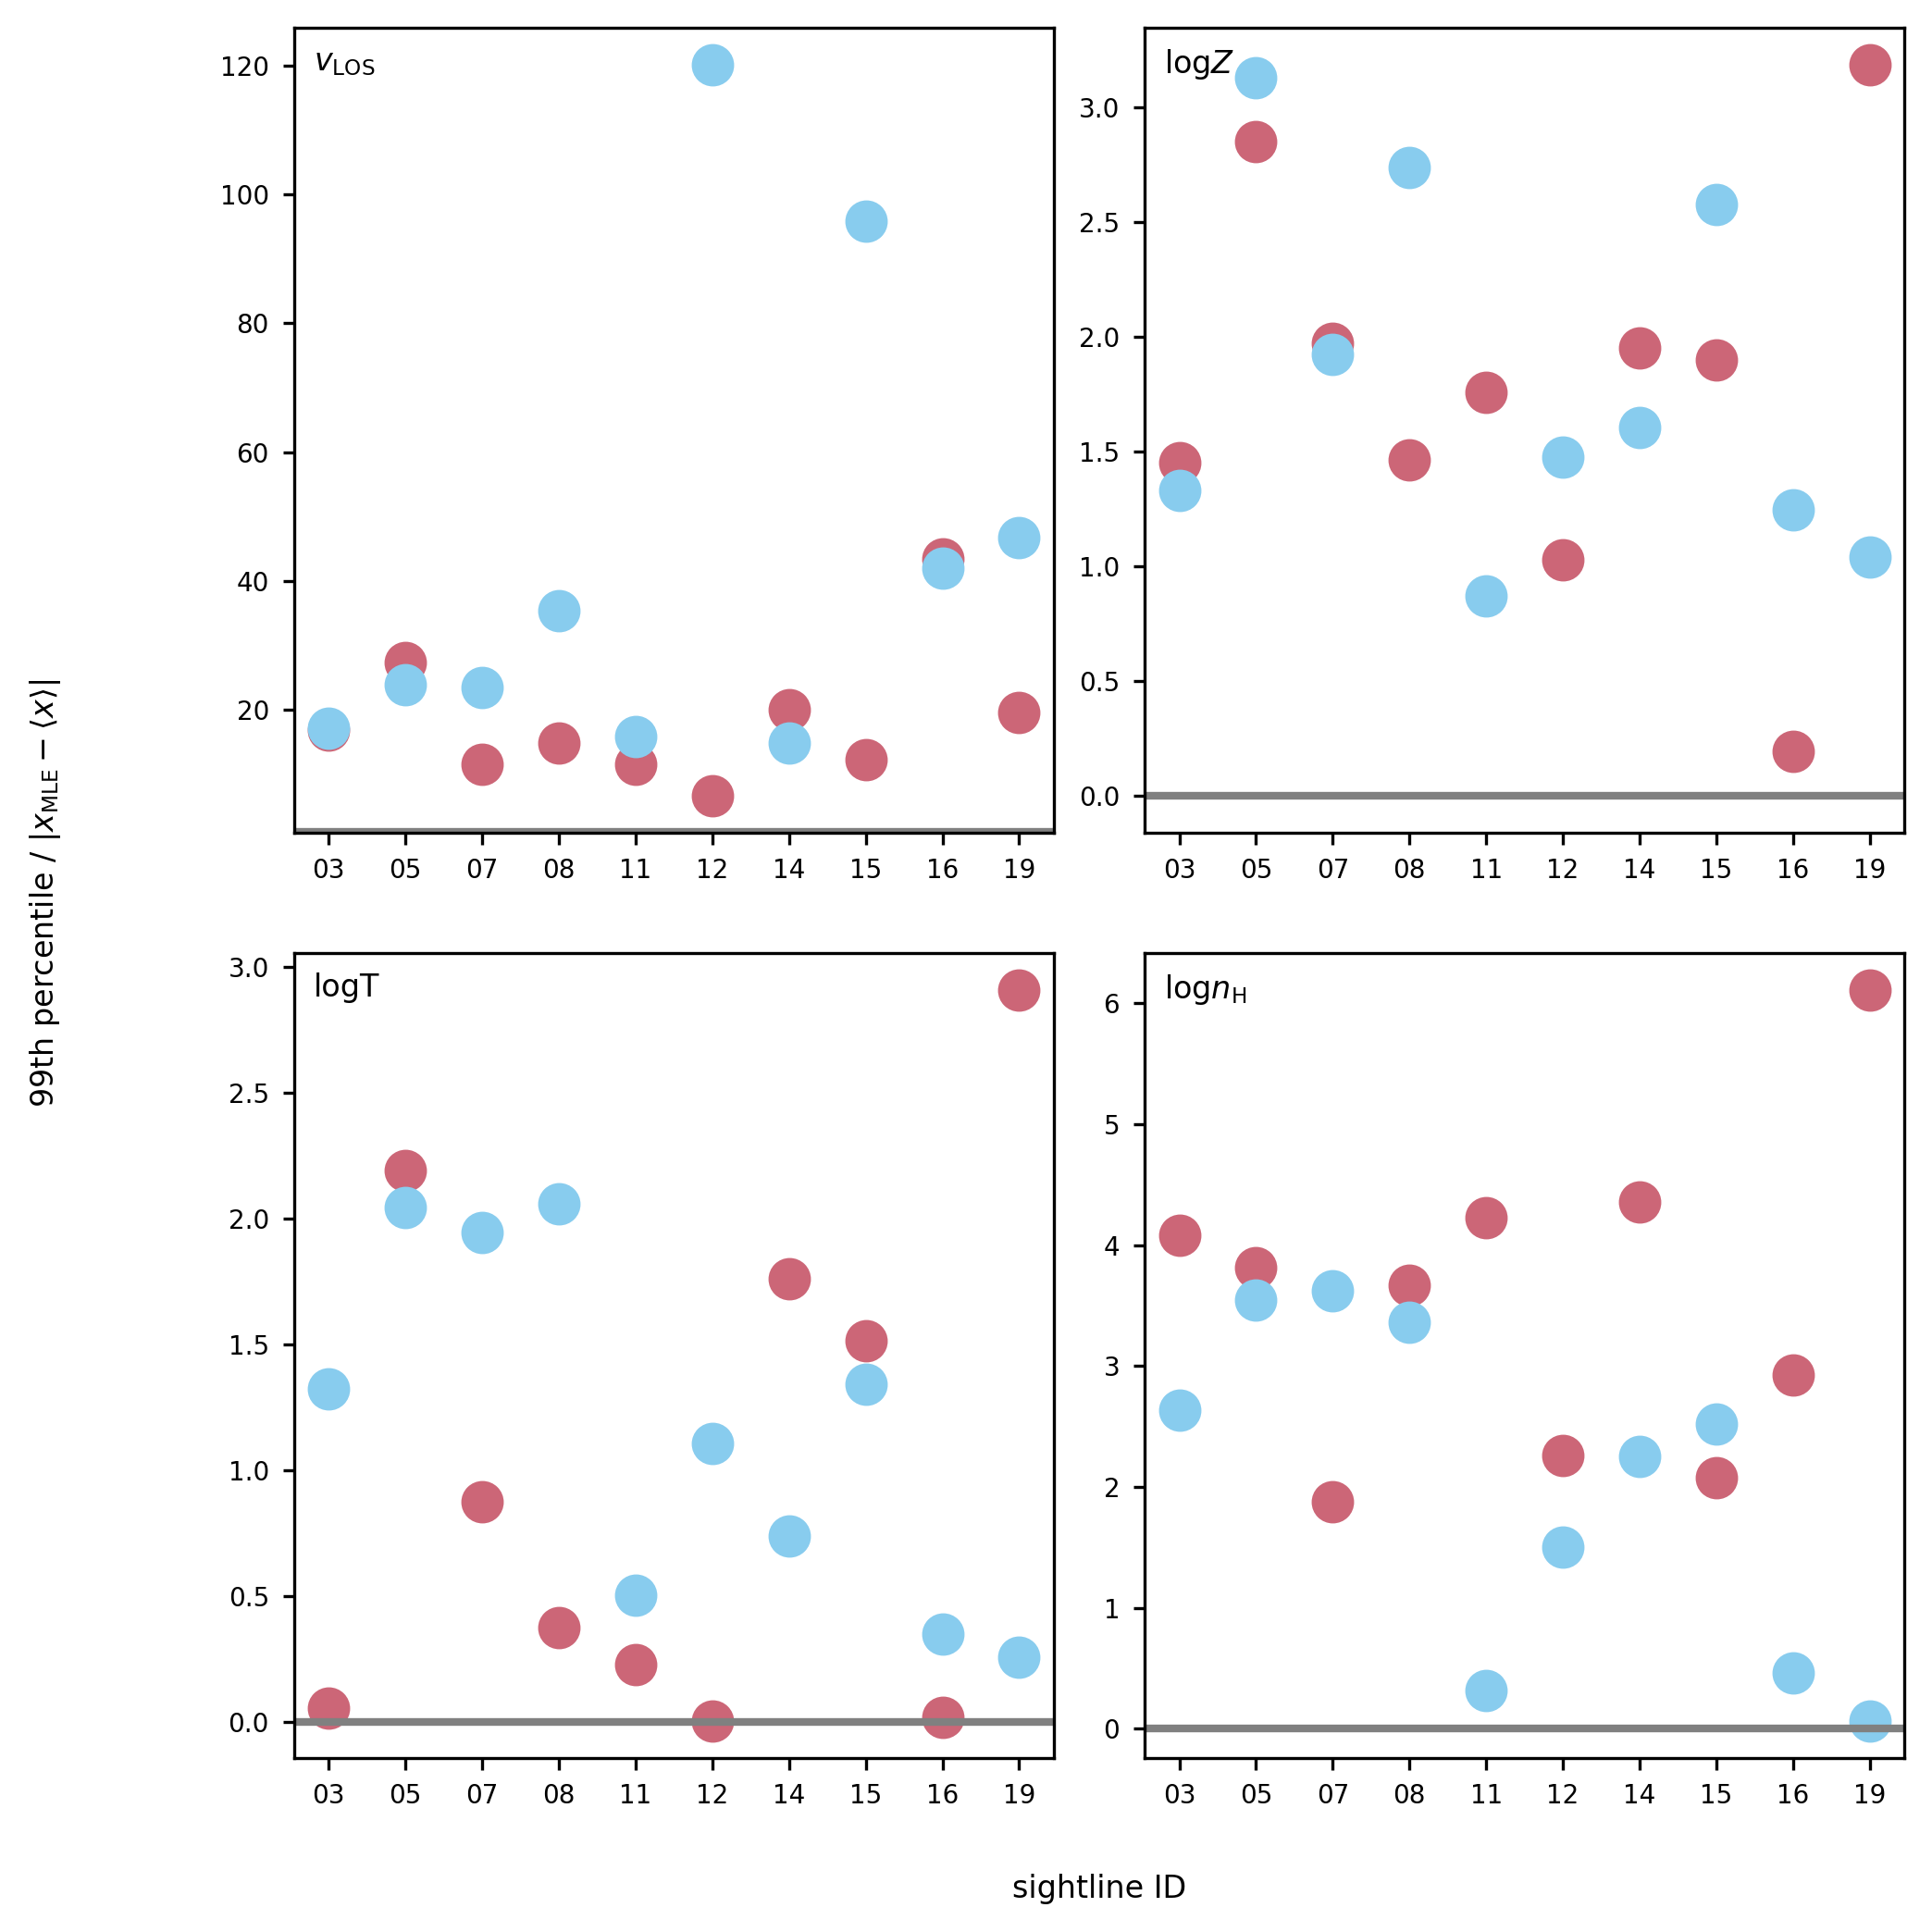

In [35]:
for fraction in pm['f_enclosed']:
    
    def get_widths( variation, prop_key ):
        
        pm = pms[variation]
        
        percentile = percentiles[pm['public_label']]['estimated'][prop_key][str(fraction)]['width'].array()
        d_between = distances_between[pm['public_label']][prop_key]['distance_to_avg'].array()
        
        if helpers.logscale[prop_key]:
            return percentile - d_between
        else:
            return percentile / d_between
    
    fig, main_ax, ax_dict = plot_metric( get_widths )
    
    for ax_key, ax in ax_dict.items():
        
        hline = 1
        
        if helpers.logscale[ax_key]:
            hline = np.log10( hline )
            
        ax.axhline( hline, color='0.5', )

    main_ax.set_xlabel( 'sightline ID', labelpad=30 )
    main_ax.set_ylabel( '{}'.format( int( fraction * 100 ) ) + r'th percentile / $\left| x_{\rm MLE} - \langle x \rangle \right|$', labelpad=60 )

### Scaled by distance to enclose

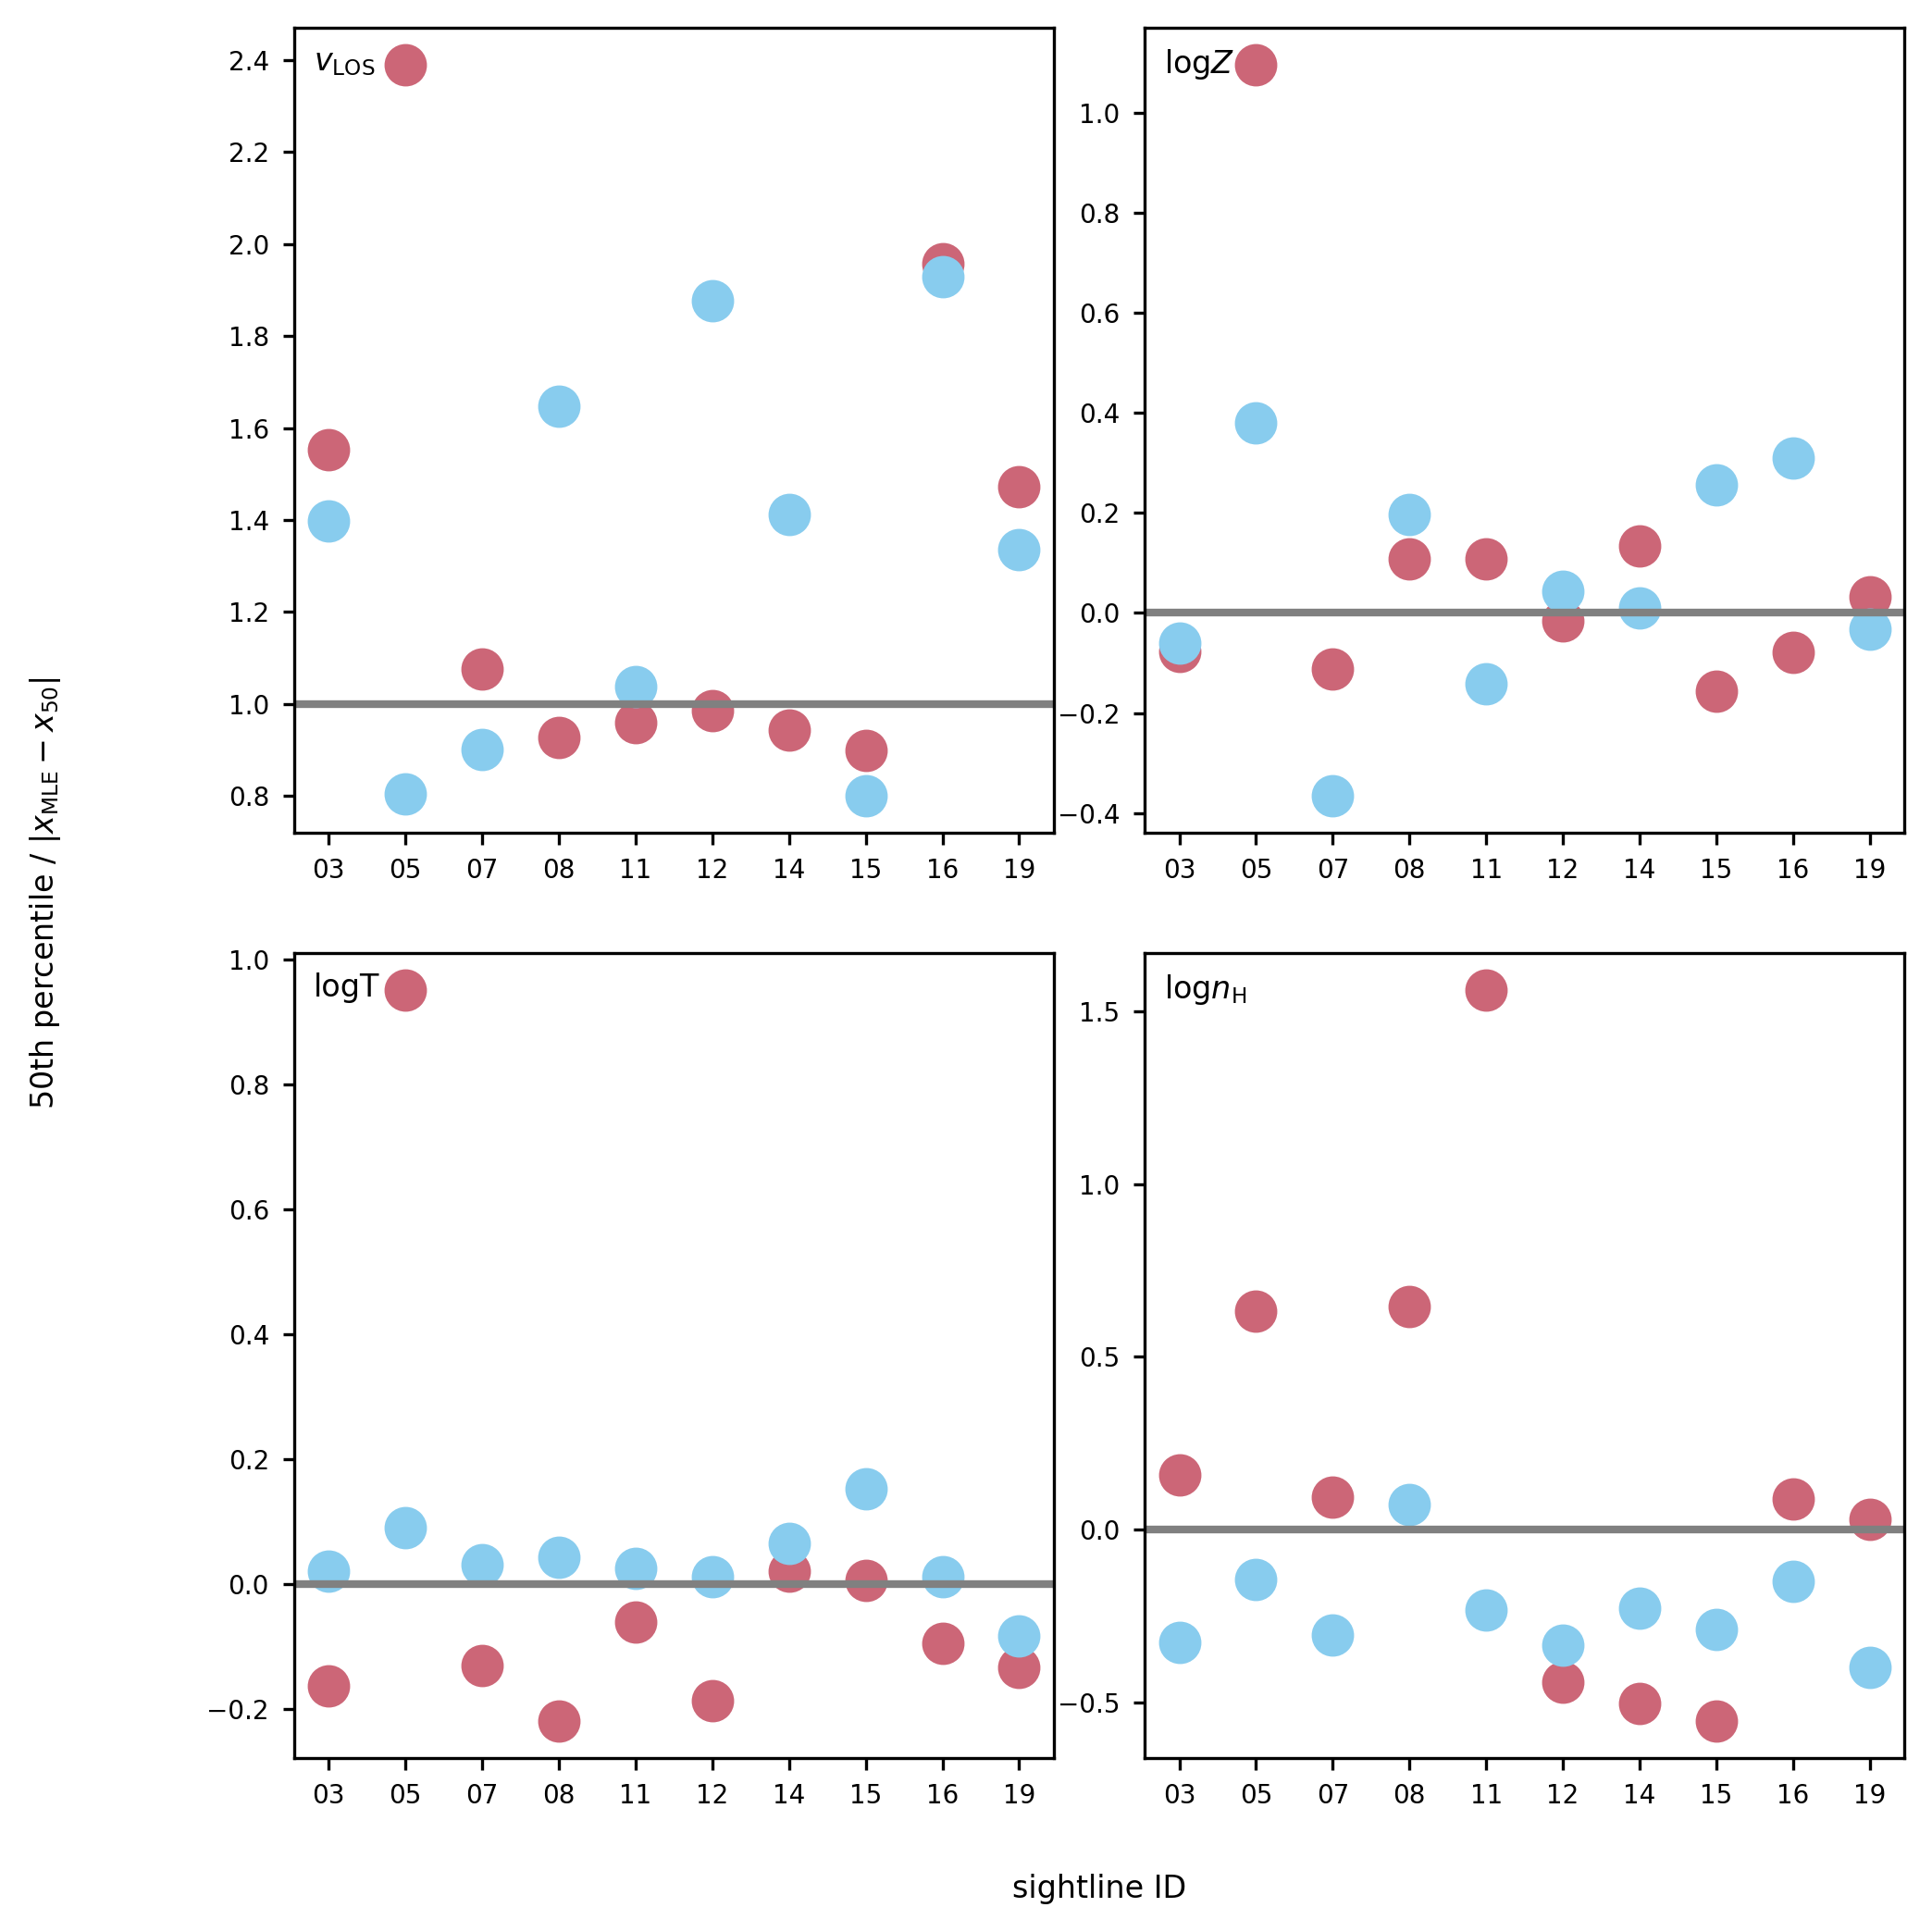

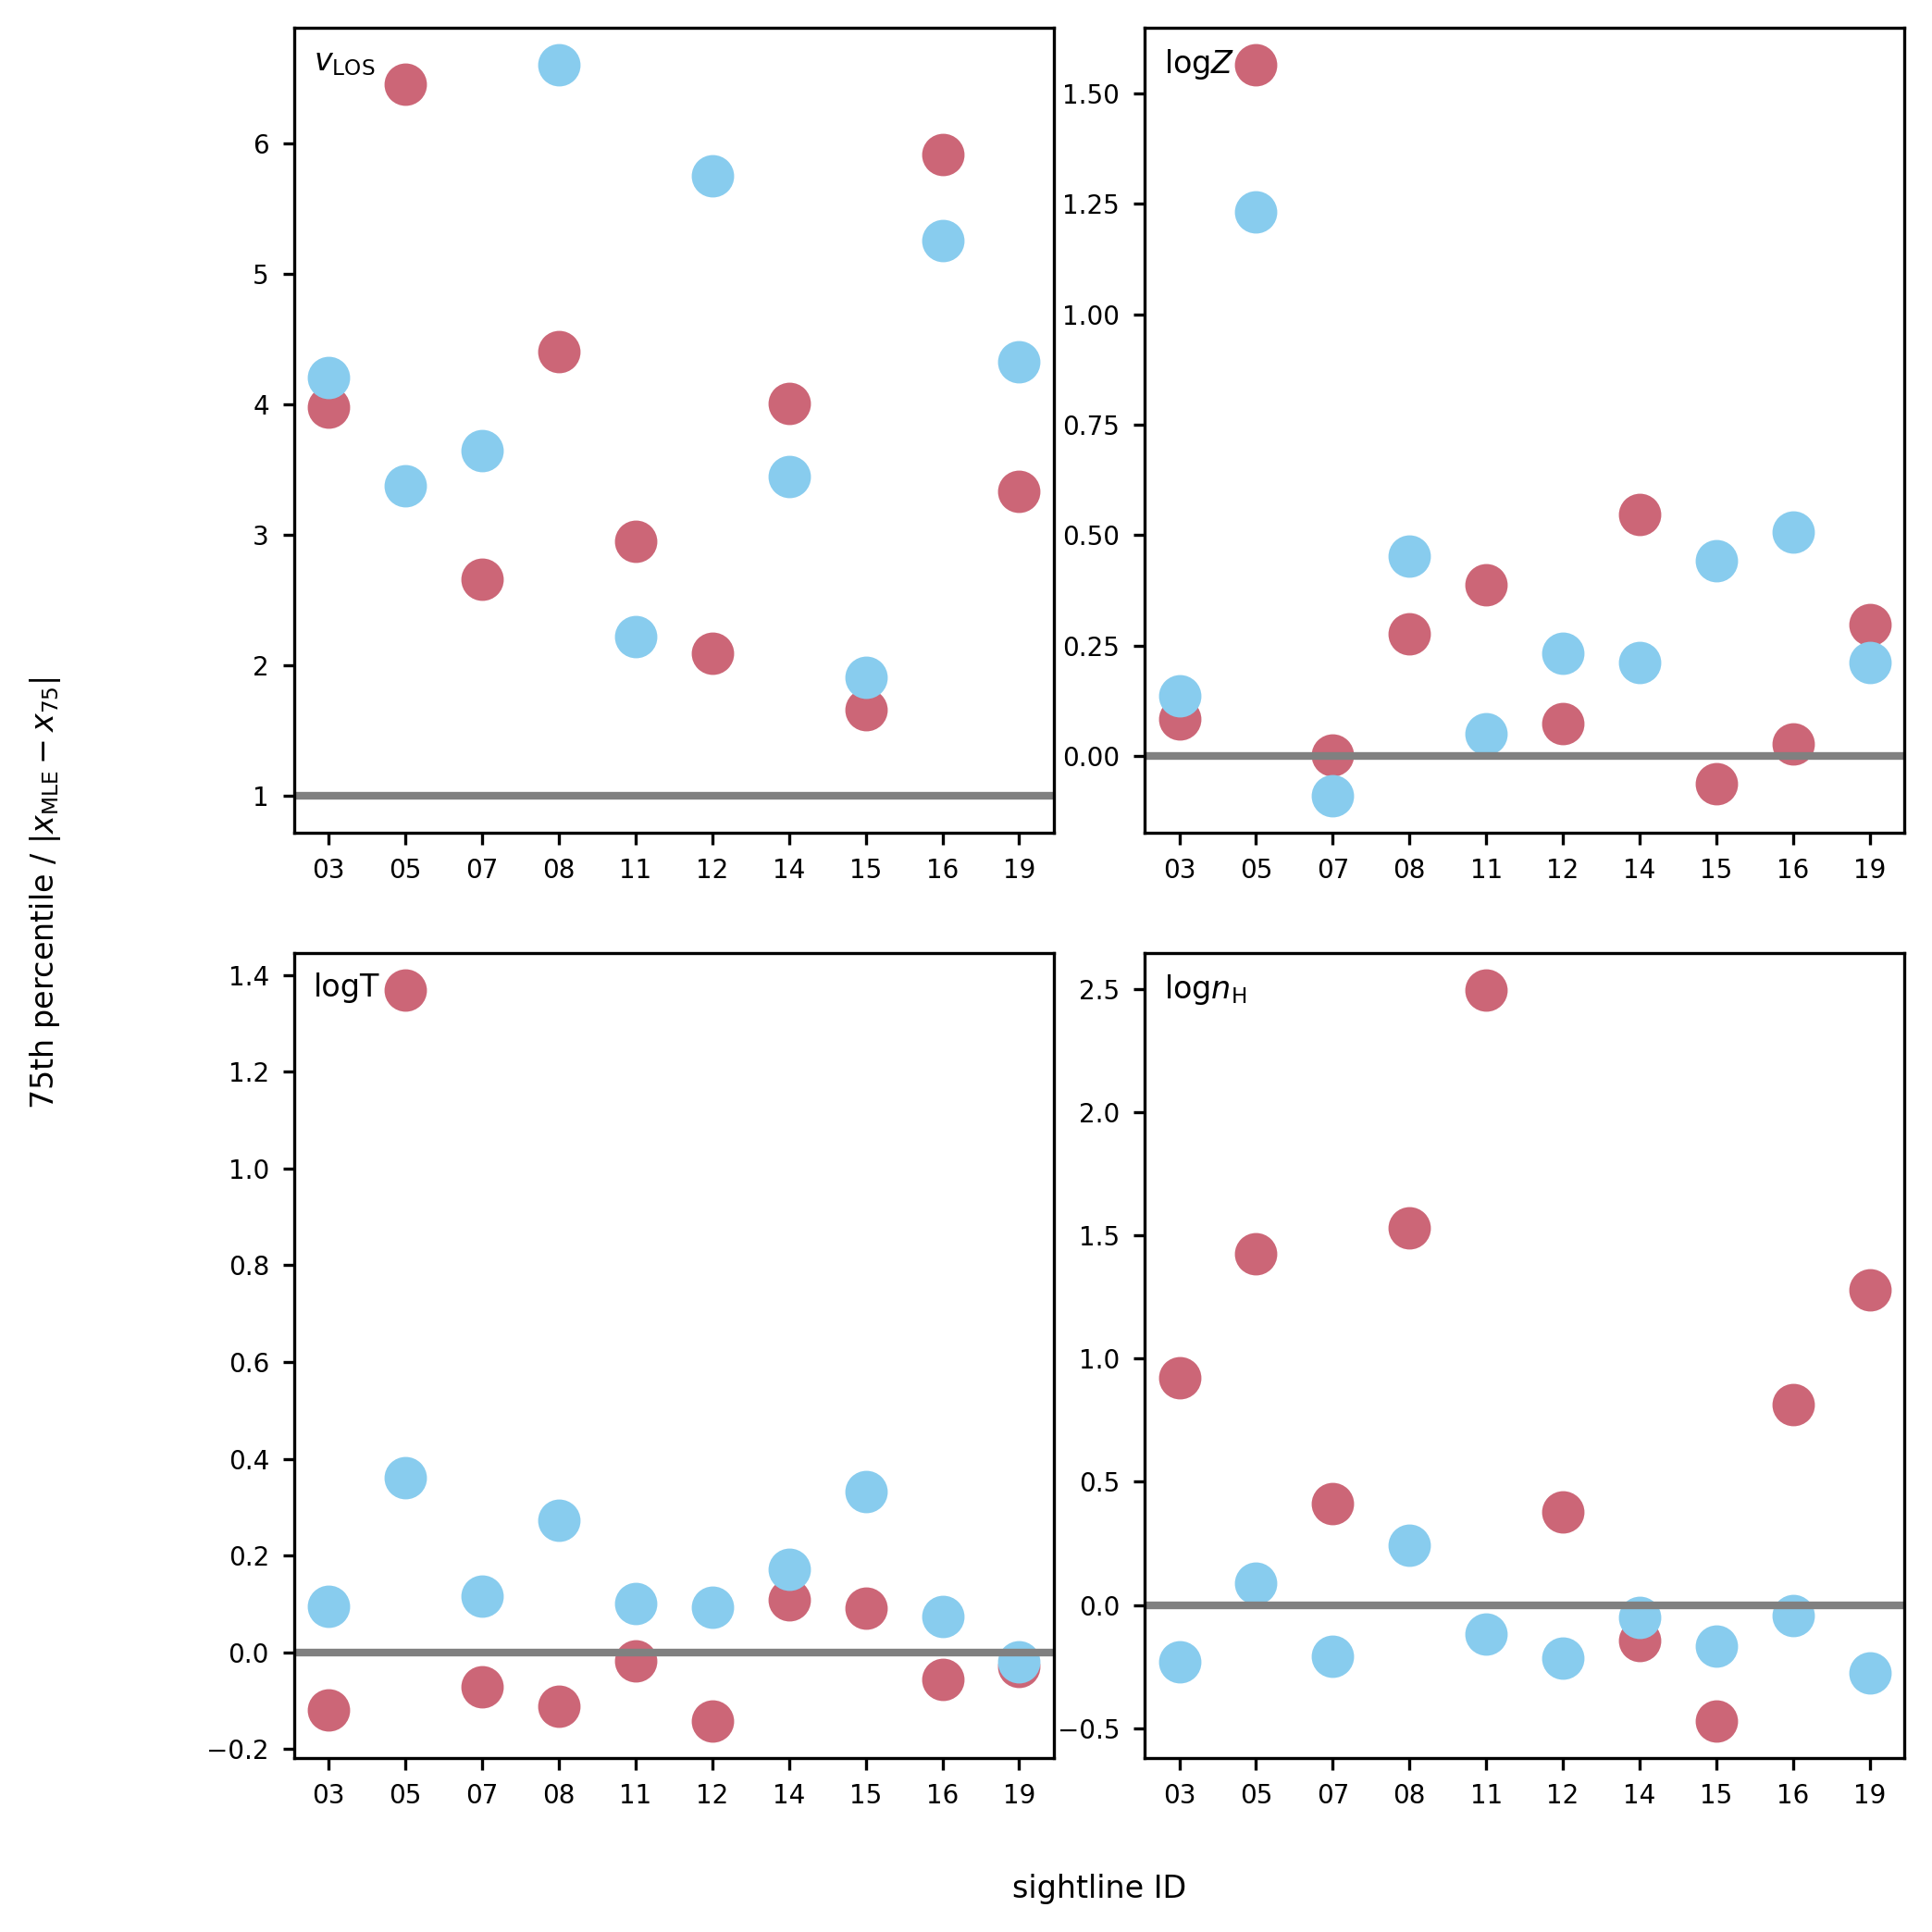

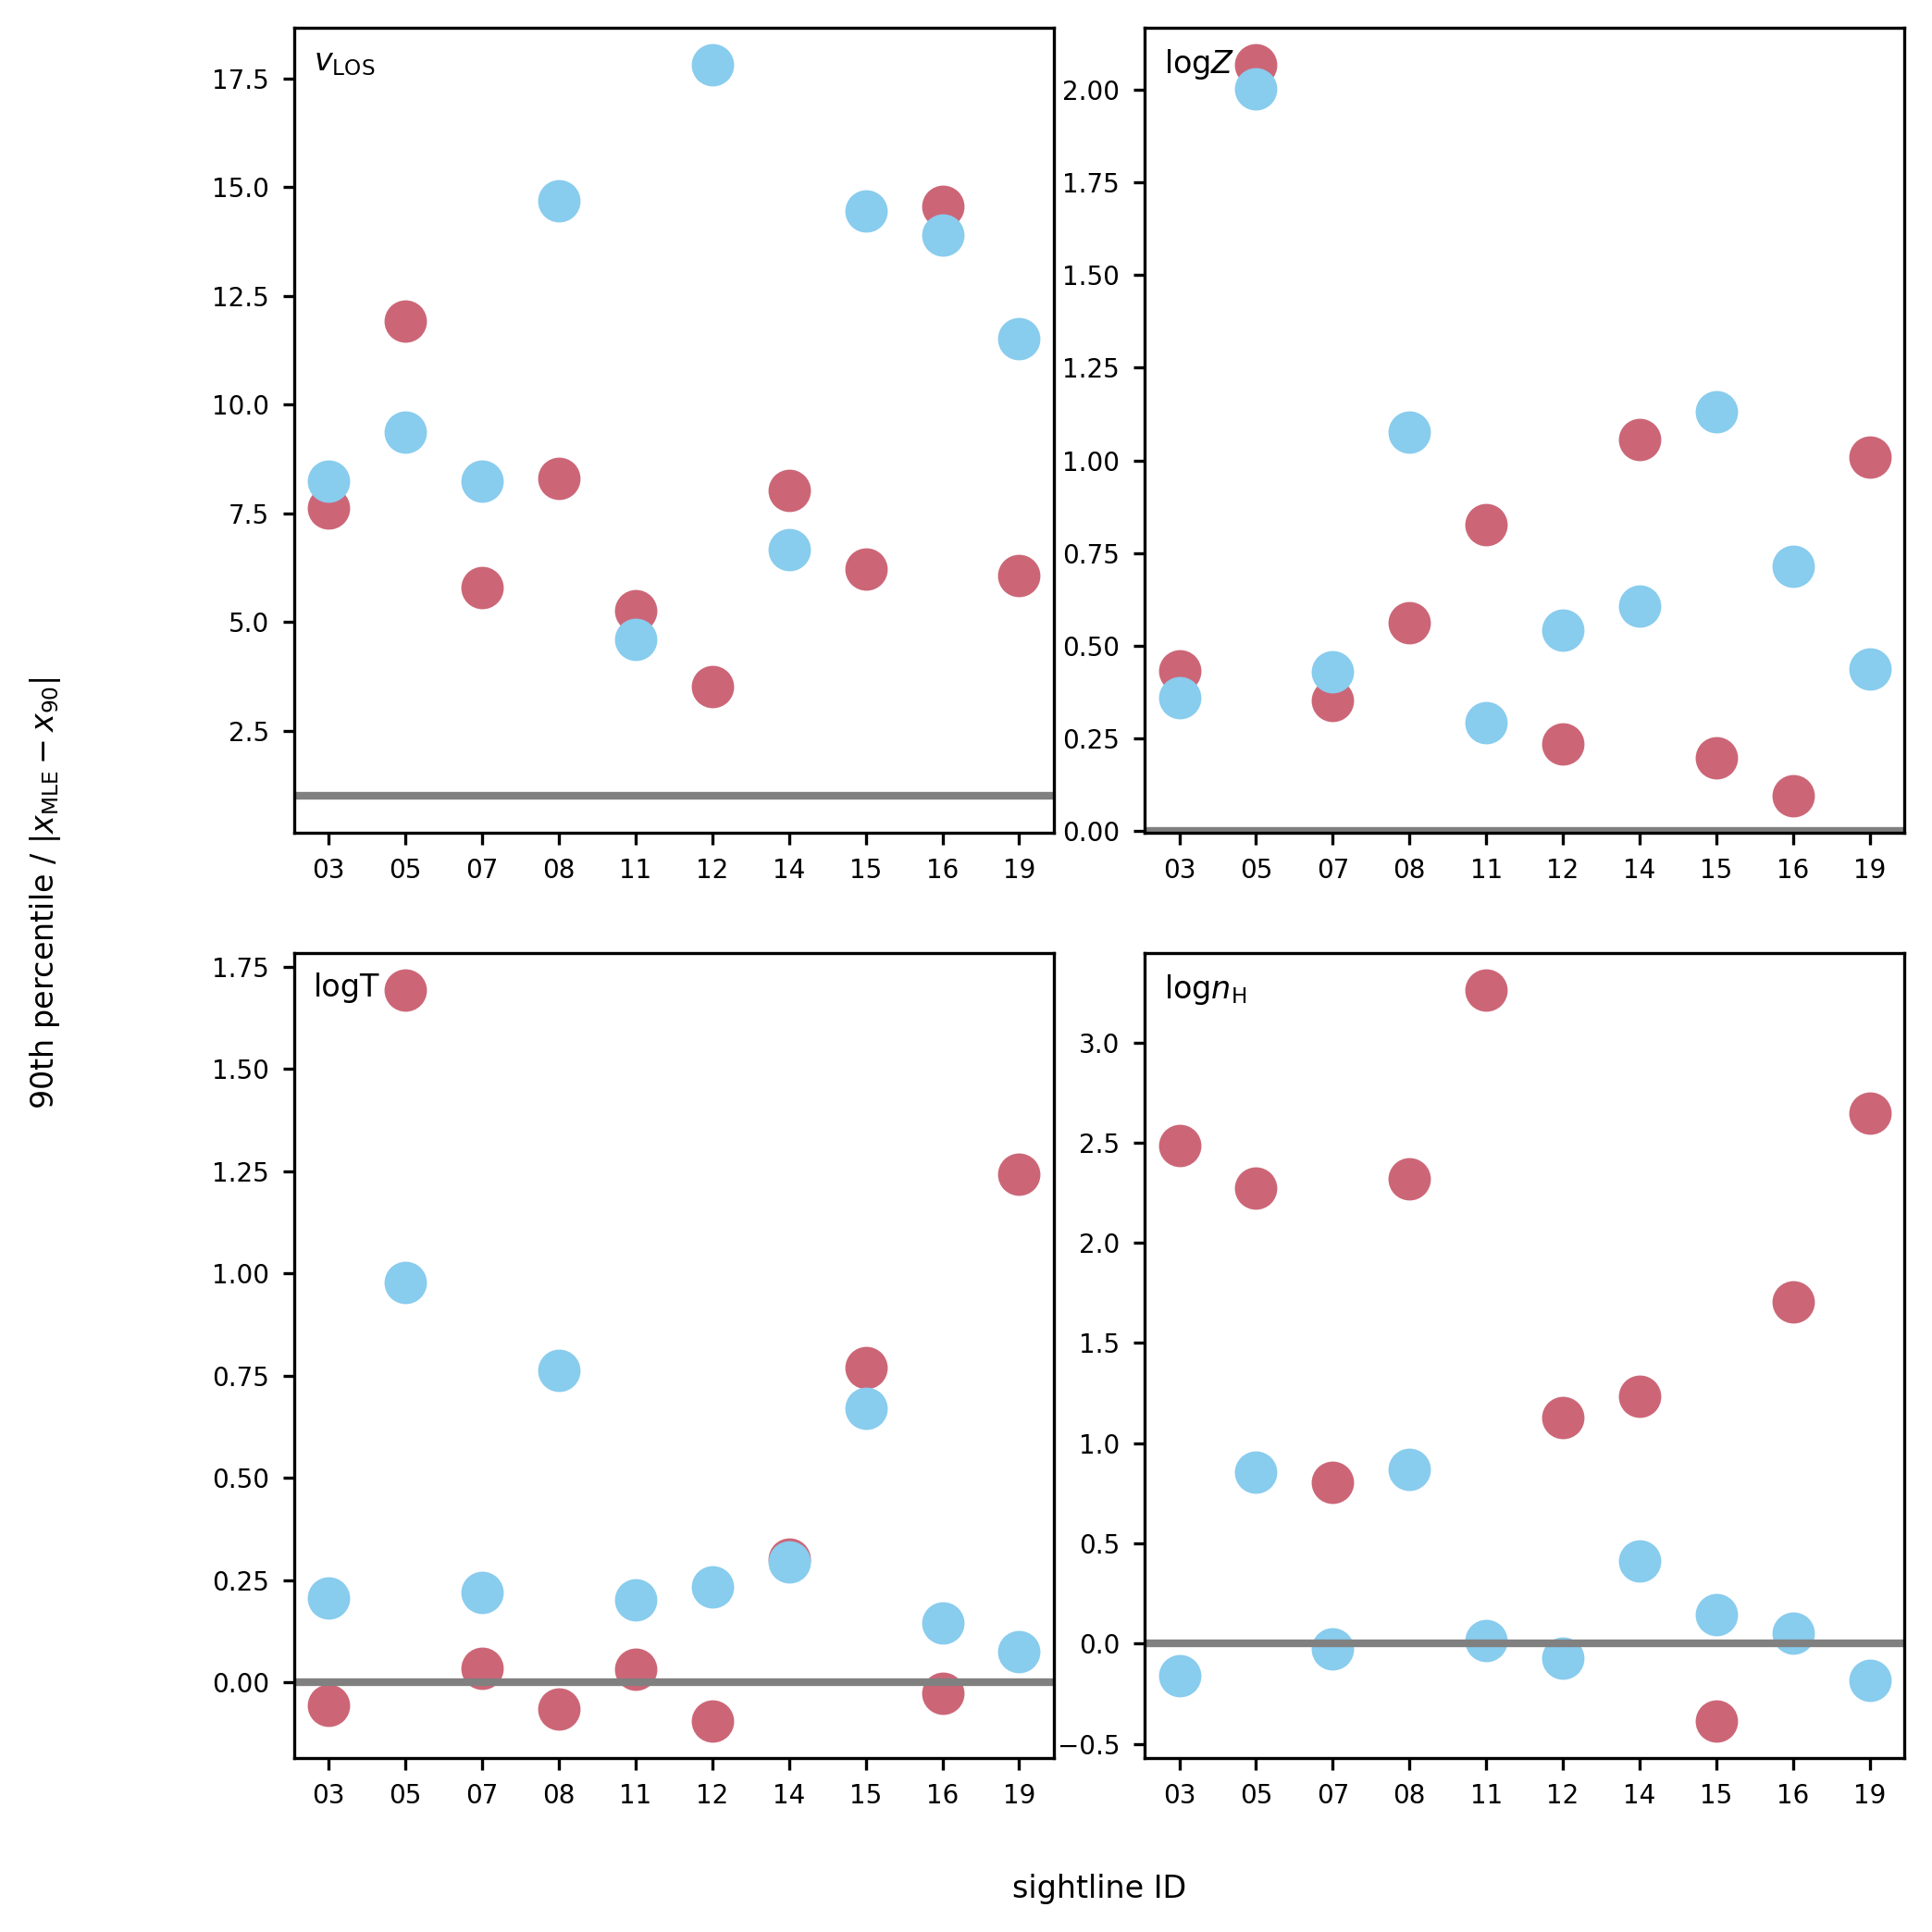

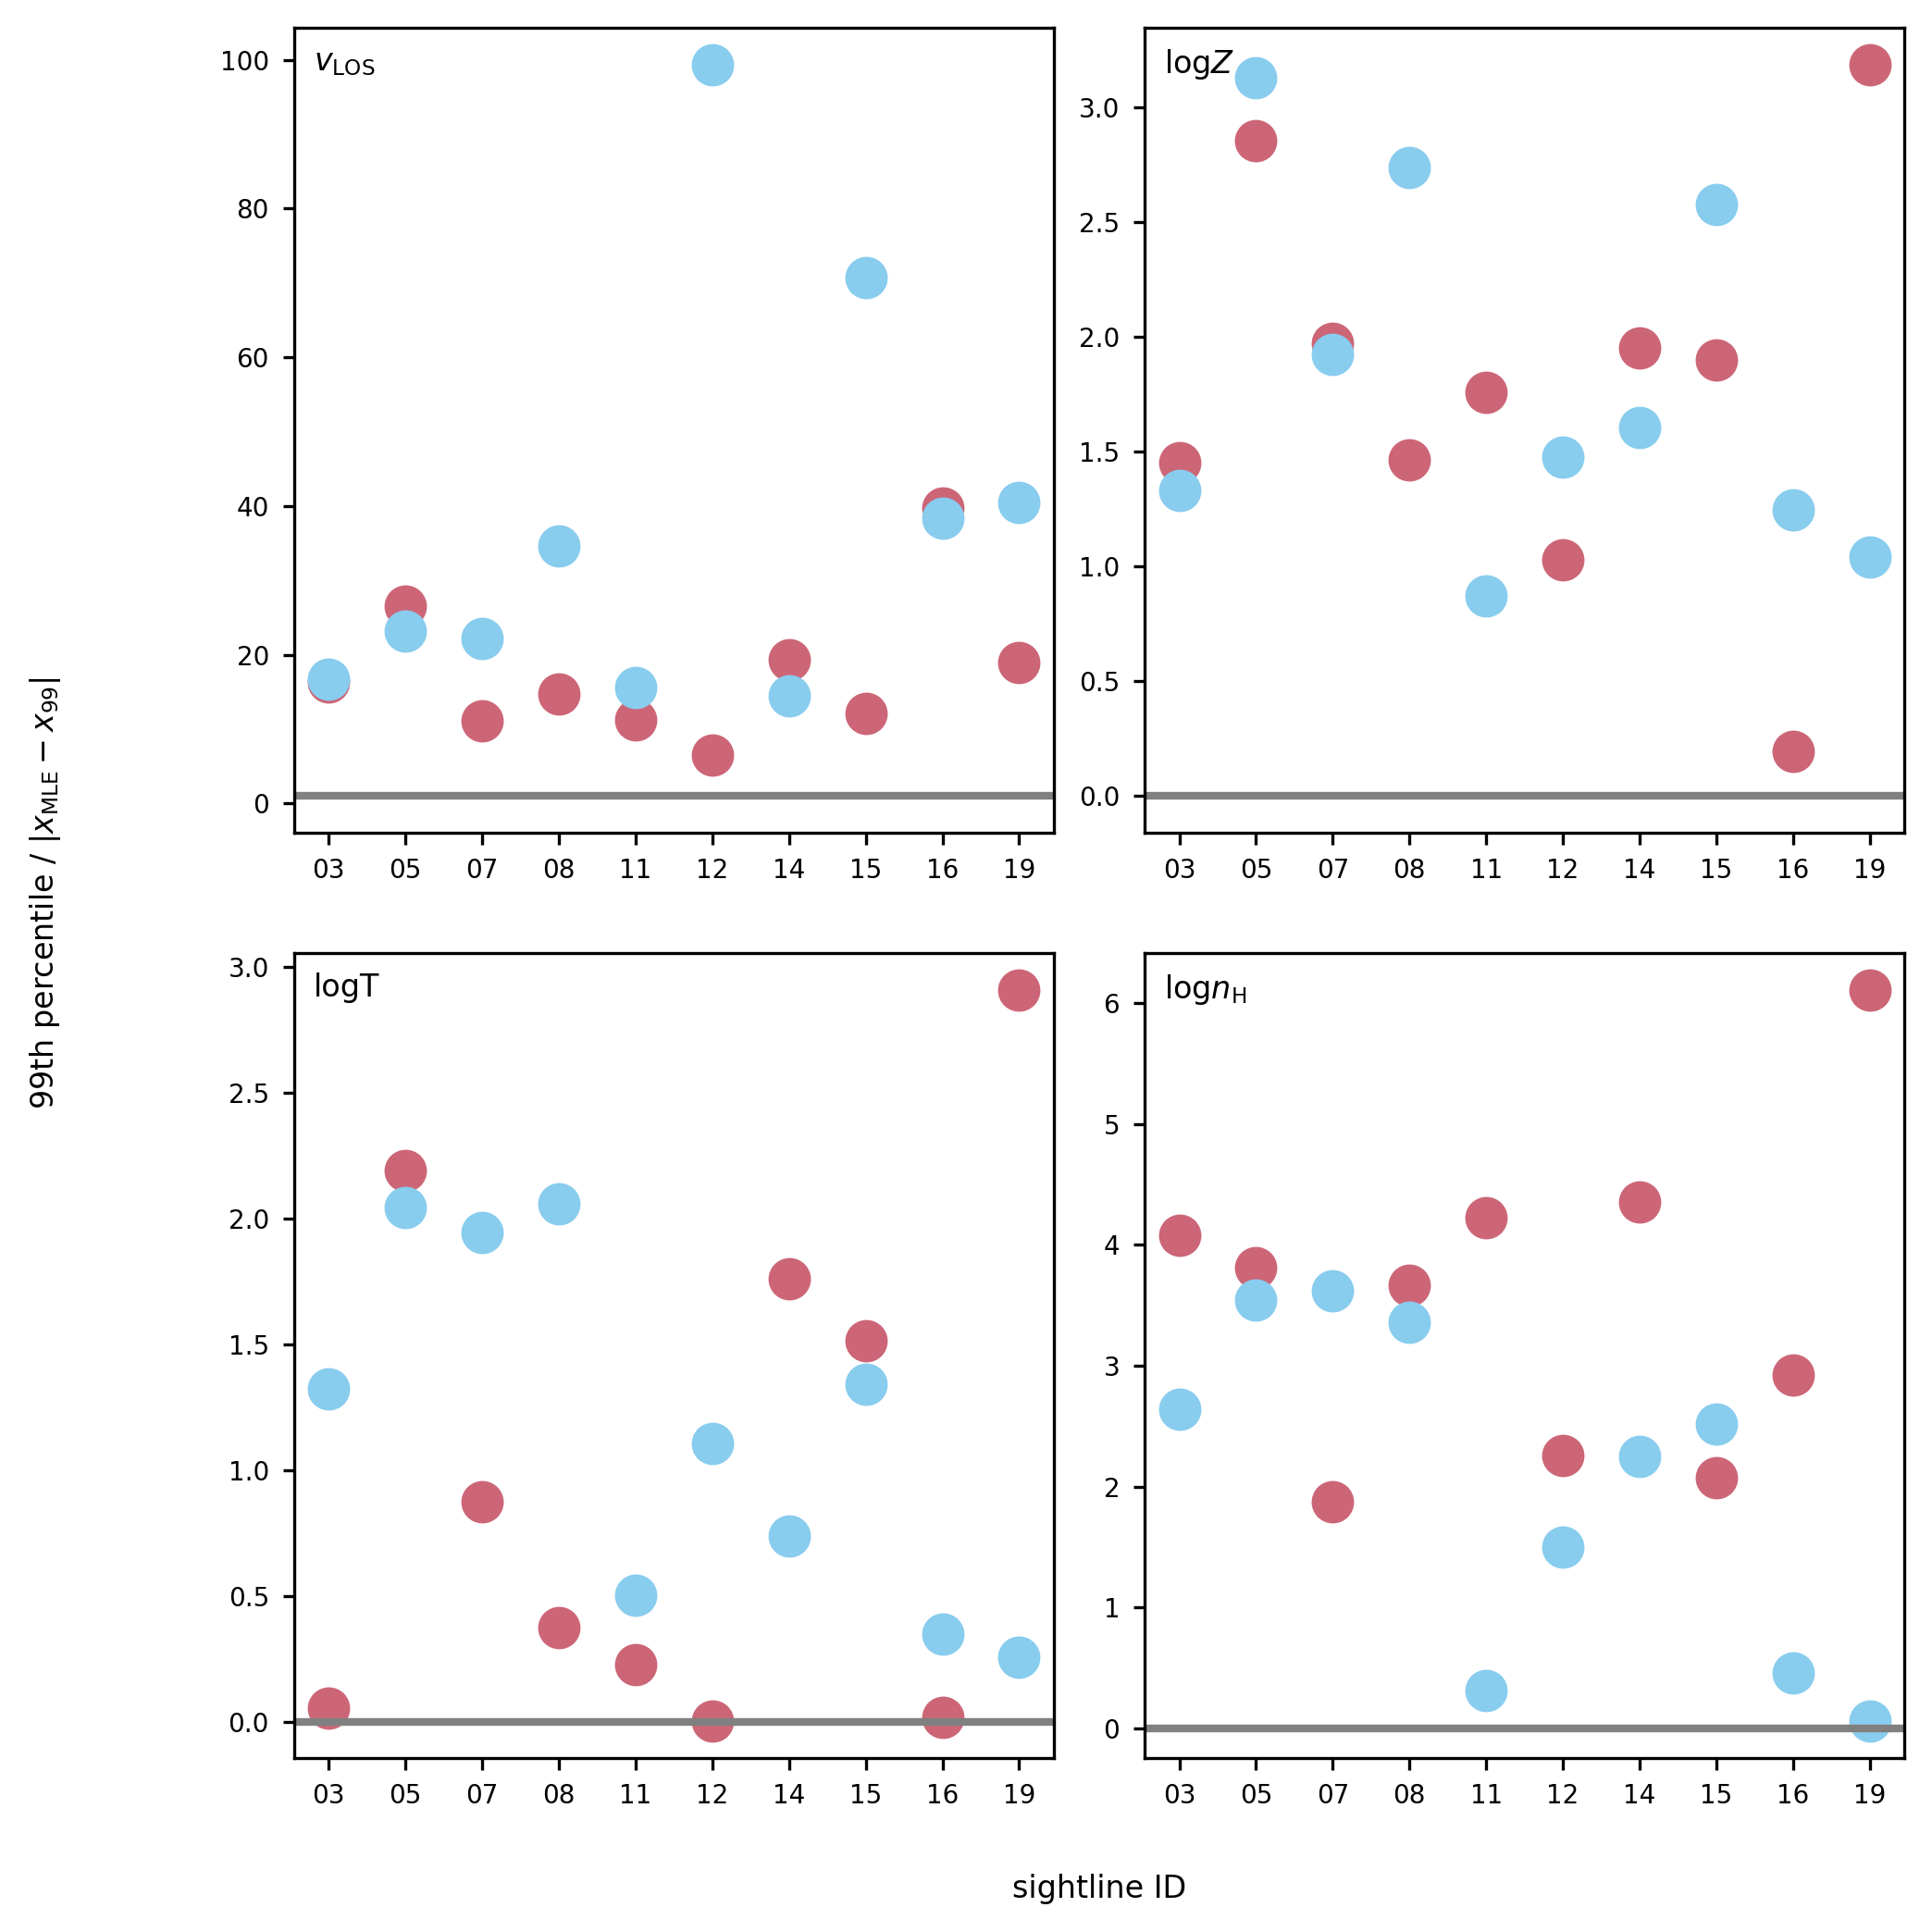

In [36]:
for fraction in pm['f_enclosed']:
    
    def get_widths( variation, prop_key ):
        
        pm = pms[variation]
        
        percentile = percentiles[pm['public_label']]['estimated'][prop_key][str(fraction)]['width'].array()
        d_between = distances_between[pm['public_label']][prop_key]['distance_to_enclose'][str(fraction)].array()
        
        if helpers.logscale[prop_key]:
            return percentile - d_between
        else:
            return percentile / d_between
    
    fig, main_ax, ax_dict = plot_metric( get_widths )
    
    for ax_key, ax in ax_dict.items():
        
        hline = 1
        
        if helpers.logscale[ax_key]:
            hline = np.log10( hline )
            
        ax.axhline( hline, color='0.5', )

    main_ax.set_xlabel( 'sightline ID', labelpad=30 )
    main_ax.set_ylabel( '{}'.format( int( fraction * 100 ) ) + r'th percentile / $\left| x_{\rm MLE} - x_{' + '{}'.format( int( fraction * 100 ) ) + r'} \right|$', labelpad=60 )

## Fraction enclosed

### % of likelihood to enclose

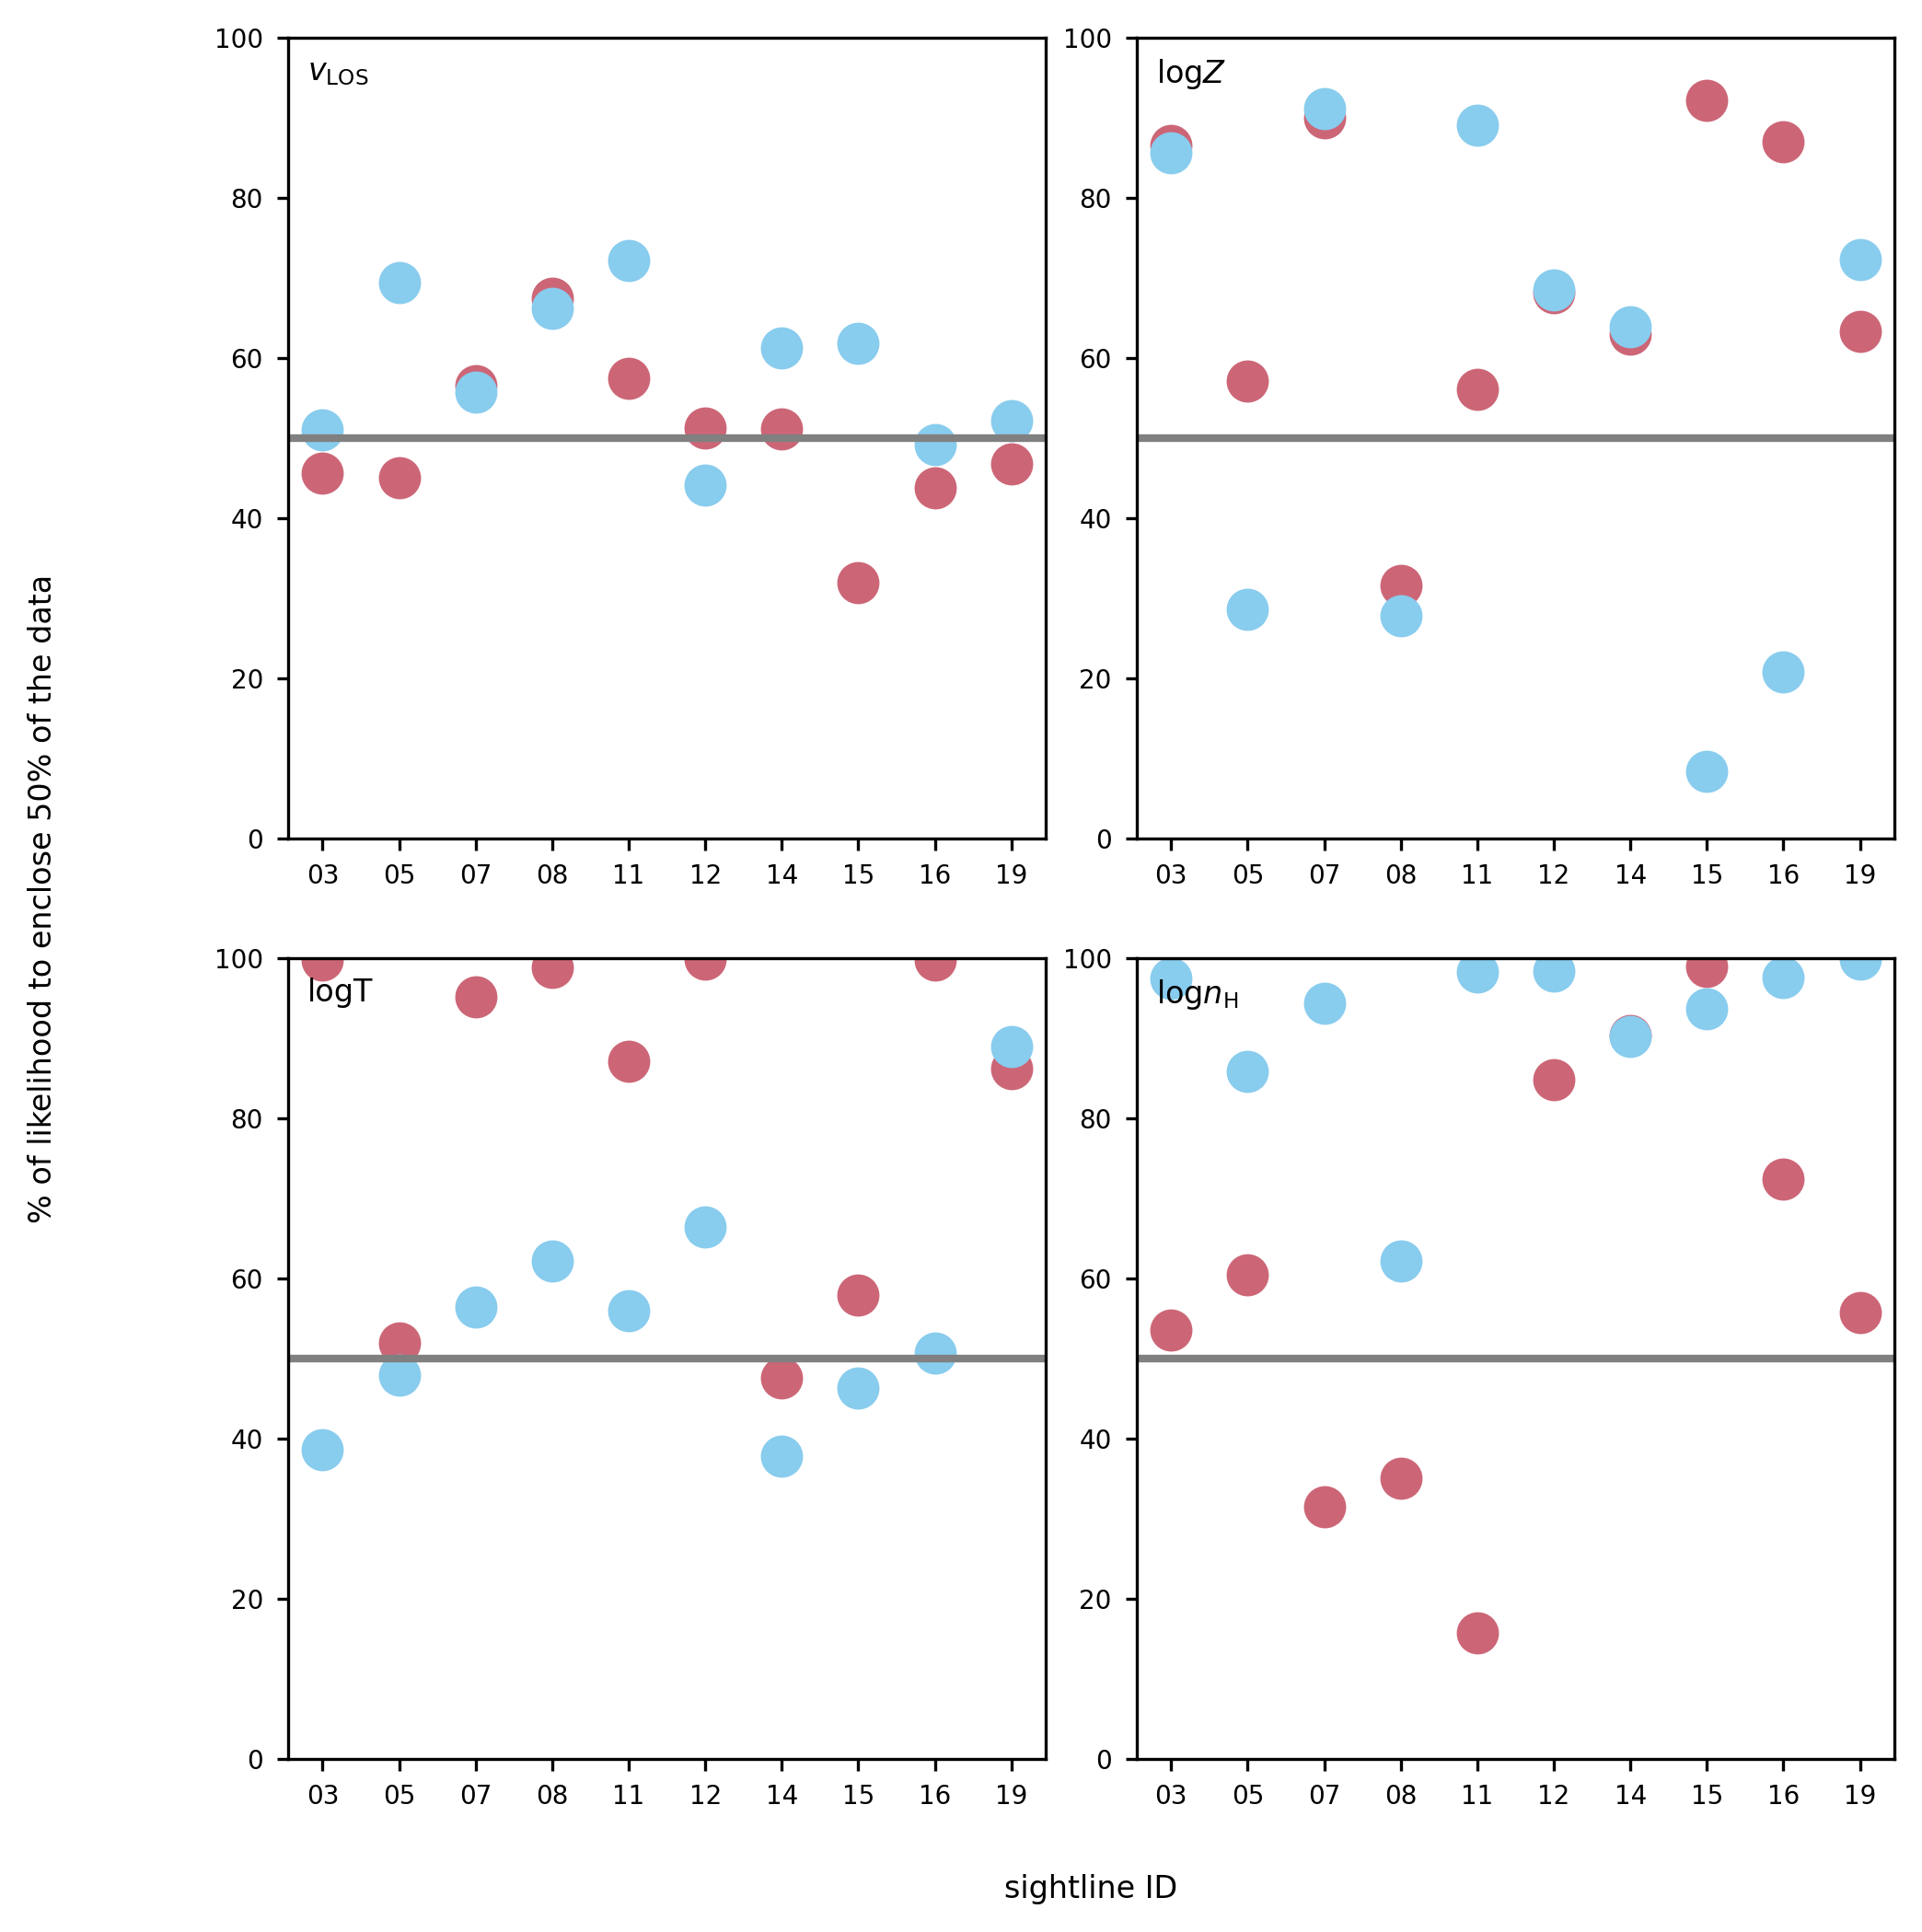

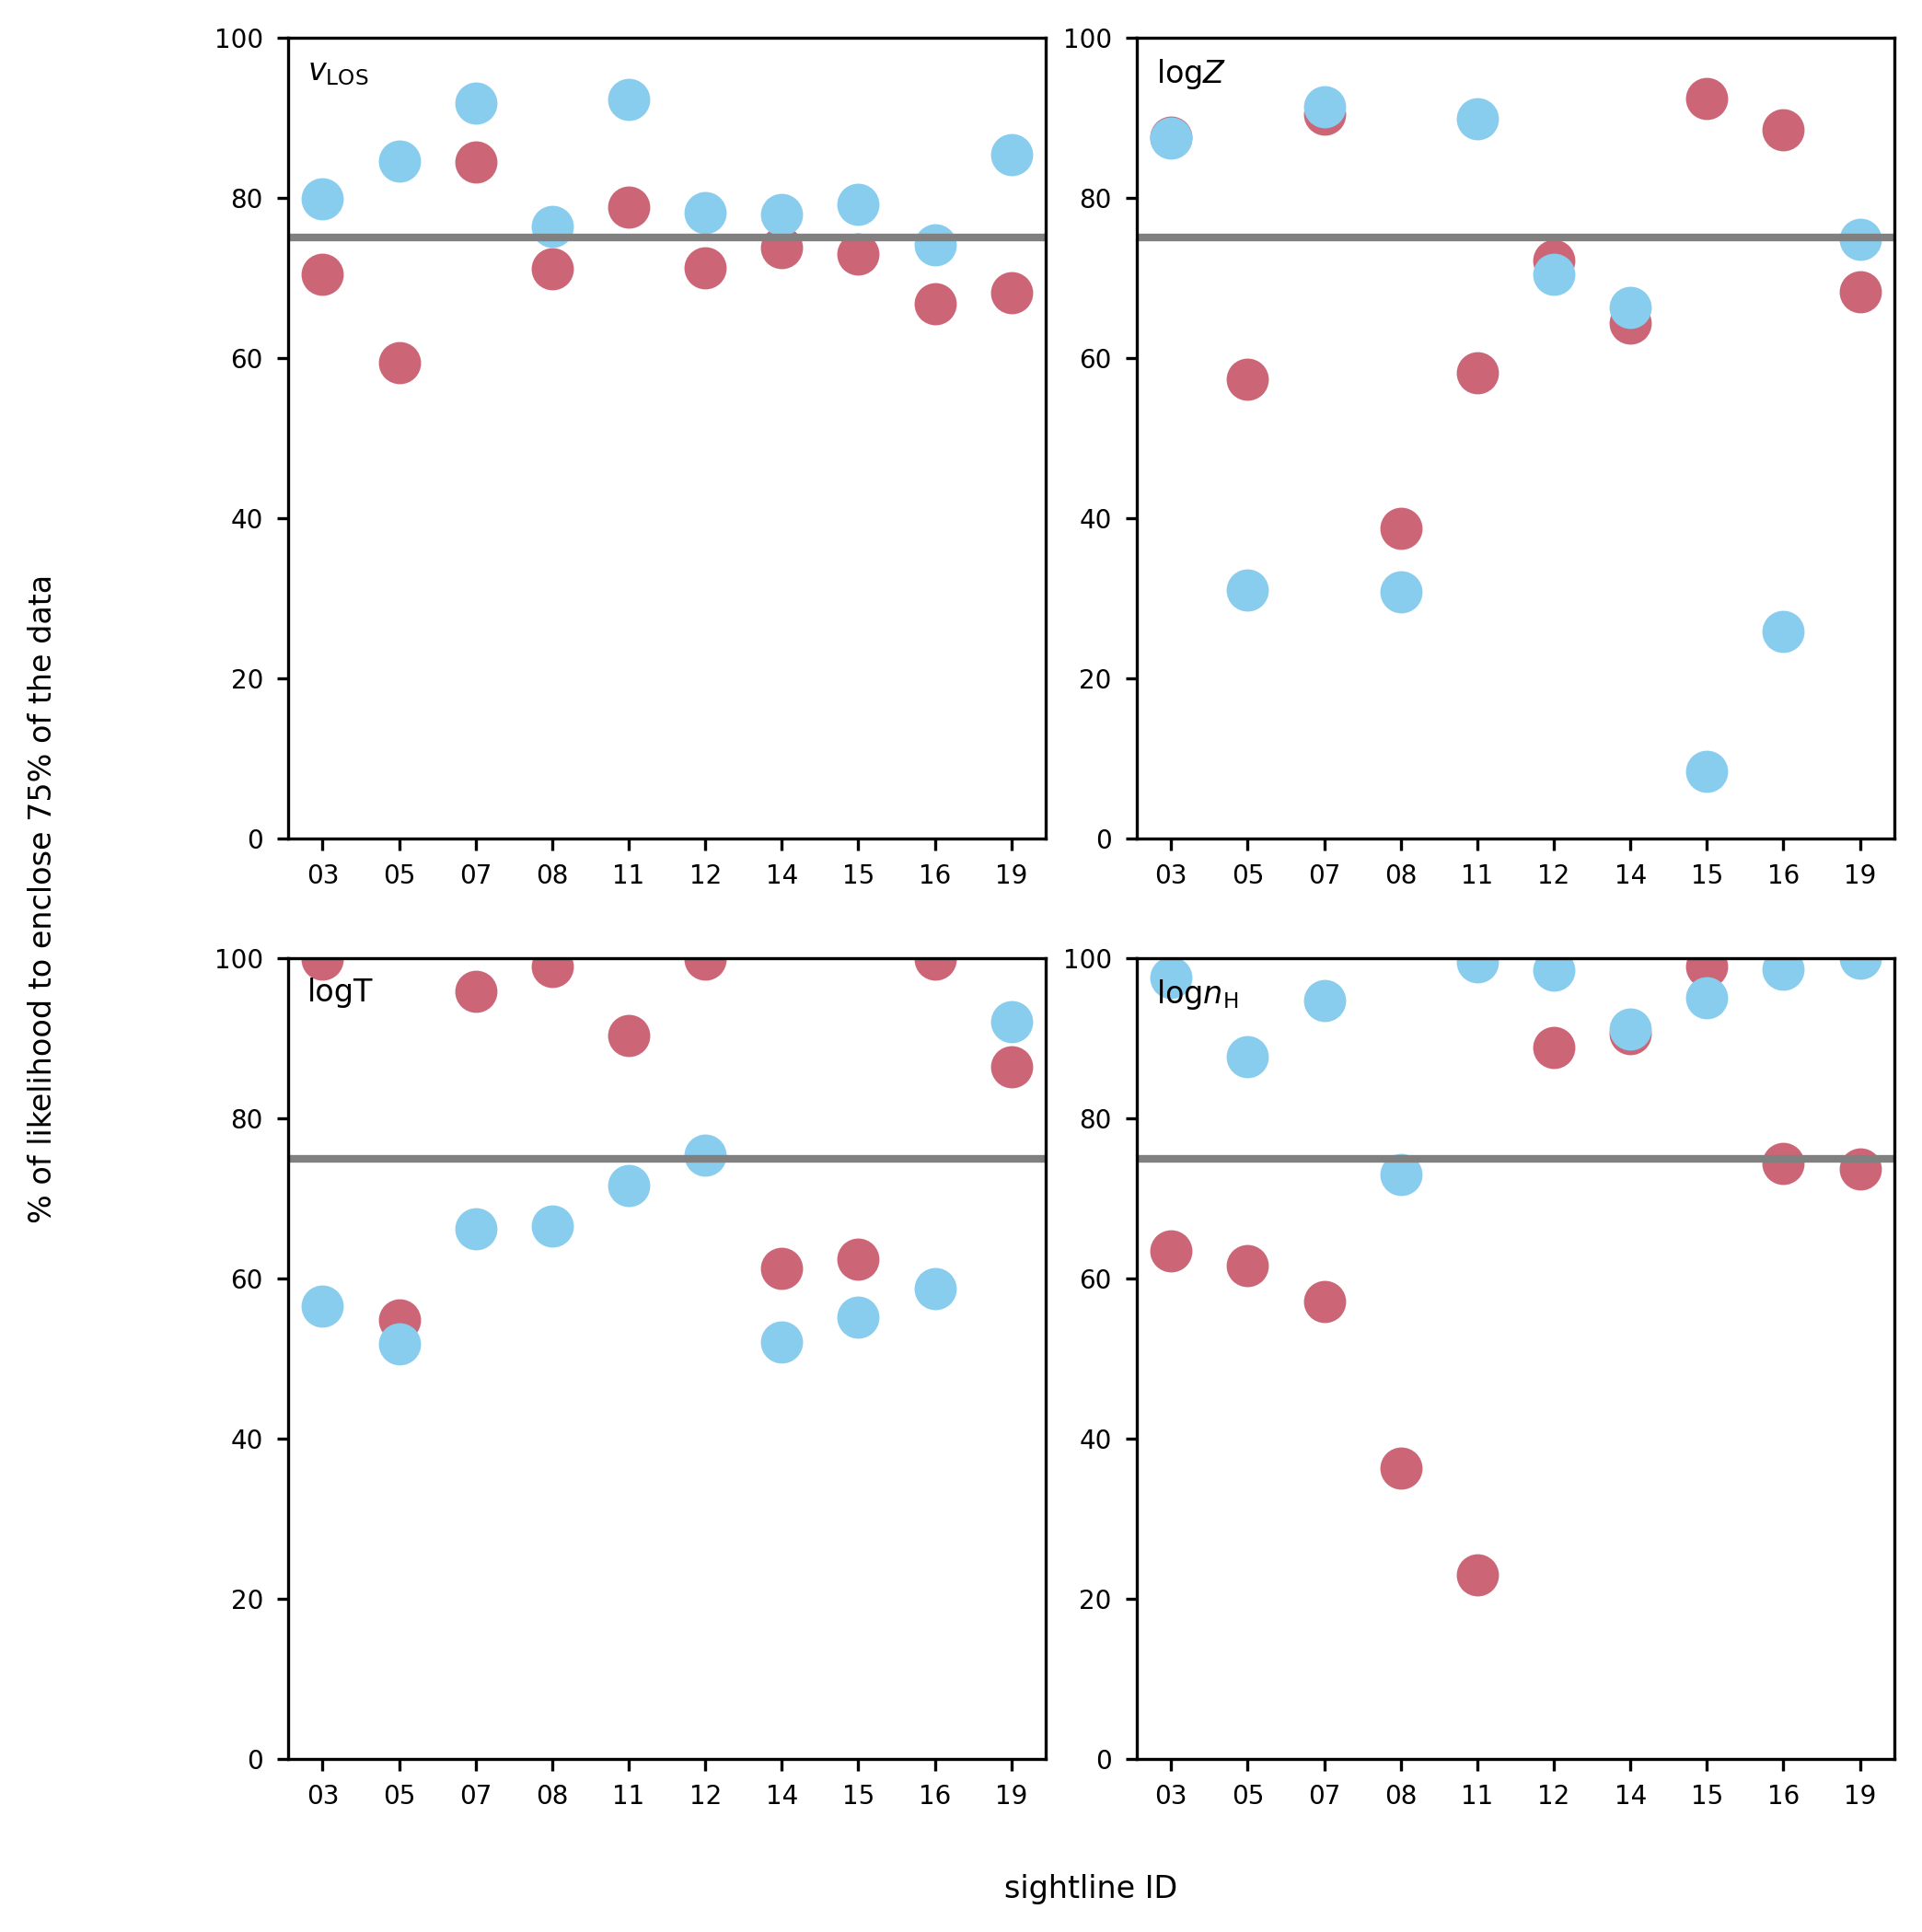

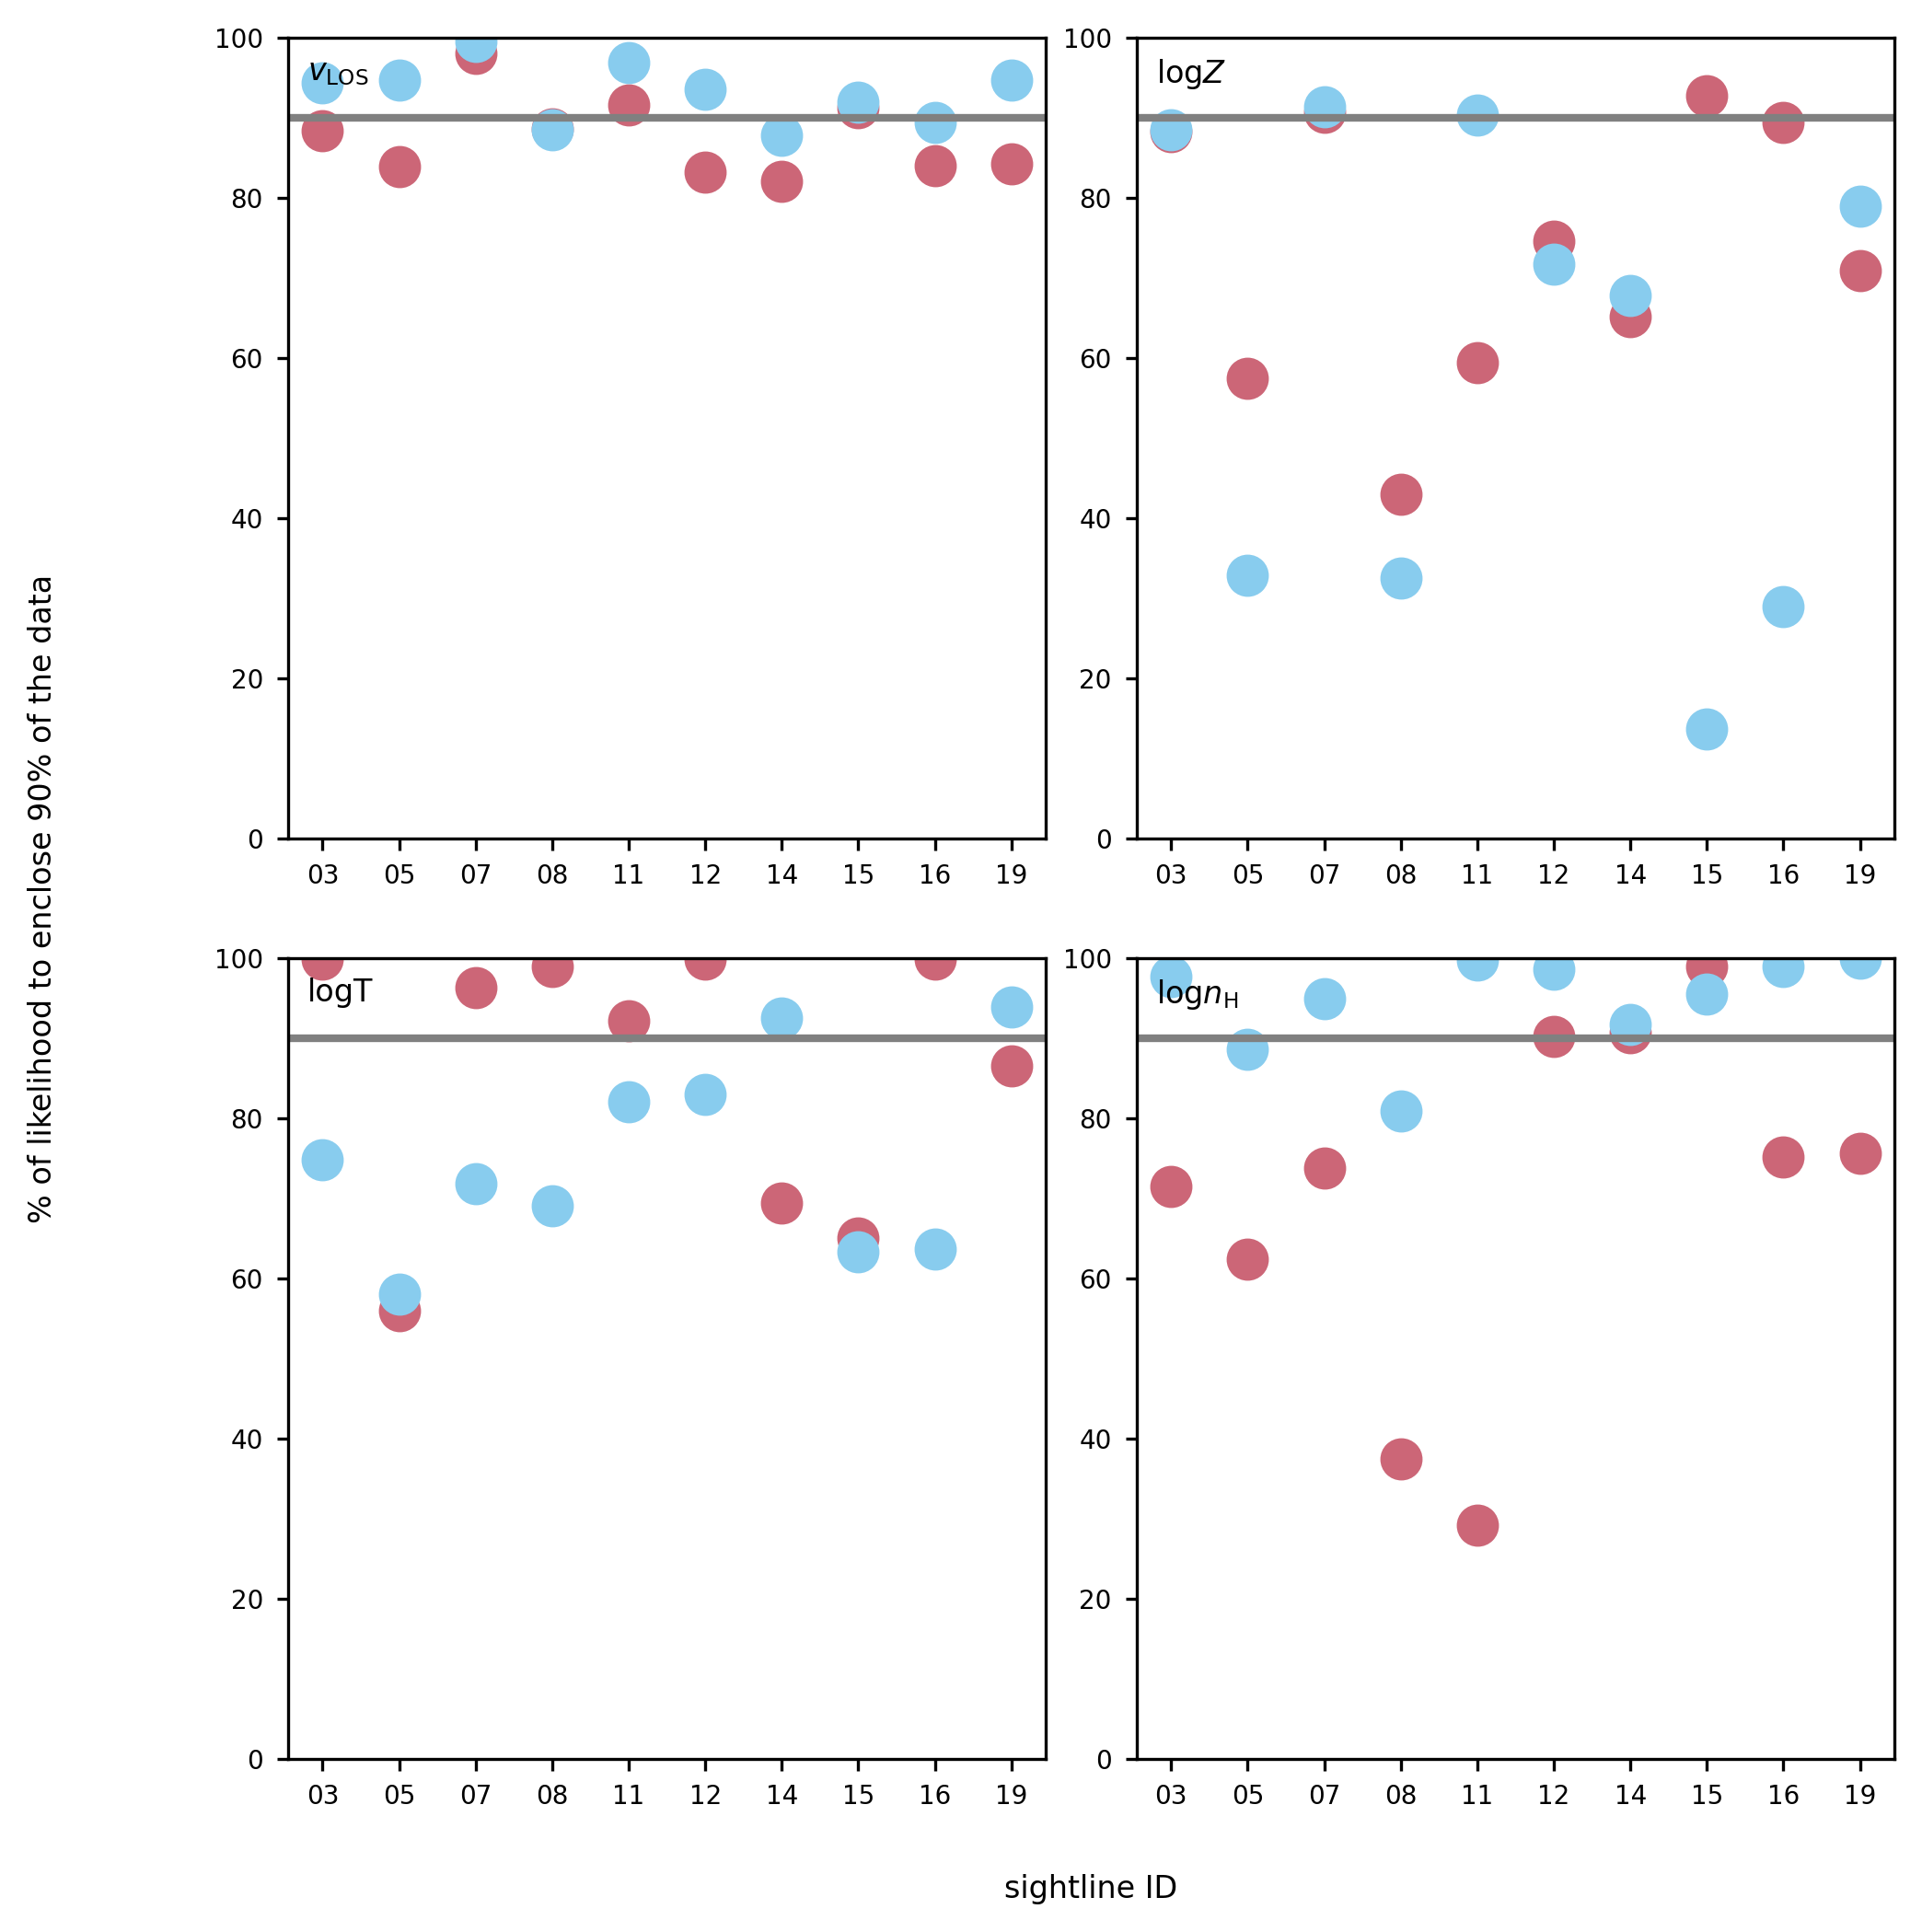

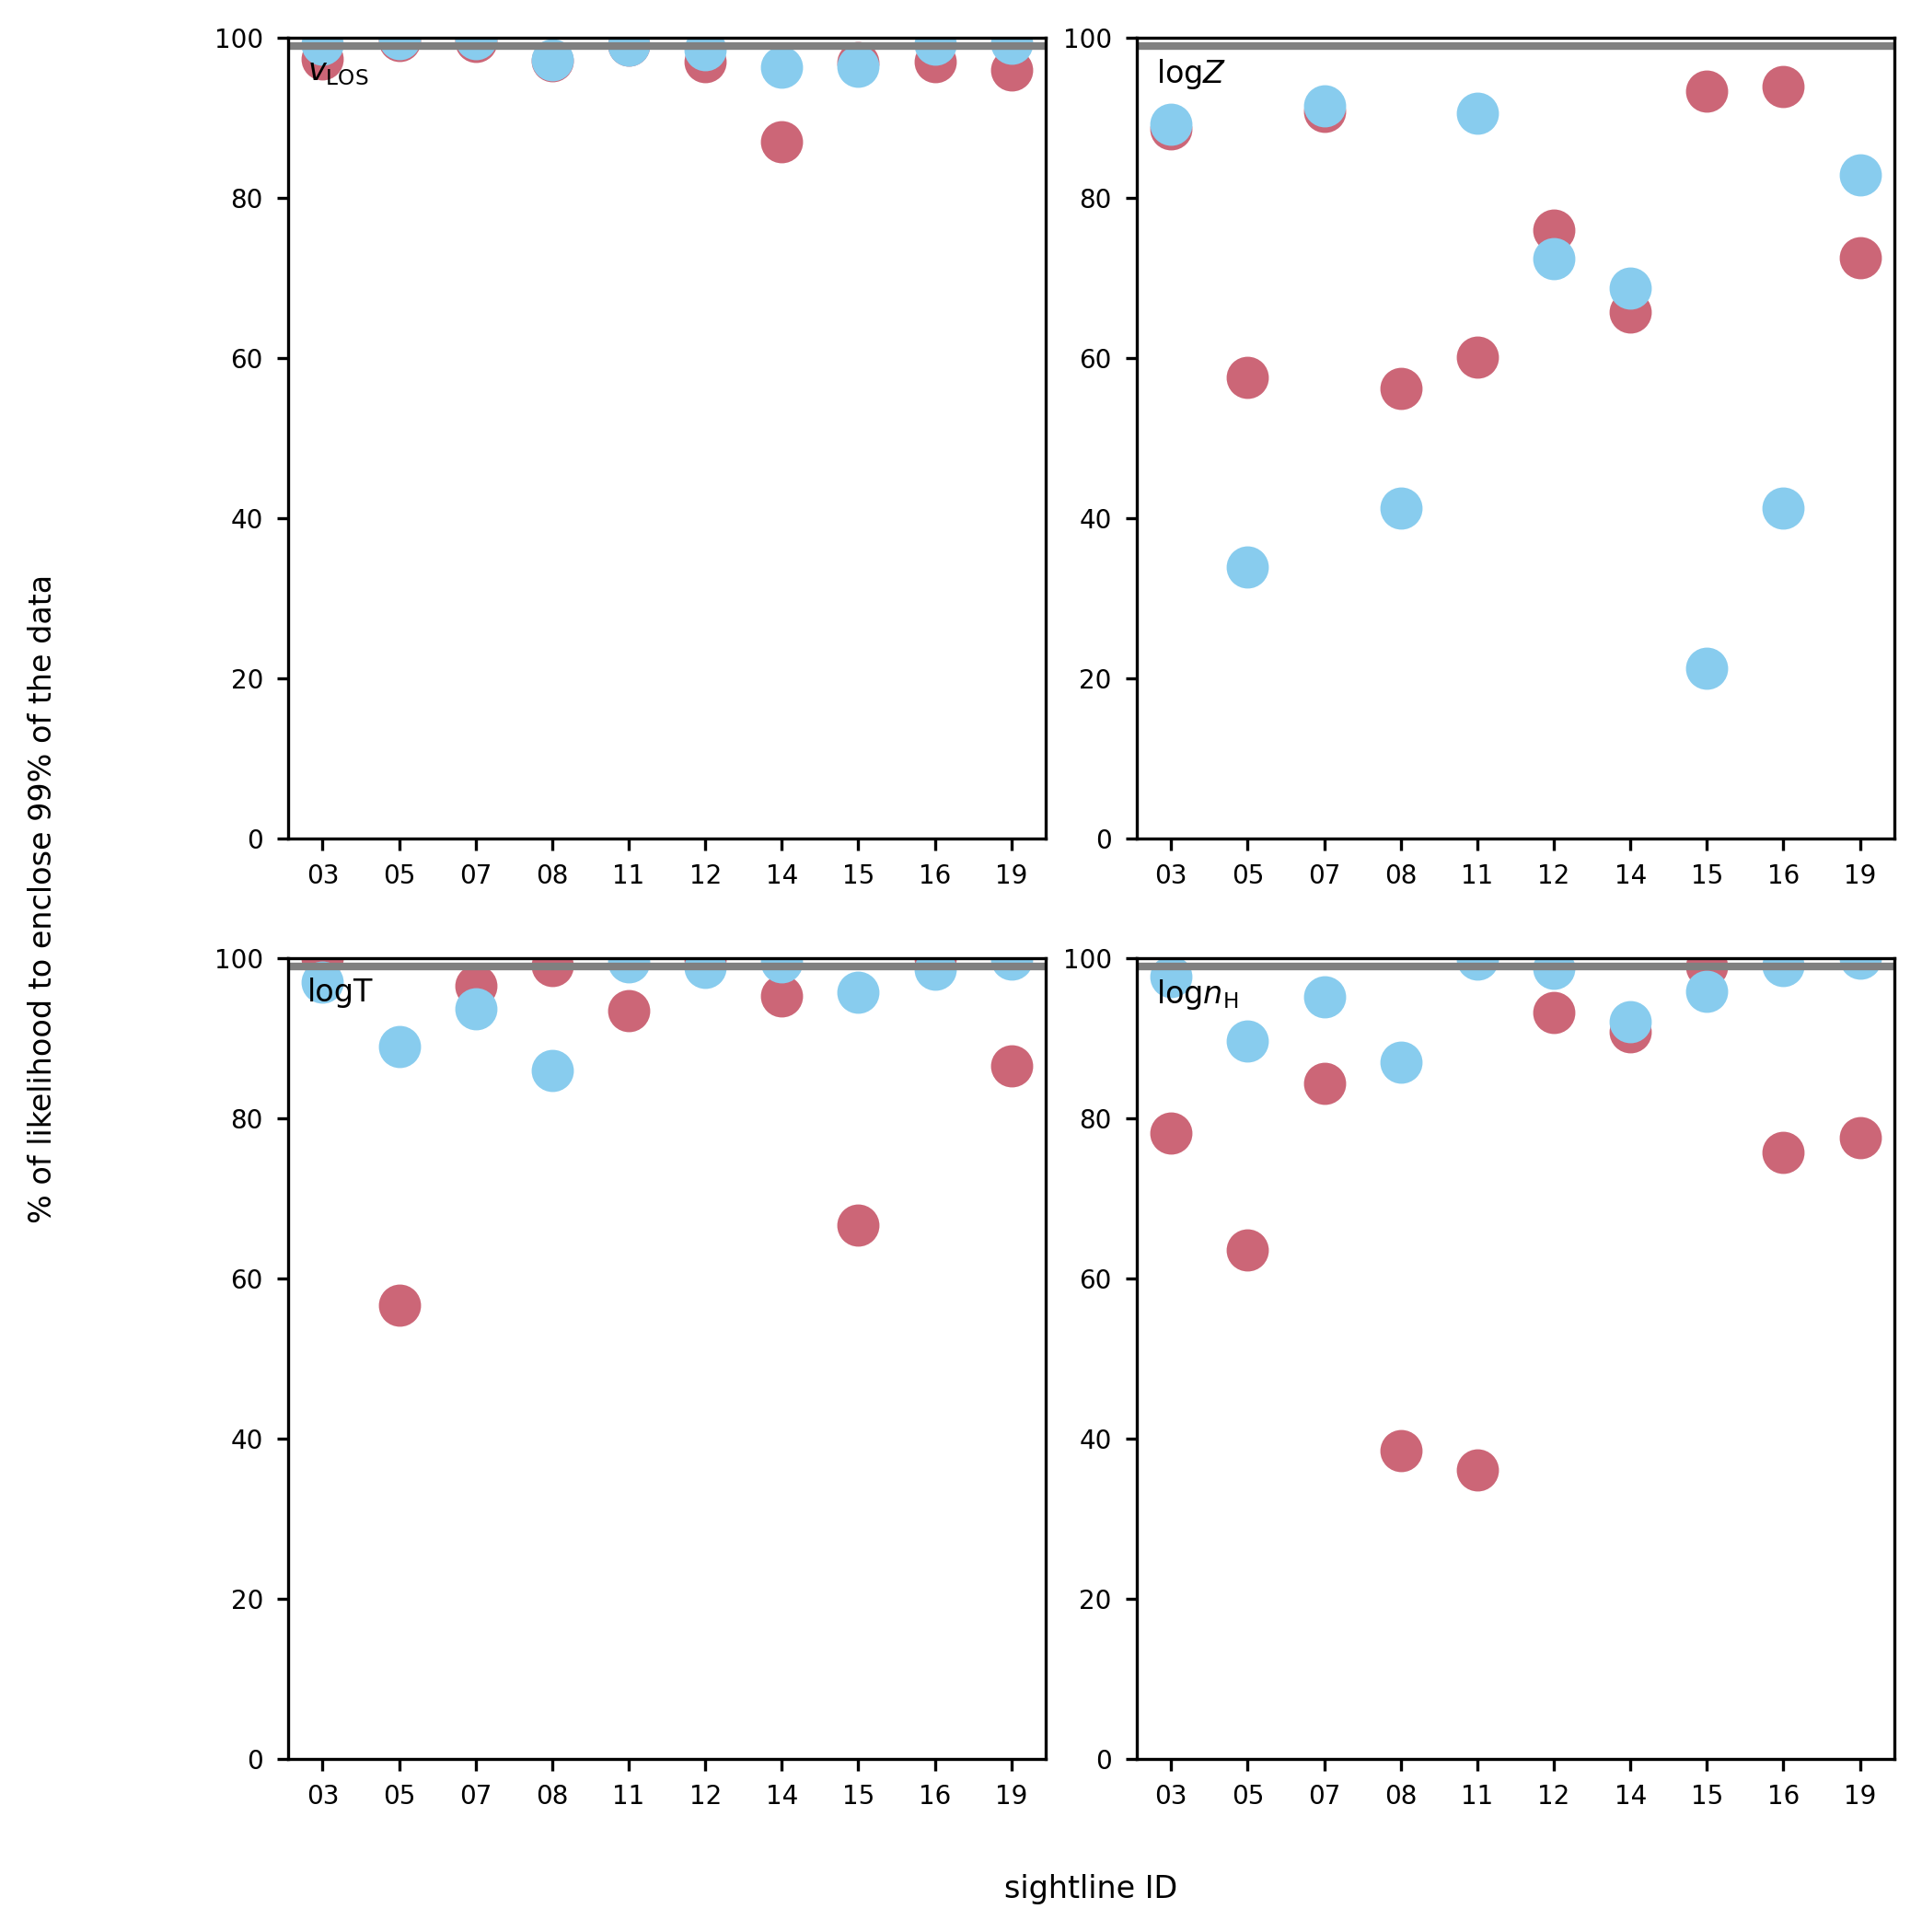

In [37]:
for fraction in pm['f_enclosed']:
    
    def get_ys( variation, prop_key ):
        
        pm = pms[variation]
        
        ys = f_estimated_to_enclose_f_data[pm['public_label']][prop_key][str(fraction)].array() * 100
        
        return ys
    
    fig, main_ax, ax_dict = plot_metric( get_ys )
    
    for ax_key, ax in ax_dict.items():
        
        ax.set_ylim( 0, 100 )
        
        hline = fraction * 100
            
        ax.axhline( hline, color='0.5', )

    main_ax.set_xlabel( 'sightline ID', labelpad=30 )
    main_ax.set_ylabel( '% of likelihood to enclose {}% of the data'.format( int( fraction * 100 ) ), labelpad=60 )

### % of data enclosed

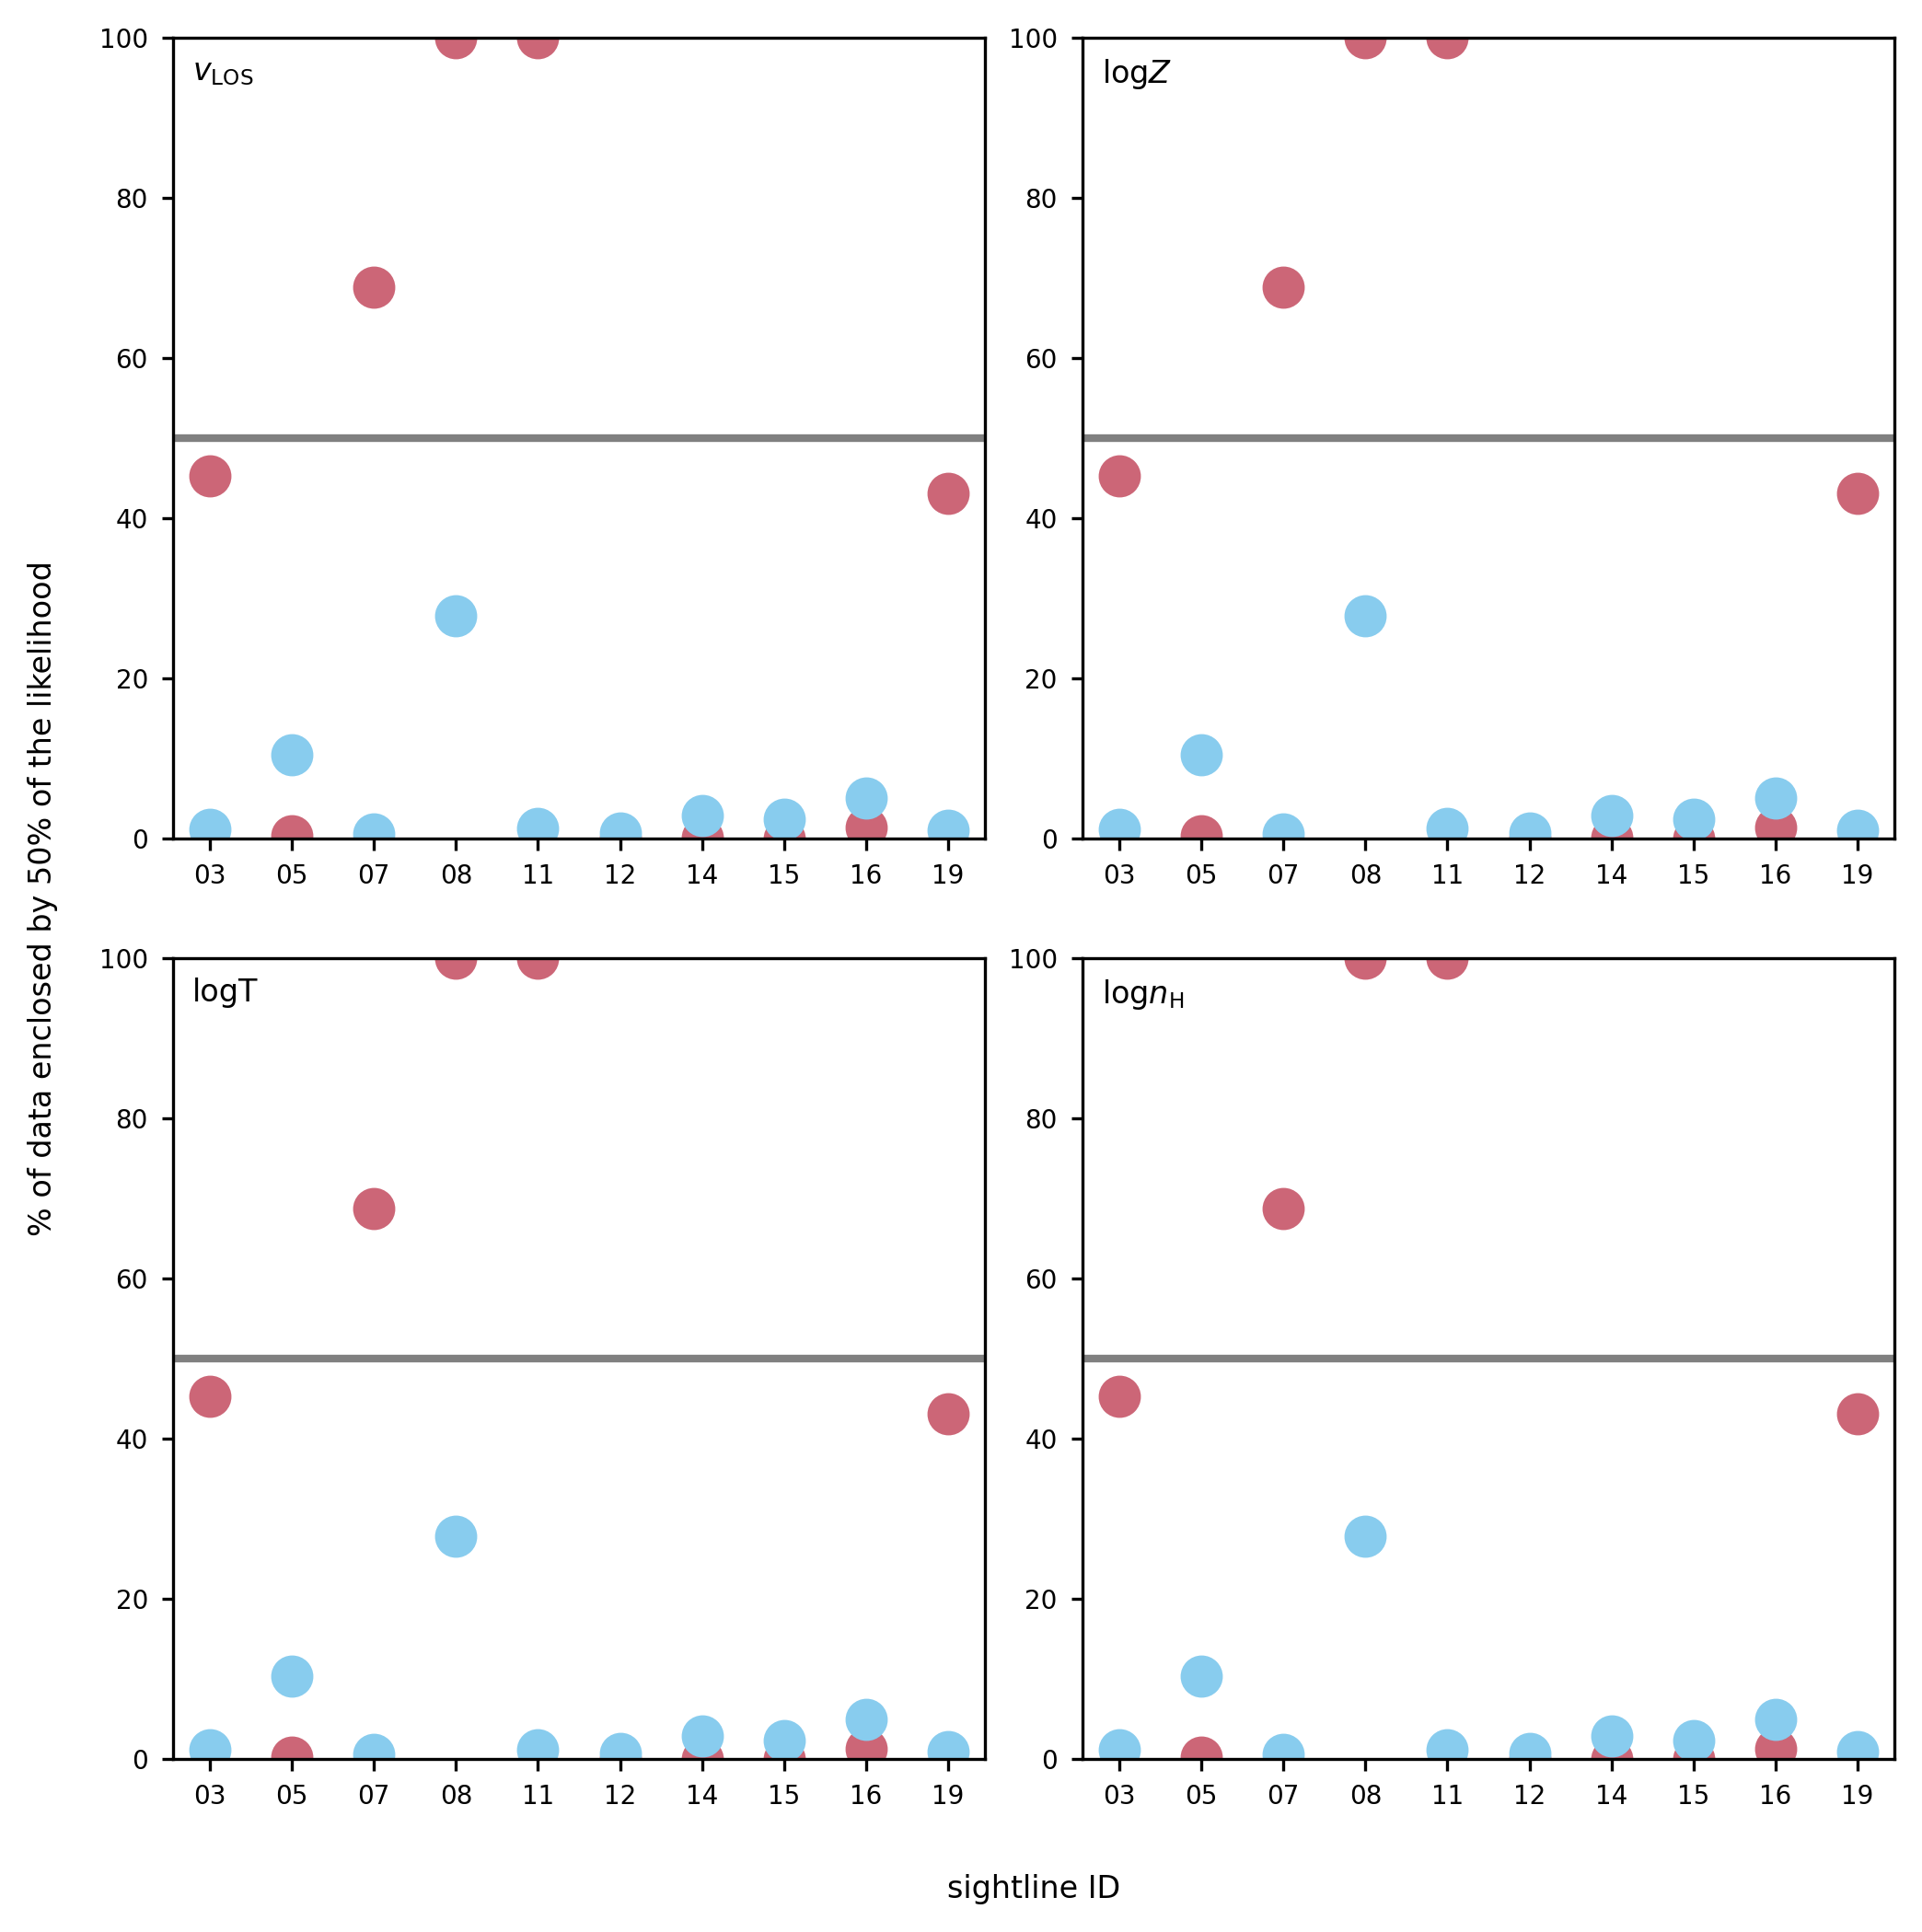

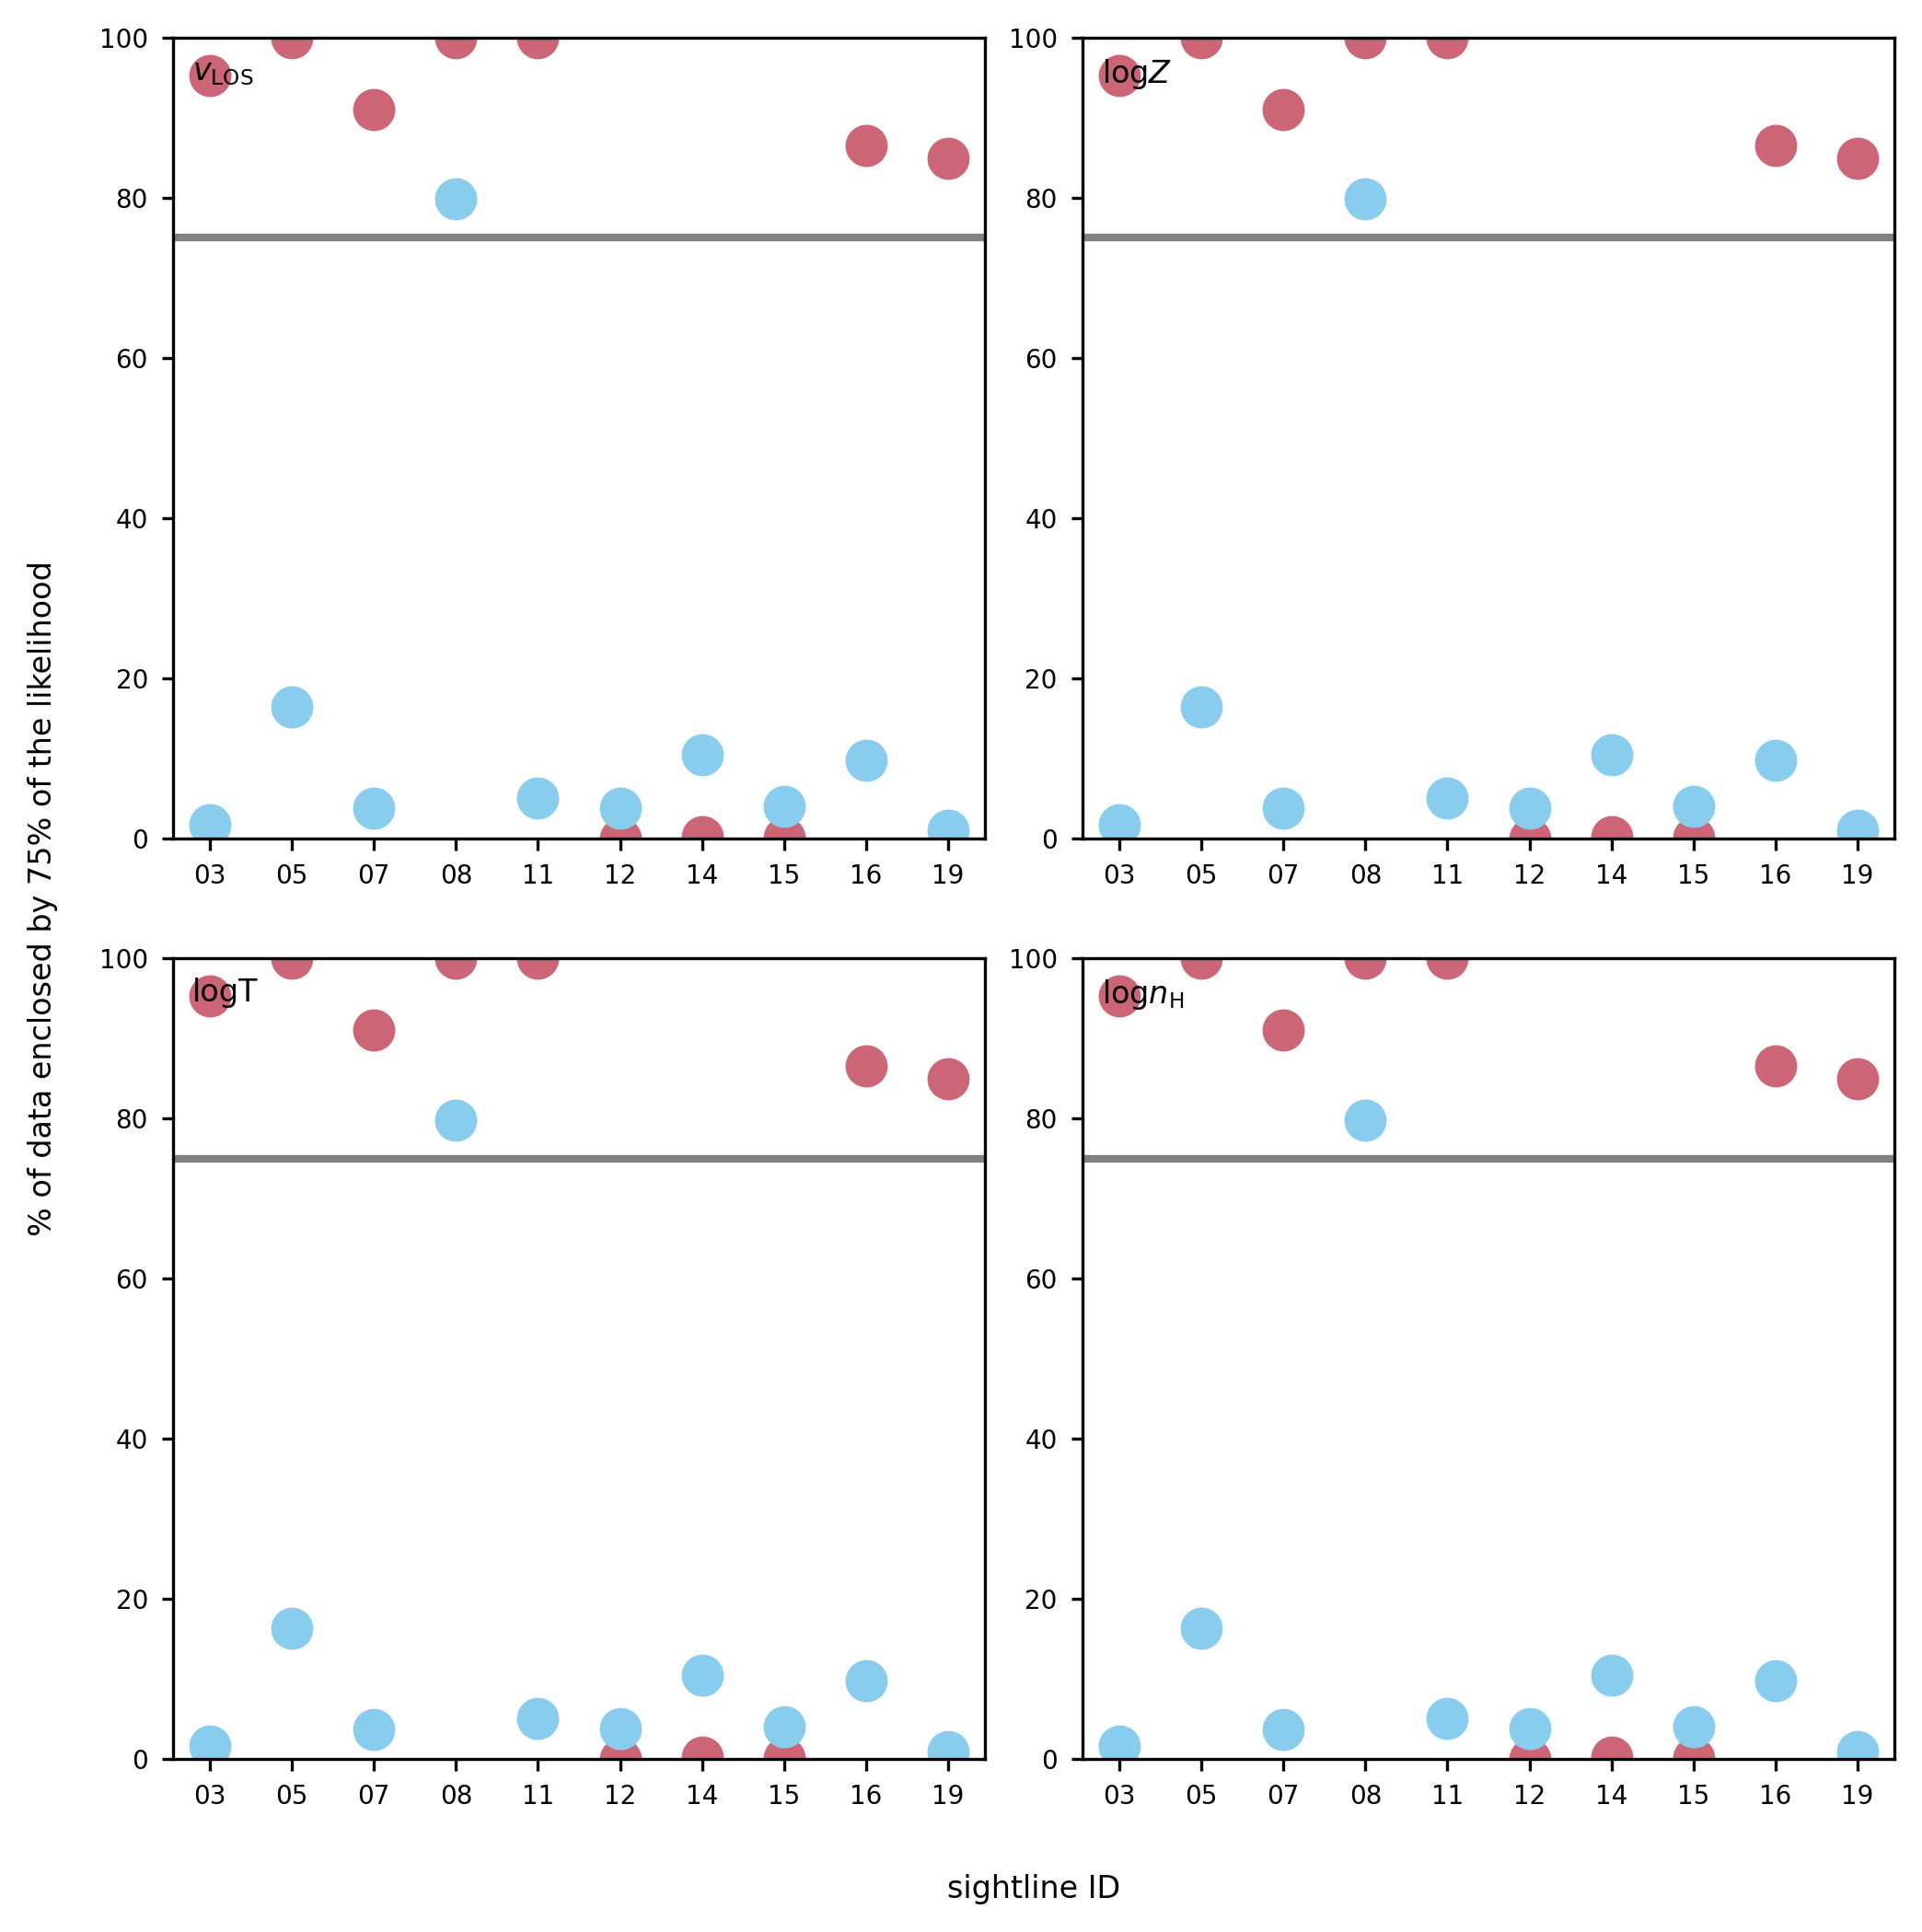

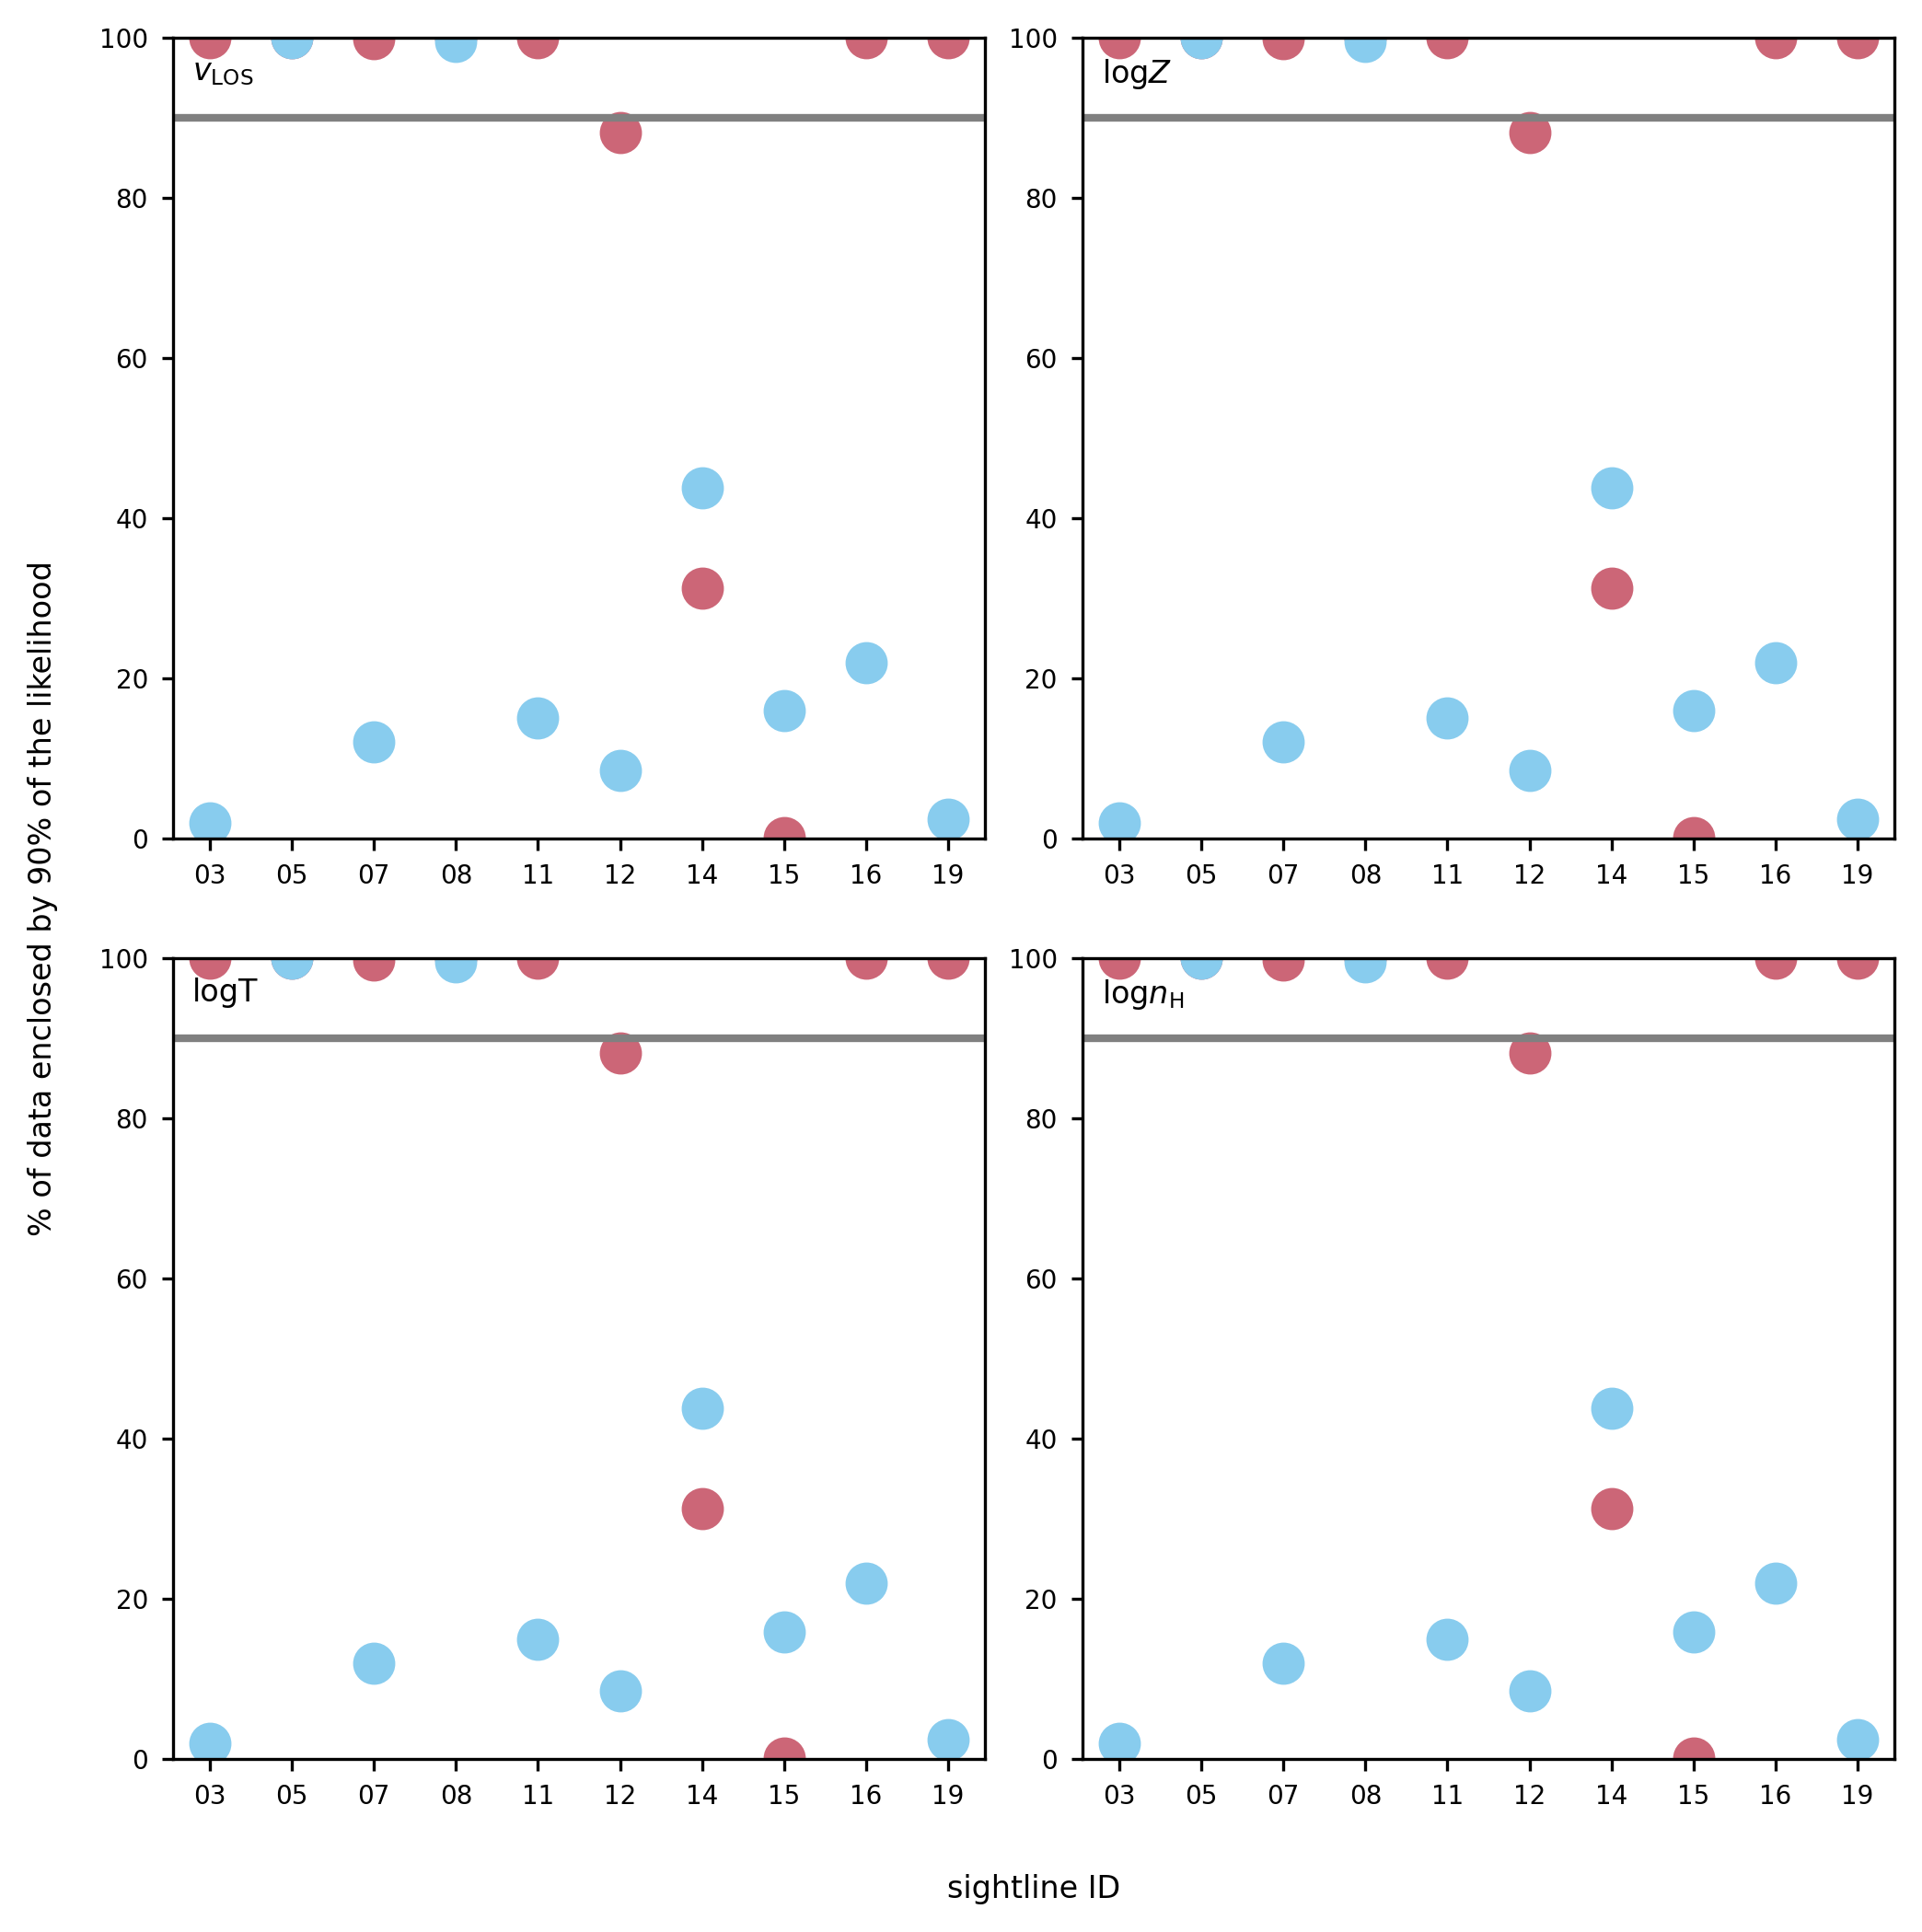

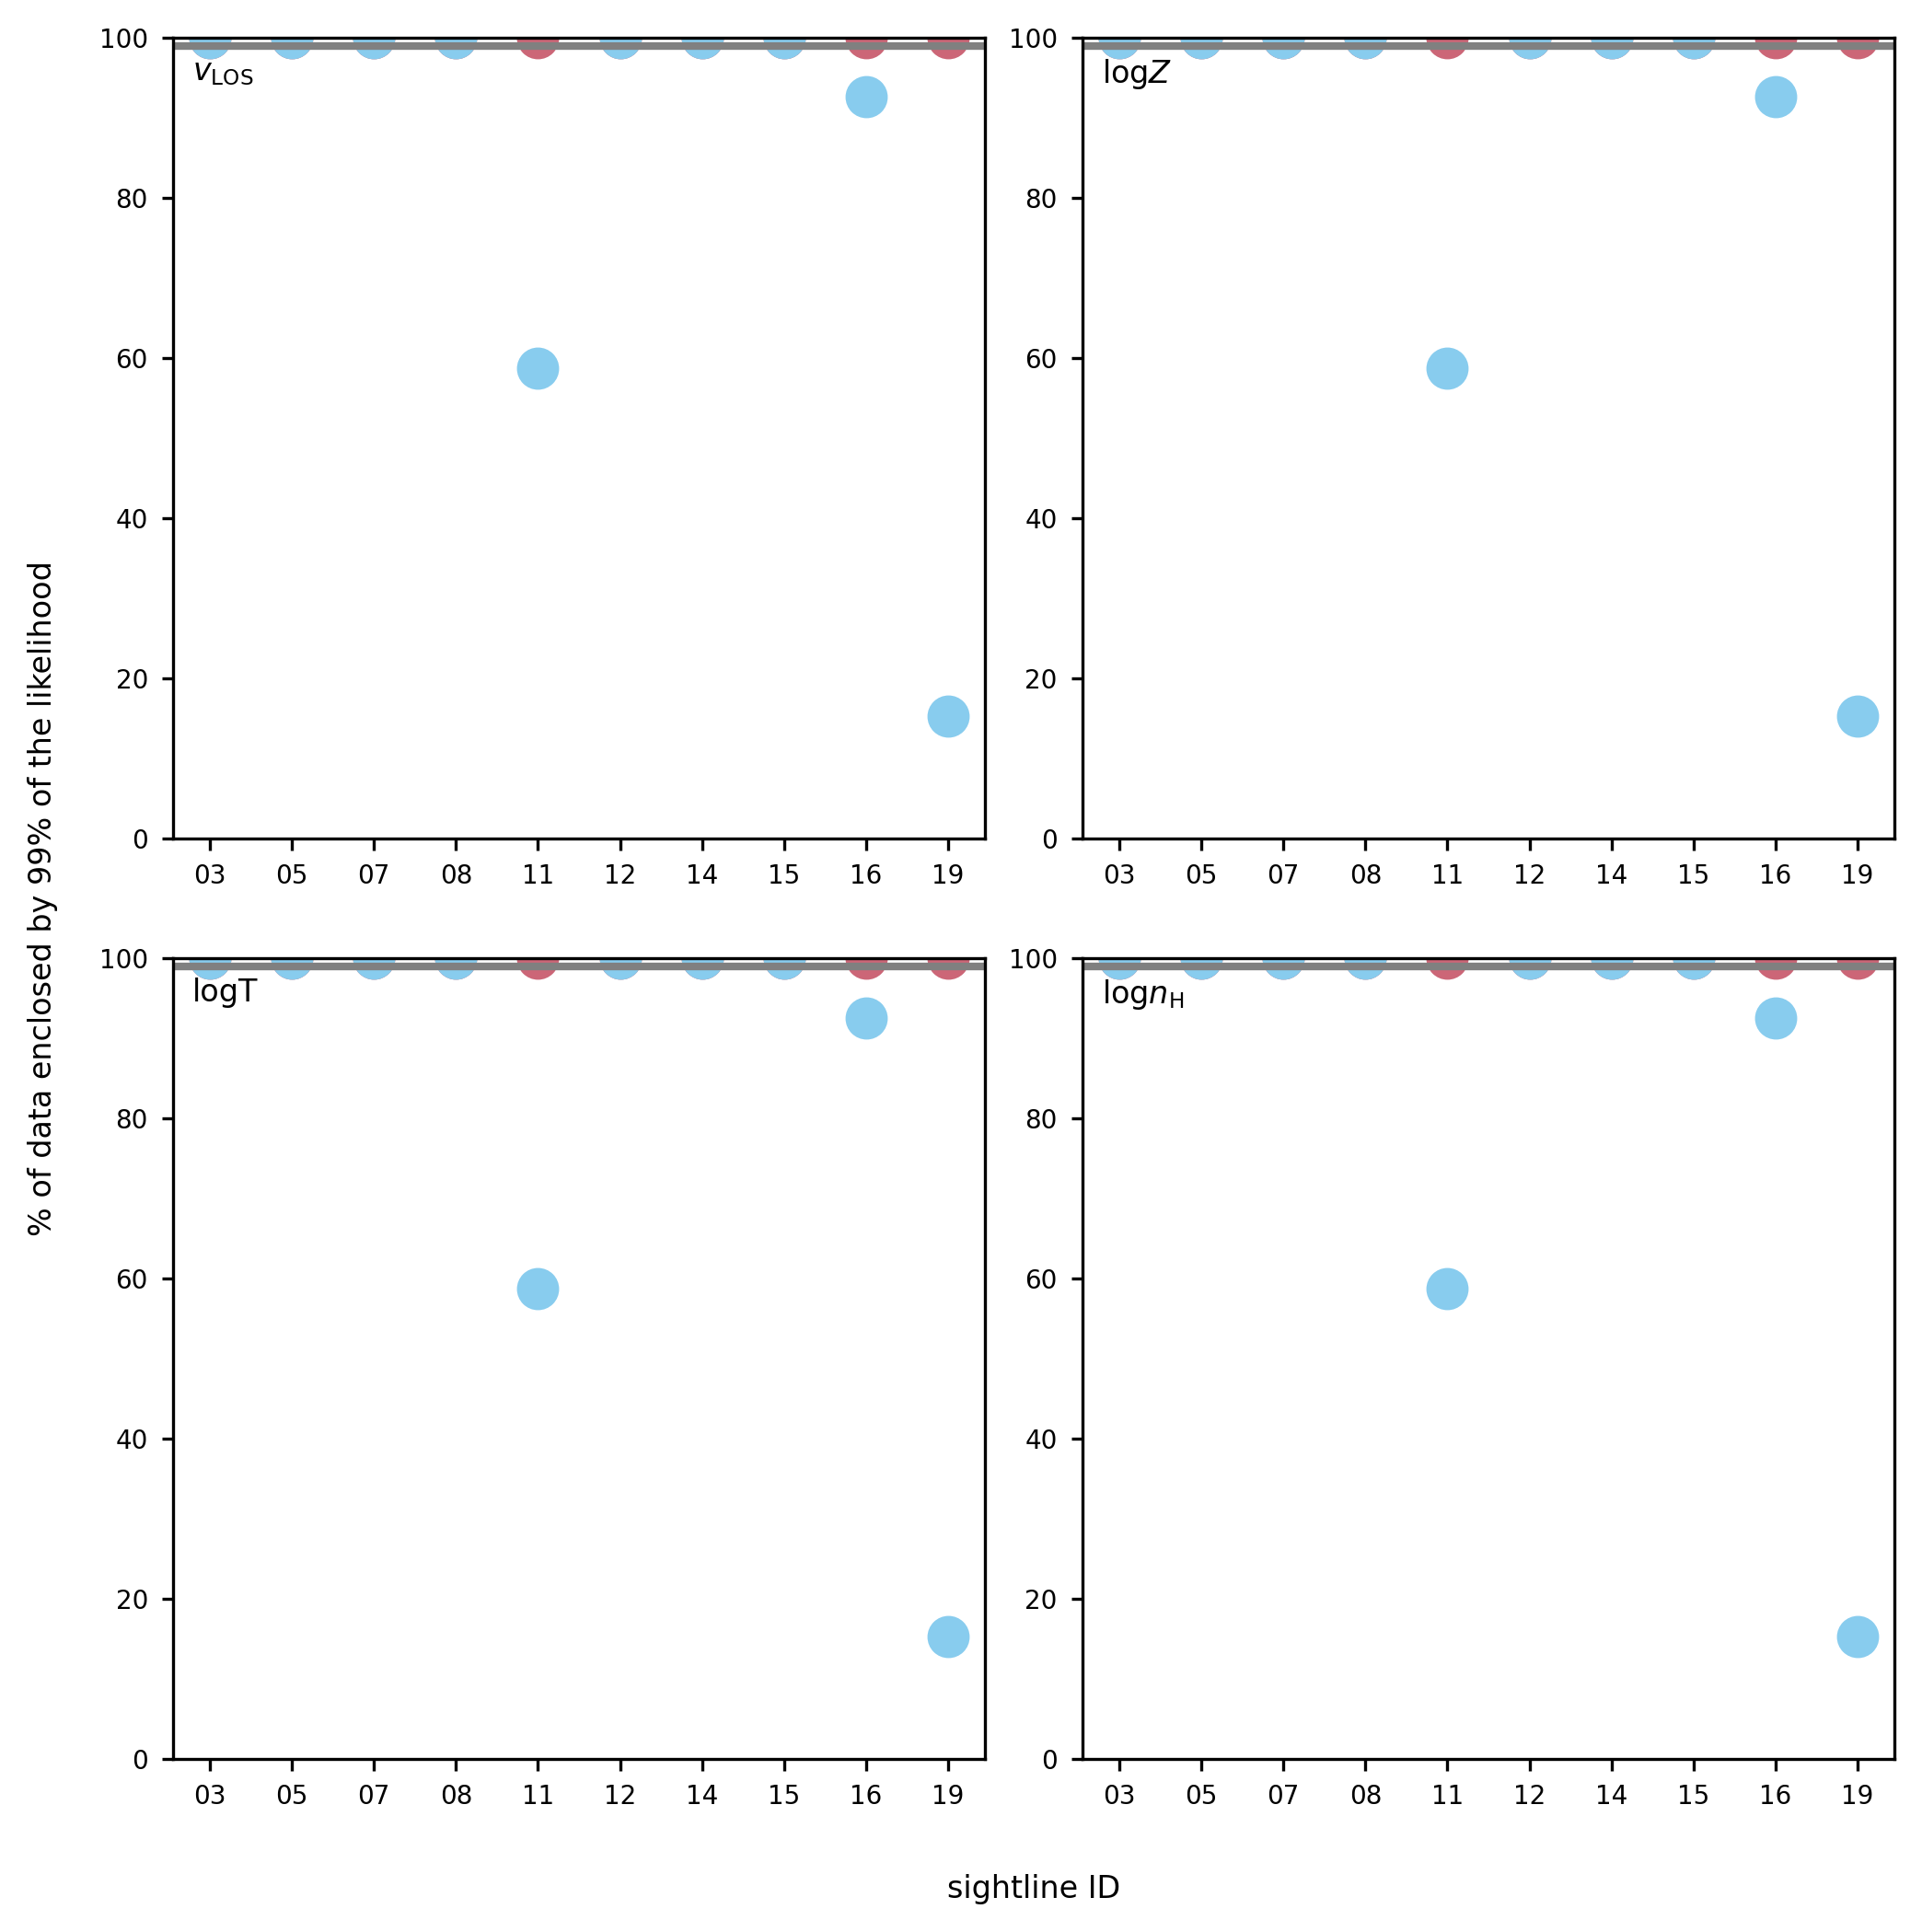

In [38]:
for fraction in pm['f_enclosed']:
    
    def get_ys( variation, prop_key ):
        
        pm = pms[variation]
        
        ys = f_data_enclosed_by_f_estimated[pm['public_label']][ax_key][str(fraction)].array() * 100
        
        return ys
    
    fig, main_ax, ax_dict = plot_metric( get_ys )
    
    for ax_key, ax in ax_dict.items():
        
        ax.set_ylim( 0, 100 )
        
        hline = fraction * 100
            
        ax.axhline( hline, color='0.5', )

    main_ax.set_xlabel( 'sightline ID', labelpad=30 )
    main_ax.set_ylabel( '% of data enclosed by {}% of the likelihood'.format( int( fraction * 100 ) ), labelpad=30 )


## Correlation Coefficients

     100%|██████████| 4/4 [00:00<00:00, 274.87it/s]
/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_18276/2655512931.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig( save_fp, bbox_inches='tight' )


Saving figure to /Users/zhafen/drafts/cgm_modeling_challenge_paper/figures/sample2/correlations.pdf


/var/folders/43/wy_ws5nx3830gqhfw05n4yyc0000gn/T/ipykernel_18276/2655512931.py:115: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig( save_fp, bbox_inches='tight' )
/Users/zhafen/miniconda3/envs/cgm_modeling_challenge/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


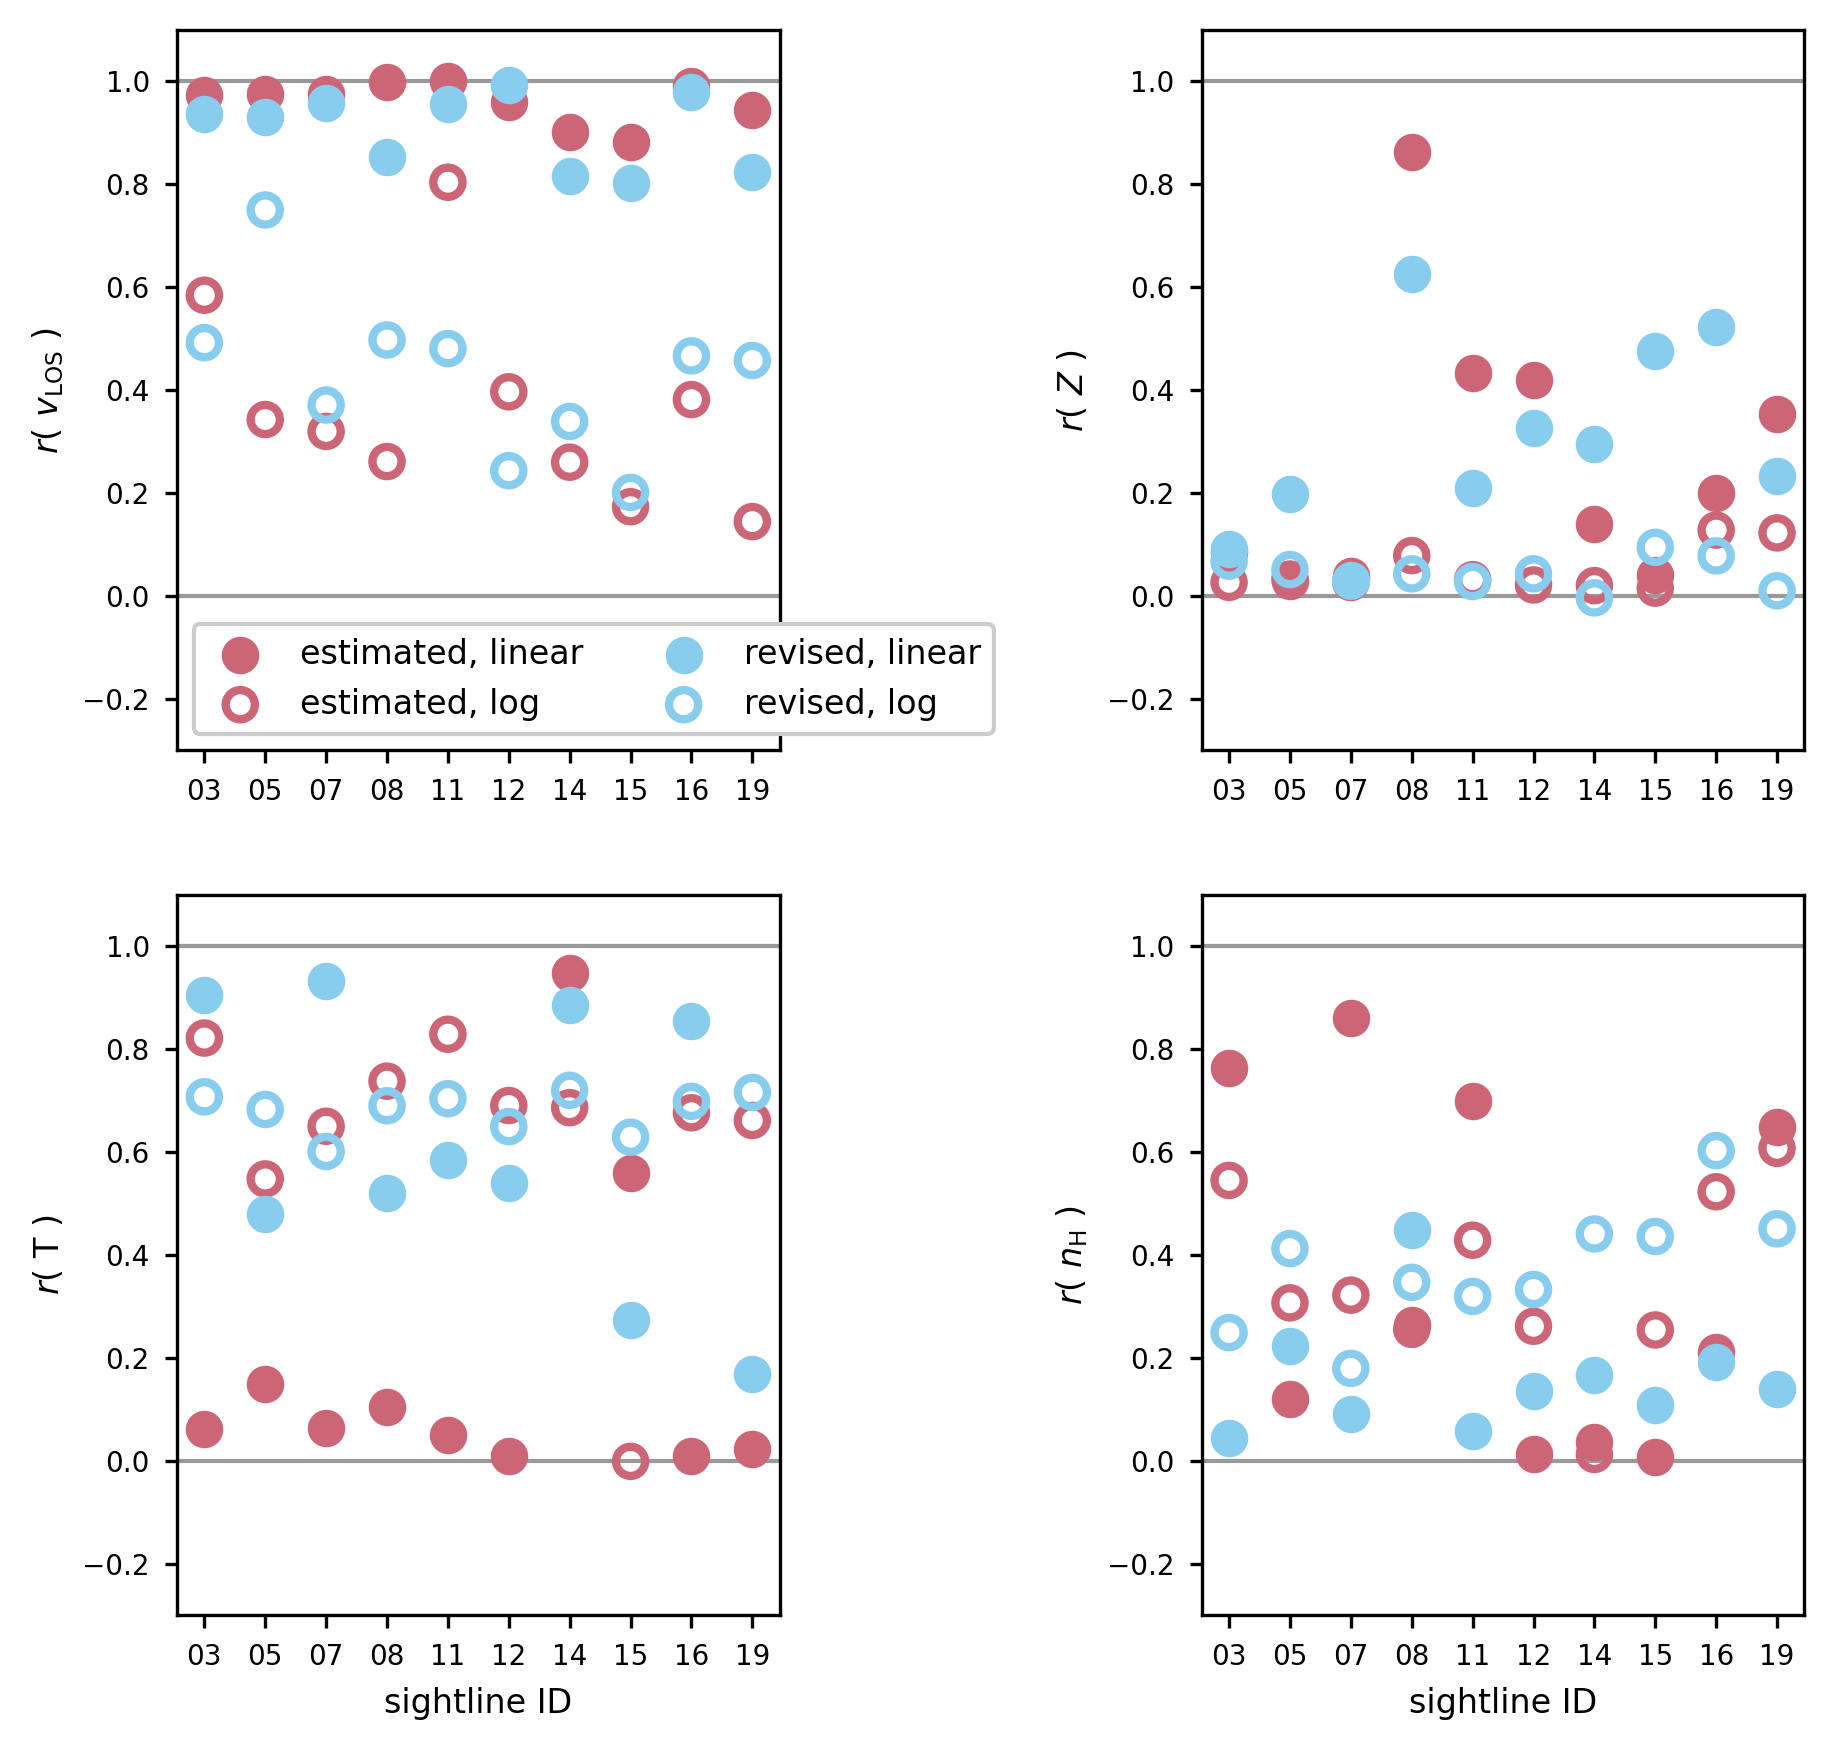

In [39]:
# Setup Figure
n_rows = len( mosaic_dist )
n_cols = len( mosaic_dist[0] )
panel_width = plt.rcParams['figure.figsize'][0]
fig = plt.figure( figsize=(n_cols*panel_width, n_rows*panel_width), facecolor='w' )
ax_dict = fig.subplot_mosaic(
    mosaic_dist,
    gridspec_kw = { 'wspace': 0.7 },
)
ax_dict['legend'] = ax_dict['vlos']

def r_scatter( ax, ys, c_key, color=None, label_tag=None ):
    c_params = helpers.correlation_coefficients[c_key]
    if 'logscale' in c_params:
        if c_params['logscale']:
            facecolors = 'none'
    else:
        facecolors = color
        
    scatter = ax.scatter(
        xs,
        ys,
        label = '{}, {}'.format( label_tag, c_key ),
        edgecolors = color,
        facecolors = facecolors,
        marker = correlation_markers[c_key],
        # s = correlation_sizes[c_key],
        linewidth = 2,
    )

    
# Overall
for variation, pm in pms.items():
    
    correlations = correlations_all[pm['public_label']]
    plotting_params = variation_plotting_params[variation]
    
    # for c_key in correlations_plotted:
    #     r_scatter(
    #         ax_dict['all'],
    #         correlations[c_key]['ndim'].array(),
    #         c_key,
    #         color = plotting_params['color'],
    #     )

    # Each property
    for j, x_key in enumerate( tqdm.tqdm( pm['prop_keys'], bar_format=pm['bar_format'] ) ):

        ax = ax_dict[x_key]

        for c_key in correlations_plotted:
            r_scatter(
                ax,
                correlations[c_key]['matrix'].array()[:,j,j],
                c_key,
                color = plotting_params['color'],
                label_tag = plotting_params['label'],
            )
    
        
# Add a legend
h, l = ax_dict['vlos'].get_legend_handles_labels()
legend = ax_dict['legend'].legend(
    h,
    l,
    loc = 'lower left',
    # prop = {'size': 14},
    ncol = 2,
    framealpha = 1,
)
# ax_dict['legend'].axis( 'off' )
# ax_dict['legend'].annotate(
#     text = r'$r = \frac{ \langle {\rm actual } \vert  {\rm found } \rangle }{ \vert {\rm actual} \vert \vert {\rm found } \vert }$',
#     xy = ( 0, 1 ),
#     xycoords = 'axes fraction',
#     xytext = ( 5, -5 ),
#     textcoords = 'offset points',
#     ha = 'center',
#     va = 'top',
#     fontsize = 18,
# )
        
# Cleanup
for x_key, ax in ax_dict.items():
    
    if x_key in [ 'legend', 'empty' ]:
        continue
    
    subplotspec = ax.get_subplotspec()
    
    for value in [ -1, 0, 1 ]:
        ax.axhline(
            value,
            color = pm['background_linecolor'],
            linewidth = 1,
            zorder = -100,
        )
        
    ax.set_ylabel( helpers.correlation_coefficient_property_labels[x_key] )
    if subplotspec.is_last_row():
        ax.set_xlabel( 'sightline ID', )
        
    ax.set_xticks( xs )
    xtick_labels = [ _[-2:] for _ in correlations[c_key]['ndim'].keys_array() ]
    ax.set_xticklabels( xtick_labels )
        
    ax.set_ylim( -0.3, 1.1 )
    
# Save
savedir = pm['figure_dir']
os.makedirs( savedir, exist_ok=True )
savefile = 'correlations.pdf'
save_fp = os.path.join( savedir, savefile )
print( 'Saving figure to {}'.format( save_fp ) )
plt.savefig( save_fp, bbox_inches='tight' )

# Compile Summary Data

In [40]:
summary = verdict.Dict({
    'averages': averages,
    'distances_between': distances_between,
    'percentiles': percentiles,
})

In [42]:
total_summary = verdict.Dict.from_hdf5( pm['summary_data_fp'], create_nonexistent=True )
total_summary['sample2'] = summary
total_summary.to_hdf5(  pm['summary_data_fp'], )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.88it/s]


In [44]:
summary

Dict, {
'averages' : Dict, {
'blinded' : Dict, {
'source' : Dict, {
'T' : Dict, {
'0003' : 4.13,
'0005' : 4.14,
'0007' : 4.12,
'0008' : 4.13,
'0011' : 4.12,
'0012' : 4.14,
'0014' : 4.26,
'0015' : 4.12,
'0016' : 4.12,
'0019' : 4.13,
}
,
'Z' : Dict, {
'0003' : -1.22,
'0005' : -1.26,
'0007' : -1.27,
'0008' : -1.24,
'0011' : -1.24,
'0012' : -1.2,
'0014' : -1.2,
'0015' : -1.23,
'0016' : -1.24,
'0019' : -1.27,
}
,
'nH' : Dict, {
'0003' : -1.86,
'0005' : -1.95,
'0007' : -1.91,
'0008' : -1.93,
'0011' : -1.97,
'0012' : -1.92,
'0014' : -2.13,
'0015' : -1.95,
'0016' : -1.6,
'0019' : -2.01,
}
,
'vlos' : Dict, {
'0003' : -7.05,
'0005' : -2.66,
'0007' : 1.52,
'0008' : -3.16,
'0011' : -1.99,
'0012' : -13.7,
'0014' : -21.5,
'0015' : 9.54,
'0016' : -0.831,
'0019' : -3.61,
}
,
}
,
'estimated' : Dict, {
'MLE' : Dict, {
'T' : Dict, {
'0003' : 4.3,
'0005' : 4.23,
'0007' : 4.27,
'0008' : 4.41,
'0011' : 4.23,
'0012' : 4.34,
'0014' : 4.27,
'0015' : 4.3,
'0016' : 4.27,
'0019' : 4.3,
}
,
'Z' : Dict, {
'0003' : 